In [1]:
### Prepare module structure ###

import sys
sys.path.append('../')

In [2]:
### IMPORT ###

import numpy as np
import math
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

import time

import matplotlib.pyplot as plt
%matplotlib inline

from util import *
from data import *
import models

# auto reload imports on local changes
%load_ext autoreload
%autoreload 2
print(torch.__version__)

1.0.0


In [3]:
### Check device ###

USE_GPU = True

dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    # TODO: Change to CPU used!
    device = torch.device('cuda:1')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda:1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


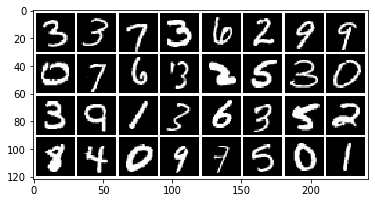

torch.Size([32, 1, 28, 28])


In [7]:
### LOAD DATA ###
dataset = 'mnist'
dataloader, imsize = load(dataset, path='/home/shared/phase-retrieval/data/' + dataset, batch_size=32)

sample = next(iter(dataloader['train']))
plot_grid(sample)
print(sample.shape)
sample_ft =  torch.rfft(sample, 2, onesided=False)
sample_magnitudes = torch.sqrt(torch.sum(sample_ft**2, -1))

In [4]:
### Test VAE ###

def test_model(model, device, testloader):
    # put model to eval mode
    model.eval()
    model.to(device)
    
    # move test images to device and reduce to magnitude information in fourier space
    test_images = []
    test_recon = []
    
    for data in testloader:
        data = data.to(device=device)

        outputs_recon, _, _ = model(data)

        test_images.append(data.cpu().numpy())
        test_recon.append(outputs_recon.detach().cpu().numpy())
    
    return np.concatenate(test_recon), np.concatenate(test_images)

In [5]:
# Define loss

def loss(out_image, in_image, alpha=2.0):
    return torch.mean(torch.abs(out_image - in_image) ** alpha)

def reg(mu, sigma):
    return torch.mean(sigma ** 2 + mu ** 2 - 2 * torch.log(sigma) - 1)

In [10]:
### DEFINE MODEL ###

latent_dim = 256
hidden_dim = 2048

vae = models.SignalVAE(shape=imsize, latent_dim=latent_dim, hidden_dim=hidden_dim)

Version 4


In [11]:
sum(p.numel() for p in vae.parameters() if p.requires_grad)

13182224

In [12]:
# Set training parameters

alpha_loss = 1.0
gamma = 1e-3 # 1e-3

optimizer = optim.Adam(vae.parameters(), lr=1e-3)

In [13]:
# Test the network 

sample_recon, sample_mu, sample_sigma = vae(sample)
print(sample_recon.shape)
print("Initial loss: ", loss(out_image=sample_recon, in_image=sample, alpha=alpha_loss).item())
print("Initial reg: ", gamma * reg(mu=sample_mu, sigma=sample_sigma).item())

torch.Size([32, 1, 28, 28])
Initial loss:  0.47295960783958435
Initial reg:  1.996610313653946e-06


In [14]:
def train_model(model, optimizer, device, loader_train, epochs=1):
    """
    Train a model
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - device: The device to perform computation on
    - load_train: The DataLoader object to feed the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Loss history per iteration step
    """
    # move the model parameters to CPU/GPU
    model = model.to(device=device)
    
    history_mse = []
    history = []
    
    for e in range(epochs):

        for t, x in enumerate(loader_train):
            # put model to training mode
            model.train()
            
            # move x to device and reduce to magnitude information in fourier space
            x = x.to(device=device)

            # compute loss as pixel wise distance to original input
            out_recon, out_mu, out_sigma = model(x)
            
            #loss = 
            reg_loss = gamma * reg(mu=out_mu, sigma=out_sigma)
            total_loss = loss(out_image=out_recon, in_image=x, alpha=alpha_loss) + reg_loss
            history.append(total_loss.item())

            # perform backprop and learning step
            optimizer.zero_grad()
            total_loss.backward() 
            optimizer.step()
            
            mse_loss = torch.mean((x - out_recon) ** 2)
            history_mse.append(mse_loss.detach().cpu().item())


            if t % 100 == 0:
                print("epoch: {:2} \t step:{} \t loss: {:3.4} \t reg loss: {:3.4}".format(e+1, t, history[-1], reg_loss))
                
        plt.plot(history[-10000:], label="loss")
        plt.plot(history_mse[-10000:], label="MSE")
        plt.legend()
        plt.show()
                
        test_outputs, test_images = test_model(model, device, dataloader['val'])
        plot_grid(np.vstack([test_images[:16],test_outputs[:16], test_images[16:32], test_outputs[16:32]]), figsize=(8,8))
        
        mse_val = np.mean((test_outputs - test_images)**2)
        print("Mean squared dist:", mse_val)
            
    return history

epoch:  1 	 step:0 	 loss: 0.4723 	 reg loss: 1.698e-06
epoch:  1 	 step:100 	 loss: 0.1181 	 reg loss: 0.0002978
epoch:  1 	 step:200 	 loss: 0.1219 	 reg loss: 0.0003306
epoch:  1 	 step:300 	 loss: 0.1199 	 reg loss: 0.0008314
epoch:  1 	 step:400 	 loss: 0.1027 	 reg loss: 0.0005168
epoch:  1 	 step:500 	 loss: 0.09239 	 reg loss: 0.000693
epoch:  1 	 step:600 	 loss: 0.09244 	 reg loss: 0.0008875
epoch:  1 	 step:700 	 loss: 0.08488 	 reg loss: 0.001002
epoch:  1 	 step:800 	 loss: 0.08183 	 reg loss: 0.001205
epoch:  1 	 step:900 	 loss: 0.08278 	 reg loss: 0.001414
epoch:  1 	 step:1000 	 loss: 0.07064 	 reg loss: 0.001164
epoch:  1 	 step:1100 	 loss: 0.06681 	 reg loss: 0.001468
epoch:  1 	 step:1200 	 loss: 0.06291 	 reg loss: 0.0015
epoch:  1 	 step:1300 	 loss: 0.06637 	 reg loss: 0.001513
epoch:  1 	 step:1400 	 loss: 0.05764 	 reg loss: 0.00146
epoch:  1 	 step:1500 	 loss: 0.05669 	 reg loss: 0.001541
epoch:  1 	 step:1600 	 loss: 0.06762 	 reg loss: 0.001552
epoch:  1 	

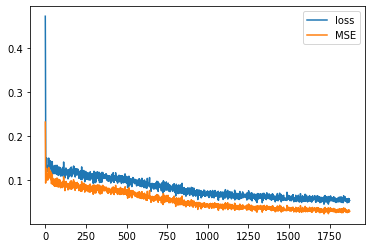

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


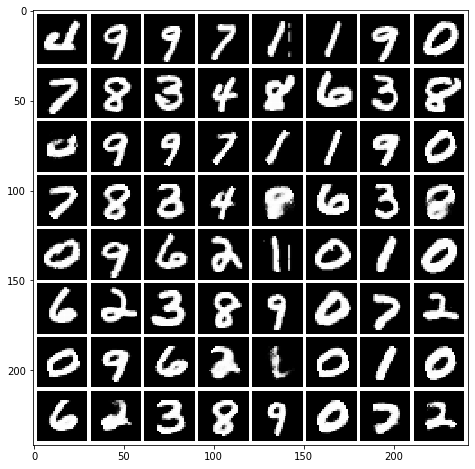

Mean squared dist: 0.030401833
epoch:  2 	 step:0 	 loss: 0.0583 	 reg loss: 0.001594
epoch:  2 	 step:100 	 loss: 0.05227 	 reg loss: 0.00179
epoch:  2 	 step:200 	 loss: 0.05465 	 reg loss: 0.001652
epoch:  2 	 step:300 	 loss: 0.04988 	 reg loss: 0.001745
epoch:  2 	 step:400 	 loss: 0.05457 	 reg loss: 0.001769
epoch:  2 	 step:500 	 loss: 0.05173 	 reg loss: 0.001777
epoch:  2 	 step:600 	 loss: 0.05086 	 reg loss: 0.001904
epoch:  2 	 step:700 	 loss: 0.04755 	 reg loss: 0.001774
epoch:  2 	 step:800 	 loss: 0.04698 	 reg loss: 0.001851
epoch:  2 	 step:900 	 loss: 0.04496 	 reg loss: 0.001812
epoch:  2 	 step:1000 	 loss: 0.04527 	 reg loss: 0.001815
epoch:  2 	 step:1100 	 loss: 0.04667 	 reg loss: 0.001767
epoch:  2 	 step:1200 	 loss: 0.04749 	 reg loss: 0.001835
epoch:  2 	 step:1300 	 loss: 0.04419 	 reg loss: 0.001957
epoch:  2 	 step:1400 	 loss: 0.04885 	 reg loss: 0.001877
epoch:  2 	 step:1500 	 loss: 0.04851 	 reg loss: 0.00178
epoch:  2 	 step:1600 	 loss: 0.04882 	 

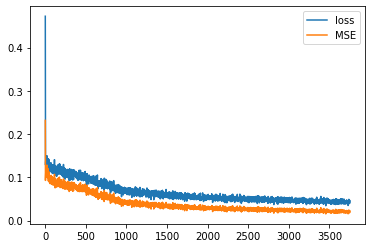

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


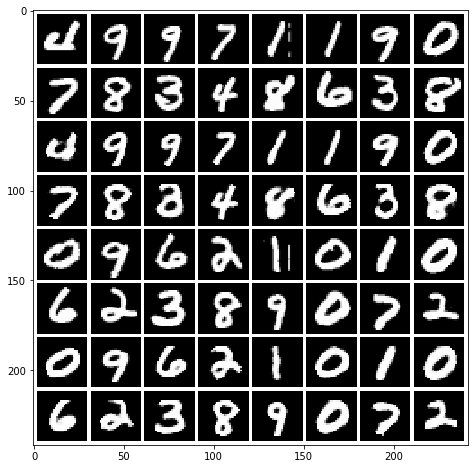

Mean squared dist: 0.021667756
epoch:  3 	 step:0 	 loss: 0.04606 	 reg loss: 0.001801
epoch:  3 	 step:100 	 loss: 0.03935 	 reg loss: 0.001798
epoch:  3 	 step:200 	 loss: 0.0447 	 reg loss: 0.002075
epoch:  3 	 step:300 	 loss: 0.04163 	 reg loss: 0.002052
epoch:  3 	 step:400 	 loss: 0.04062 	 reg loss: 0.001857
epoch:  3 	 step:500 	 loss: 0.04292 	 reg loss: 0.001842
epoch:  3 	 step:600 	 loss: 0.04171 	 reg loss: 0.001959
epoch:  3 	 step:700 	 loss: 0.03684 	 reg loss: 0.001847
epoch:  3 	 step:800 	 loss: 0.04575 	 reg loss: 0.001859
epoch:  3 	 step:900 	 loss: 0.0398 	 reg loss: 0.001826
epoch:  3 	 step:1000 	 loss: 0.03963 	 reg loss: 0.001793
epoch:  3 	 step:1100 	 loss: 0.04137 	 reg loss: 0.001823
epoch:  3 	 step:1200 	 loss: 0.03947 	 reg loss: 0.001908
epoch:  3 	 step:1300 	 loss: 0.04026 	 reg loss: 0.001926
epoch:  3 	 step:1400 	 loss: 0.04397 	 reg loss: 0.001883
epoch:  3 	 step:1500 	 loss: 0.04299 	 reg loss: 0.00194
epoch:  3 	 step:1600 	 loss: 0.04109 	 

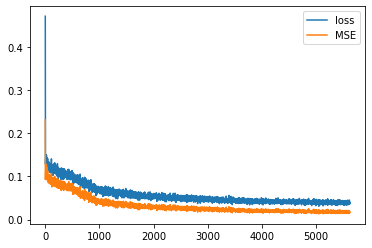

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


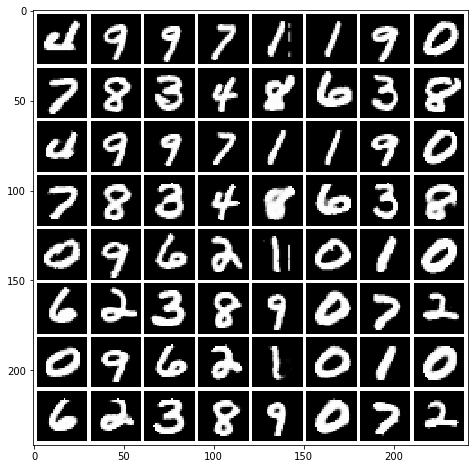

Mean squared dist: 0.017577939
epoch:  4 	 step:0 	 loss: 0.04216 	 reg loss: 0.001842
epoch:  4 	 step:100 	 loss: 0.03265 	 reg loss: 0.001854
epoch:  4 	 step:200 	 loss: 0.04052 	 reg loss: 0.001946
epoch:  4 	 step:300 	 loss: 0.03944 	 reg loss: 0.001967
epoch:  4 	 step:400 	 loss: 0.03699 	 reg loss: 0.001957
epoch:  4 	 step:500 	 loss: 0.03734 	 reg loss: 0.001926
epoch:  4 	 step:600 	 loss: 0.03098 	 reg loss: 0.001853
epoch:  4 	 step:700 	 loss: 0.03892 	 reg loss: 0.001937
epoch:  4 	 step:800 	 loss: 0.03403 	 reg loss: 0.001839
epoch:  4 	 step:900 	 loss: 0.03593 	 reg loss: 0.00191
epoch:  4 	 step:1000 	 loss: 0.03755 	 reg loss: 0.001976
epoch:  4 	 step:1100 	 loss: 0.03651 	 reg loss: 0.001919
epoch:  4 	 step:1200 	 loss: 0.03409 	 reg loss: 0.001938
epoch:  4 	 step:1300 	 loss: 0.03849 	 reg loss: 0.00186
epoch:  4 	 step:1400 	 loss: 0.03482 	 reg loss: 0.001841
epoch:  4 	 step:1500 	 loss: 0.03718 	 reg loss: 0.001902
epoch:  4 	 step:1600 	 loss: 0.03559 	

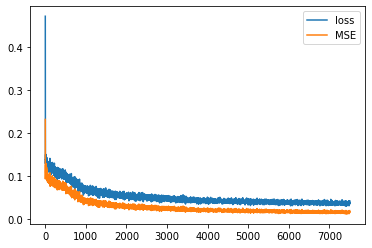

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


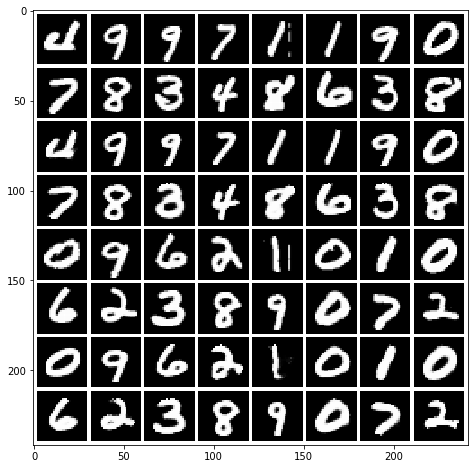

Mean squared dist: 0.015411425
epoch:  5 	 step:0 	 loss: 0.03661 	 reg loss: 0.001867
epoch:  5 	 step:100 	 loss: 0.03534 	 reg loss: 0.001786
epoch:  5 	 step:200 	 loss: 0.0348 	 reg loss: 0.001919
epoch:  5 	 step:300 	 loss: 0.03643 	 reg loss: 0.001994
epoch:  5 	 step:400 	 loss: 0.0371 	 reg loss: 0.001964
epoch:  5 	 step:500 	 loss: 0.03889 	 reg loss: 0.001883
epoch:  5 	 step:600 	 loss: 0.04285 	 reg loss: 0.001987
epoch:  5 	 step:700 	 loss: 0.03229 	 reg loss: 0.001863
epoch:  5 	 step:800 	 loss: 0.03414 	 reg loss: 0.001978
epoch:  5 	 step:900 	 loss: 0.03431 	 reg loss: 0.002004
epoch:  5 	 step:1000 	 loss: 0.03708 	 reg loss: 0.001931
epoch:  5 	 step:1100 	 loss: 0.0357 	 reg loss: 0.001934
epoch:  5 	 step:1200 	 loss: 0.03854 	 reg loss: 0.001846
epoch:  5 	 step:1300 	 loss: 0.03319 	 reg loss: 0.001941
epoch:  5 	 step:1400 	 loss: 0.03243 	 reg loss: 0.001852
epoch:  5 	 step:1500 	 loss: 0.03363 	 reg loss: 0.002026
epoch:  5 	 step:1600 	 loss: 0.03587 	 

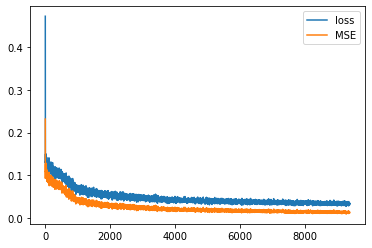

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


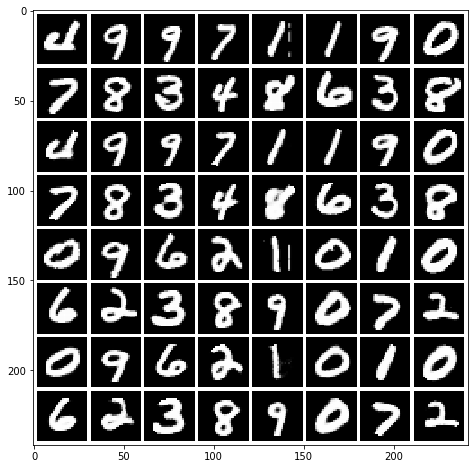

Mean squared dist: 0.013467578
epoch:  6 	 step:0 	 loss: 0.03173 	 reg loss: 0.001892
epoch:  6 	 step:100 	 loss: 0.03201 	 reg loss: 0.001893
epoch:  6 	 step:200 	 loss: 0.03023 	 reg loss: 0.001881
epoch:  6 	 step:300 	 loss: 0.03081 	 reg loss: 0.001799
epoch:  6 	 step:400 	 loss: 0.03405 	 reg loss: 0.001905
epoch:  6 	 step:500 	 loss: 0.03358 	 reg loss: 0.001849
epoch:  6 	 step:600 	 loss: 0.0296 	 reg loss: 0.001805
epoch:  6 	 step:700 	 loss: 0.03777 	 reg loss: 0.001935
epoch:  6 	 step:800 	 loss: 0.03086 	 reg loss: 0.001785
epoch:  6 	 step:900 	 loss: 0.03282 	 reg loss: 0.001844
epoch:  6 	 step:1000 	 loss: 0.03299 	 reg loss: 0.001966
epoch:  6 	 step:1100 	 loss: 0.03381 	 reg loss: 0.001966
epoch:  6 	 step:1200 	 loss: 0.03063 	 reg loss: 0.001845
epoch:  6 	 step:1300 	 loss: 0.03304 	 reg loss: 0.001853
epoch:  6 	 step:1400 	 loss: 0.03225 	 reg loss: 0.00182
epoch:  6 	 step:1500 	 loss: 0.03309 	 reg loss: 0.001815
epoch:  6 	 step:1600 	 loss: 0.02766 	

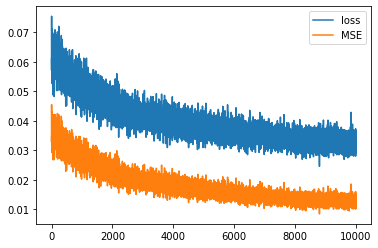

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


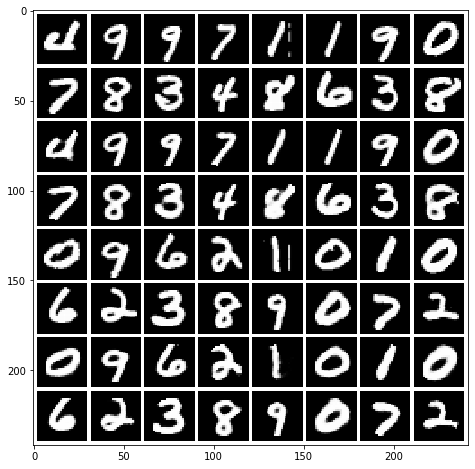

Mean squared dist: 0.012802875
epoch:  7 	 step:0 	 loss: 0.03242 	 reg loss: 0.001817
epoch:  7 	 step:100 	 loss: 0.03103 	 reg loss: 0.001854
epoch:  7 	 step:200 	 loss: 0.03019 	 reg loss: 0.001809
epoch:  7 	 step:300 	 loss: 0.03341 	 reg loss: 0.001839
epoch:  7 	 step:400 	 loss: 0.03282 	 reg loss: 0.00197
epoch:  7 	 step:500 	 loss: 0.03372 	 reg loss: 0.001869
epoch:  7 	 step:600 	 loss: 0.02964 	 reg loss: 0.00174
epoch:  7 	 step:700 	 loss: 0.03543 	 reg loss: 0.00189
epoch:  7 	 step:800 	 loss: 0.03525 	 reg loss: 0.00176
epoch:  7 	 step:900 	 loss: 0.02959 	 reg loss: 0.001788
epoch:  7 	 step:1000 	 loss: 0.03718 	 reg loss: 0.001918
epoch:  7 	 step:1100 	 loss: 0.03041 	 reg loss: 0.001883
epoch:  7 	 step:1200 	 loss: 0.03102 	 reg loss: 0.001811
epoch:  7 	 step:1300 	 loss: 0.03292 	 reg loss: 0.001881
epoch:  7 	 step:1400 	 loss: 0.03336 	 reg loss: 0.001814
epoch:  7 	 step:1500 	 loss: 0.02957 	 reg loss: 0.001843
epoch:  7 	 step:1600 	 loss: 0.02881 	 r

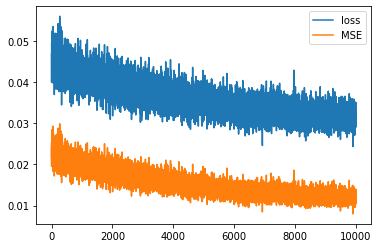

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


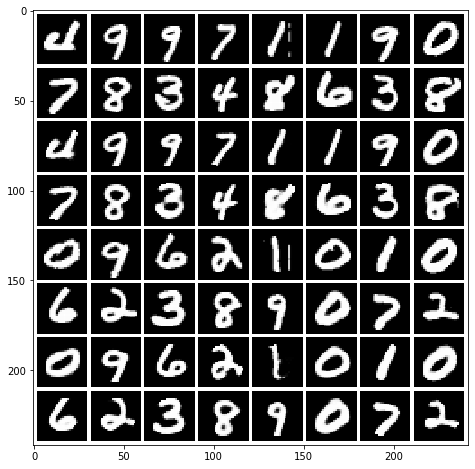

Mean squared dist: 0.01235278
epoch:  8 	 step:0 	 loss: 0.02901 	 reg loss: 0.00176
epoch:  8 	 step:100 	 loss: 0.02992 	 reg loss: 0.00177
epoch:  8 	 step:200 	 loss: 0.03258 	 reg loss: 0.001816
epoch:  8 	 step:300 	 loss: 0.03113 	 reg loss: 0.001733
epoch:  8 	 step:400 	 loss: 0.03351 	 reg loss: 0.001904
epoch:  8 	 step:500 	 loss: 0.03244 	 reg loss: 0.001801
epoch:  8 	 step:600 	 loss: 0.03388 	 reg loss: 0.001784
epoch:  8 	 step:700 	 loss: 0.03091 	 reg loss: 0.001789
epoch:  8 	 step:800 	 loss: 0.03201 	 reg loss: 0.001824
epoch:  8 	 step:900 	 loss: 0.03115 	 reg loss: 0.001892
epoch:  8 	 step:1000 	 loss: 0.02858 	 reg loss: 0.001687
epoch:  8 	 step:1100 	 loss: 0.03083 	 reg loss: 0.001738
epoch:  8 	 step:1200 	 loss: 0.03141 	 reg loss: 0.001742
epoch:  8 	 step:1300 	 loss: 0.03296 	 reg loss: 0.001813
epoch:  8 	 step:1400 	 loss: 0.03116 	 reg loss: 0.001716
epoch:  8 	 step:1500 	 loss: 0.03094 	 reg loss: 0.001786
epoch:  8 	 step:1600 	 loss: 0.03087 	 

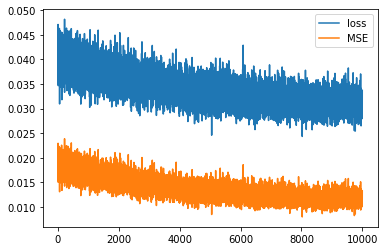

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


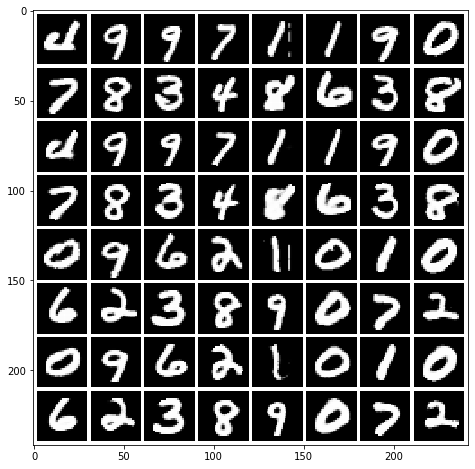

Mean squared dist: 0.011924773
epoch:  9 	 step:0 	 loss: 0.02908 	 reg loss: 0.001724
epoch:  9 	 step:100 	 loss: 0.02765 	 reg loss: 0.001737
epoch:  9 	 step:200 	 loss: 0.03206 	 reg loss: 0.00185
epoch:  9 	 step:300 	 loss: 0.03326 	 reg loss: 0.001791
epoch:  9 	 step:400 	 loss: 0.03315 	 reg loss: 0.001758
epoch:  9 	 step:500 	 loss: 0.03085 	 reg loss: 0.001852
epoch:  9 	 step:600 	 loss: 0.0335 	 reg loss: 0.001843
epoch:  9 	 step:700 	 loss: 0.0298 	 reg loss: 0.001823
epoch:  9 	 step:800 	 loss: 0.0287 	 reg loss: 0.001778
epoch:  9 	 step:900 	 loss: 0.03301 	 reg loss: 0.001679
epoch:  9 	 step:1000 	 loss: 0.02952 	 reg loss: 0.001714
epoch:  9 	 step:1100 	 loss: 0.03003 	 reg loss: 0.001757
epoch:  9 	 step:1200 	 loss: 0.02882 	 reg loss: 0.001683
epoch:  9 	 step:1300 	 loss: 0.03182 	 reg loss: 0.001686
epoch:  9 	 step:1400 	 loss: 0.03172 	 reg loss: 0.001841
epoch:  9 	 step:1500 	 loss: 0.02976 	 reg loss: 0.001829
epoch:  9 	 step:1600 	 loss: 0.03014 	 r

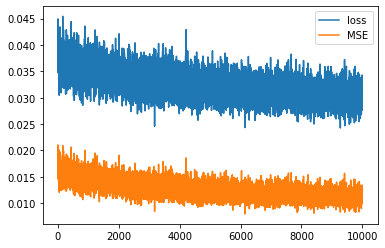

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


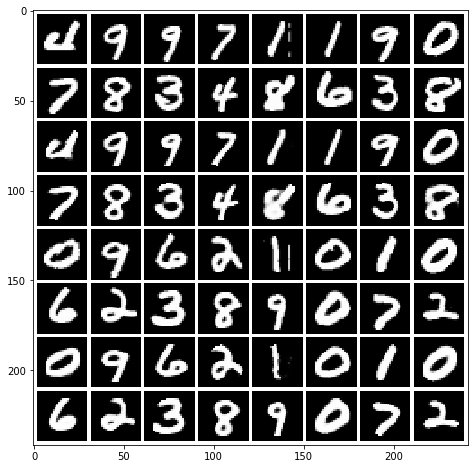

Mean squared dist: 0.011543931
epoch: 10 	 step:0 	 loss: 0.03287 	 reg loss: 0.001806
epoch: 10 	 step:100 	 loss: 0.02748 	 reg loss: 0.001713
epoch: 10 	 step:200 	 loss: 0.03079 	 reg loss: 0.001712
epoch: 10 	 step:300 	 loss: 0.03096 	 reg loss: 0.001799
epoch: 10 	 step:400 	 loss: 0.03205 	 reg loss: 0.001808
epoch: 10 	 step:500 	 loss: 0.03237 	 reg loss: 0.00175
epoch: 10 	 step:600 	 loss: 0.02806 	 reg loss: 0.001692
epoch: 10 	 step:700 	 loss: 0.0308 	 reg loss: 0.001734
epoch: 10 	 step:800 	 loss: 0.03041 	 reg loss: 0.001754
epoch: 10 	 step:900 	 loss: 0.029 	 reg loss: 0.001697
epoch: 10 	 step:1000 	 loss: 0.02822 	 reg loss: 0.001648
epoch: 10 	 step:1100 	 loss: 0.02976 	 reg loss: 0.001658
epoch: 10 	 step:1200 	 loss: 0.02708 	 reg loss: 0.001725
epoch: 10 	 step:1300 	 loss: 0.02807 	 reg loss: 0.001748
epoch: 10 	 step:1400 	 loss: 0.03084 	 reg loss: 0.001693
epoch: 10 	 step:1500 	 loss: 0.03168 	 reg loss: 0.001738
epoch: 10 	 step:1600 	 loss: 0.02779 	 r

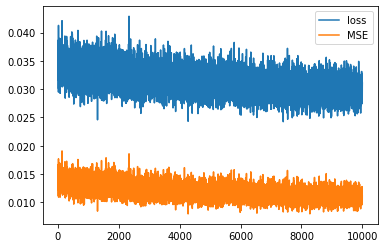

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


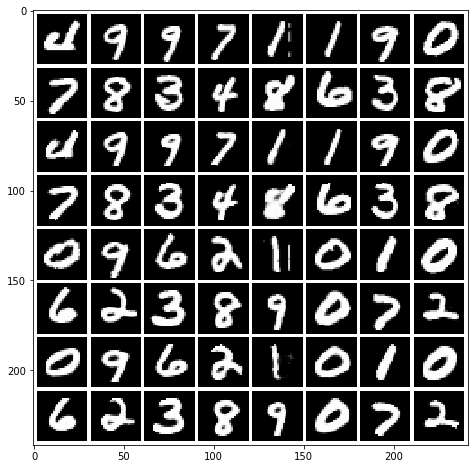

Mean squared dist: 0.011427604
epoch: 11 	 step:0 	 loss: 0.02988 	 reg loss: 0.001654
epoch: 11 	 step:100 	 loss: 0.02906 	 reg loss: 0.001773
epoch: 11 	 step:200 	 loss: 0.02896 	 reg loss: 0.001805
epoch: 11 	 step:300 	 loss: 0.02733 	 reg loss: 0.00174
epoch: 11 	 step:400 	 loss: 0.02933 	 reg loss: 0.001695
epoch: 11 	 step:500 	 loss: 0.03175 	 reg loss: 0.001784
epoch: 11 	 step:600 	 loss: 0.03186 	 reg loss: 0.001781
epoch: 11 	 step:700 	 loss: 0.02897 	 reg loss: 0.001714
epoch: 11 	 step:800 	 loss: 0.02794 	 reg loss: 0.001684
epoch: 11 	 step:900 	 loss: 0.03049 	 reg loss: 0.001703
epoch: 11 	 step:1000 	 loss: 0.03114 	 reg loss: 0.001676
epoch: 11 	 step:1100 	 loss: 0.02862 	 reg loss: 0.001657
epoch: 11 	 step:1200 	 loss: 0.02843 	 reg loss: 0.001636
epoch: 11 	 step:1300 	 loss: 0.02975 	 reg loss: 0.001662
epoch: 11 	 step:1400 	 loss: 0.02617 	 reg loss: 0.001667
epoch: 11 	 step:1500 	 loss: 0.0284 	 reg loss: 0.00163
epoch: 11 	 step:1600 	 loss: 0.02996 	 

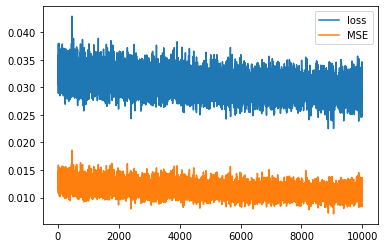

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


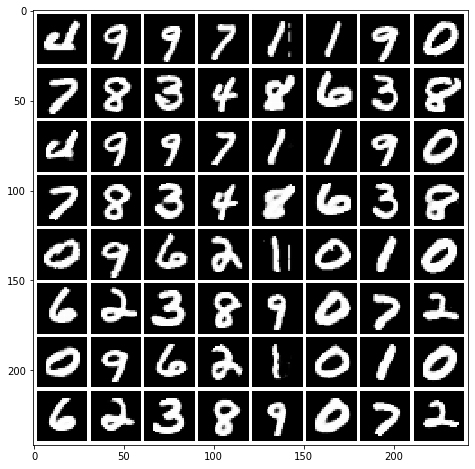

Mean squared dist: 0.011242059
epoch: 12 	 step:0 	 loss: 0.0317 	 reg loss: 0.001771
epoch: 12 	 step:100 	 loss: 0.03284 	 reg loss: 0.001719
epoch: 12 	 step:200 	 loss: 0.02985 	 reg loss: 0.00163
epoch: 12 	 step:300 	 loss: 0.02721 	 reg loss: 0.001684
epoch: 12 	 step:400 	 loss: 0.02868 	 reg loss: 0.001575
epoch: 12 	 step:500 	 loss: 0.0316 	 reg loss: 0.00178
epoch: 12 	 step:600 	 loss: 0.02722 	 reg loss: 0.001603
epoch: 12 	 step:700 	 loss: 0.02872 	 reg loss: 0.001733
epoch: 12 	 step:800 	 loss: 0.02696 	 reg loss: 0.001732
epoch: 12 	 step:900 	 loss: 0.03187 	 reg loss: 0.00169
epoch: 12 	 step:1000 	 loss: 0.0275 	 reg loss: 0.001668
epoch: 12 	 step:1100 	 loss: 0.03265 	 reg loss: 0.001781
epoch: 12 	 step:1200 	 loss: 0.02694 	 reg loss: 0.001623
epoch: 12 	 step:1300 	 loss: 0.02649 	 reg loss: 0.001629
epoch: 12 	 step:1400 	 loss: 0.02659 	 reg loss: 0.001615
epoch: 12 	 step:1500 	 loss: 0.03061 	 reg loss: 0.001731
epoch: 12 	 step:1600 	 loss: 0.03016 	 reg

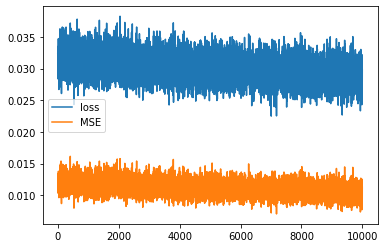

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


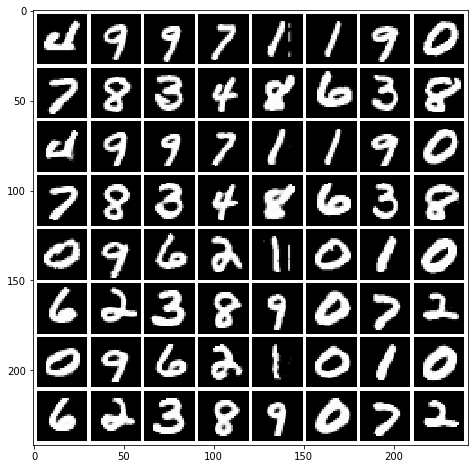

Mean squared dist: 0.010928282
epoch: 13 	 step:0 	 loss: 0.02622 	 reg loss: 0.001638
epoch: 13 	 step:100 	 loss: 0.02687 	 reg loss: 0.001565
epoch: 13 	 step:200 	 loss: 0.02785 	 reg loss: 0.001676
epoch: 13 	 step:300 	 loss: 0.02808 	 reg loss: 0.00172
epoch: 13 	 step:400 	 loss: 0.02917 	 reg loss: 0.001685
epoch: 13 	 step:500 	 loss: 0.02904 	 reg loss: 0.001639
epoch: 13 	 step:600 	 loss: 0.03068 	 reg loss: 0.001659
epoch: 13 	 step:700 	 loss: 0.02885 	 reg loss: 0.001649
epoch: 13 	 step:800 	 loss: 0.02983 	 reg loss: 0.001712
epoch: 13 	 step:900 	 loss: 0.02928 	 reg loss: 0.001683
epoch: 13 	 step:1000 	 loss: 0.02922 	 reg loss: 0.001677
epoch: 13 	 step:1100 	 loss: 0.03134 	 reg loss: 0.001626
epoch: 13 	 step:1200 	 loss: 0.02273 	 reg loss: 0.001537
epoch: 13 	 step:1300 	 loss: 0.02996 	 reg loss: 0.001673
epoch: 13 	 step:1400 	 loss: 0.02909 	 reg loss: 0.0017
epoch: 13 	 step:1500 	 loss: 0.02993 	 reg loss: 0.001712
epoch: 13 	 step:1600 	 loss: 0.02922 	 

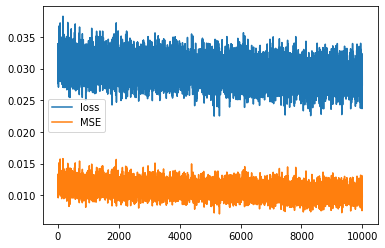

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


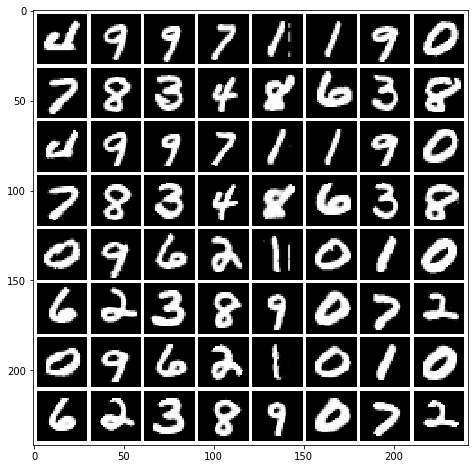

Mean squared dist: 0.010743041
epoch: 14 	 step:0 	 loss: 0.02959 	 reg loss: 0.001605
epoch: 14 	 step:100 	 loss: 0.02972 	 reg loss: 0.001659
epoch: 14 	 step:200 	 loss: 0.02582 	 reg loss: 0.001549
epoch: 14 	 step:300 	 loss: 0.02896 	 reg loss: 0.001705
epoch: 14 	 step:400 	 loss: 0.0319 	 reg loss: 0.001726
epoch: 14 	 step:500 	 loss: 0.02692 	 reg loss: 0.001654
epoch: 14 	 step:600 	 loss: 0.02728 	 reg loss: 0.001641
epoch: 14 	 step:700 	 loss: 0.02698 	 reg loss: 0.001642
epoch: 14 	 step:800 	 loss: 0.02533 	 reg loss: 0.00157
epoch: 14 	 step:900 	 loss: 0.0257 	 reg loss: 0.001592
epoch: 14 	 step:1000 	 loss: 0.03053 	 reg loss: 0.001621
epoch: 14 	 step:1100 	 loss: 0.02534 	 reg loss: 0.001577
epoch: 14 	 step:1200 	 loss: 0.02916 	 reg loss: 0.00169
epoch: 14 	 step:1300 	 loss: 0.02752 	 reg loss: 0.001696
epoch: 14 	 step:1400 	 loss: 0.02964 	 reg loss: 0.001656
epoch: 14 	 step:1500 	 loss: 0.02808 	 reg loss: 0.001628
epoch: 14 	 step:1600 	 loss: 0.0301 	 re

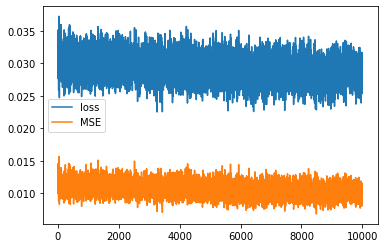

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


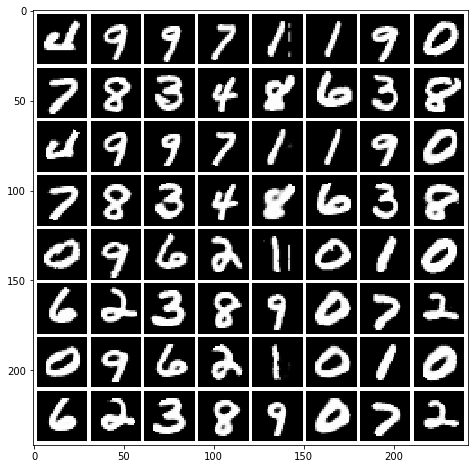

Mean squared dist: 0.01052843
epoch: 15 	 step:0 	 loss: 0.02833 	 reg loss: 0.001621
epoch: 15 	 step:100 	 loss: 0.02768 	 reg loss: 0.001613
epoch: 15 	 step:200 	 loss: 0.03202 	 reg loss: 0.001696
epoch: 15 	 step:300 	 loss: 0.03063 	 reg loss: 0.001668
epoch: 15 	 step:400 	 loss: 0.0302 	 reg loss: 0.00158
epoch: 15 	 step:500 	 loss: 0.02761 	 reg loss: 0.001607
epoch: 15 	 step:600 	 loss: 0.0266 	 reg loss: 0.001617
epoch: 15 	 step:700 	 loss: 0.02519 	 reg loss: 0.001582
epoch: 15 	 step:800 	 loss: 0.02606 	 reg loss: 0.001633
epoch: 15 	 step:900 	 loss: 0.02866 	 reg loss: 0.00163
epoch: 15 	 step:1000 	 loss: 0.02722 	 reg loss: 0.001572
epoch: 15 	 step:1100 	 loss: 0.02692 	 reg loss: 0.00163
epoch: 15 	 step:1200 	 loss: 0.02765 	 reg loss: 0.001615
epoch: 15 	 step:1300 	 loss: 0.02531 	 reg loss: 0.001504
epoch: 15 	 step:1400 	 loss: 0.02641 	 reg loss: 0.001663
epoch: 15 	 step:1500 	 loss: 0.03303 	 reg loss: 0.001673
epoch: 15 	 step:1600 	 loss: 0.02715 	 reg

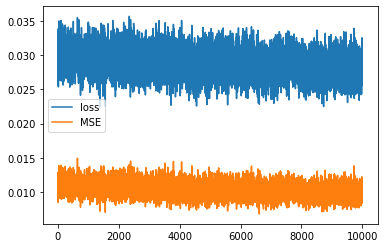

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


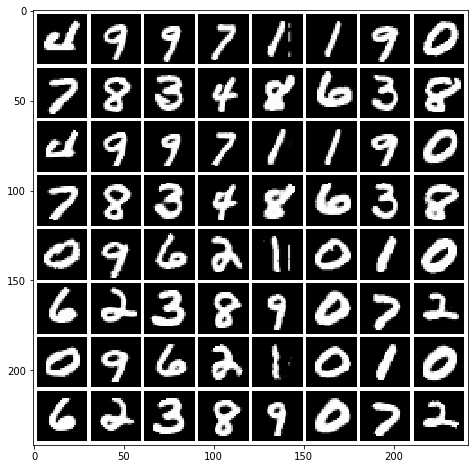

Mean squared dist: 0.010246508
epoch: 16 	 step:0 	 loss: 0.02785 	 reg loss: 0.001587
epoch: 16 	 step:100 	 loss: 0.02724 	 reg loss: 0.001683
epoch: 16 	 step:200 	 loss: 0.02666 	 reg loss: 0.001616
epoch: 16 	 step:300 	 loss: 0.02636 	 reg loss: 0.001583
epoch: 16 	 step:400 	 loss: 0.02761 	 reg loss: 0.001603
epoch: 16 	 step:500 	 loss: 0.0264 	 reg loss: 0.001654
epoch: 16 	 step:600 	 loss: 0.02744 	 reg loss: 0.001566
epoch: 16 	 step:700 	 loss: 0.02595 	 reg loss: 0.0015
epoch: 16 	 step:800 	 loss: 0.03029 	 reg loss: 0.001602
epoch: 16 	 step:900 	 loss: 0.02559 	 reg loss: 0.001474
epoch: 16 	 step:1000 	 loss: 0.02834 	 reg loss: 0.001656
epoch: 16 	 step:1100 	 loss: 0.0291 	 reg loss: 0.001661
epoch: 16 	 step:1200 	 loss: 0.02617 	 reg loss: 0.001554
epoch: 16 	 step:1300 	 loss: 0.0248 	 reg loss: 0.001627
epoch: 16 	 step:1400 	 loss: 0.02602 	 reg loss: 0.00161
epoch: 16 	 step:1500 	 loss: 0.02825 	 reg loss: 0.001626
epoch: 16 	 step:1600 	 loss: 0.02881 	 reg

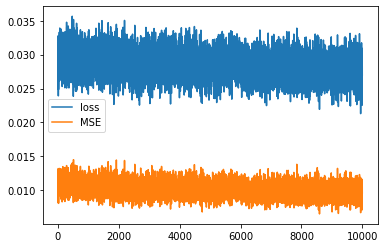

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


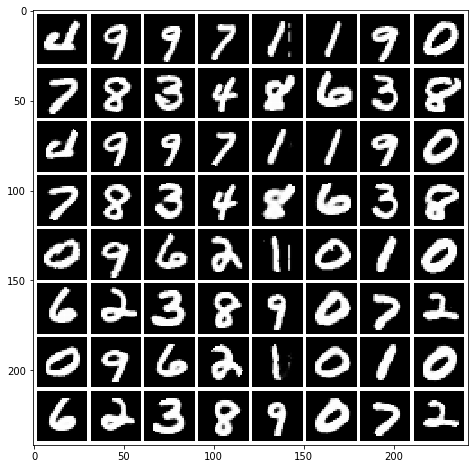

Mean squared dist: 0.010113186
epoch: 17 	 step:0 	 loss: 0.02916 	 reg loss: 0.001603
epoch: 17 	 step:100 	 loss: 0.0249 	 reg loss: 0.001575
epoch: 17 	 step:200 	 loss: 0.02304 	 reg loss: 0.001555
epoch: 17 	 step:300 	 loss: 0.02787 	 reg loss: 0.001614
epoch: 17 	 step:400 	 loss: 0.0273 	 reg loss: 0.001624
epoch: 17 	 step:500 	 loss: 0.02941 	 reg loss: 0.001706
epoch: 17 	 step:600 	 loss: 0.02565 	 reg loss: 0.001604
epoch: 17 	 step:700 	 loss: 0.02939 	 reg loss: 0.001603
epoch: 17 	 step:800 	 loss: 0.03023 	 reg loss: 0.001727
epoch: 17 	 step:900 	 loss: 0.02881 	 reg loss: 0.001653
epoch: 17 	 step:1000 	 loss: 0.02461 	 reg loss: 0.0016
epoch: 17 	 step:1100 	 loss: 0.02627 	 reg loss: 0.001573
epoch: 17 	 step:1200 	 loss: 0.02831 	 reg loss: 0.001623
epoch: 17 	 step:1300 	 loss: 0.02698 	 reg loss: 0.001611
epoch: 17 	 step:1400 	 loss: 0.02628 	 reg loss: 0.001569
epoch: 17 	 step:1500 	 loss: 0.02634 	 reg loss: 0.001557
epoch: 17 	 step:1600 	 loss: 0.02723 	 r

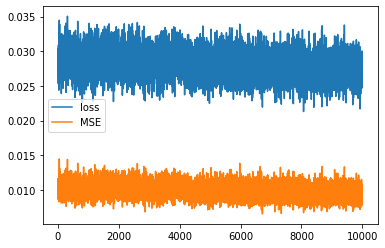

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


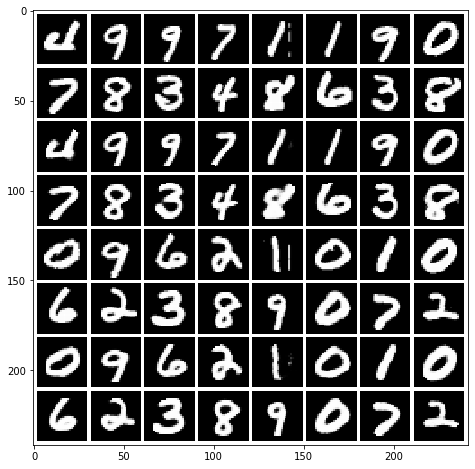

Mean squared dist: 0.010127026
epoch: 18 	 step:0 	 loss: 0.02663 	 reg loss: 0.001616
epoch: 18 	 step:100 	 loss: 0.0259 	 reg loss: 0.001582
epoch: 18 	 step:200 	 loss: 0.02578 	 reg loss: 0.001604
epoch: 18 	 step:300 	 loss: 0.02866 	 reg loss: 0.001631
epoch: 18 	 step:400 	 loss: 0.0273 	 reg loss: 0.001553
epoch: 18 	 step:500 	 loss: 0.02649 	 reg loss: 0.001535
epoch: 18 	 step:600 	 loss: 0.03009 	 reg loss: 0.001588
epoch: 18 	 step:700 	 loss: 0.0278 	 reg loss: 0.00154
epoch: 18 	 step:800 	 loss: 0.02614 	 reg loss: 0.0015
epoch: 18 	 step:900 	 loss: 0.02669 	 reg loss: 0.001554
epoch: 18 	 step:1000 	 loss: 0.02647 	 reg loss: 0.00156
epoch: 18 	 step:1100 	 loss: 0.02647 	 reg loss: 0.001606
epoch: 18 	 step:1200 	 loss: 0.02733 	 reg loss: 0.001597
epoch: 18 	 step:1300 	 loss: 0.02801 	 reg loss: 0.001577
epoch: 18 	 step:1400 	 loss: 0.02708 	 reg loss: 0.00154
epoch: 18 	 step:1500 	 loss: 0.02868 	 reg loss: 0.001589
epoch: 18 	 step:1600 	 loss: 0.02364 	 reg l

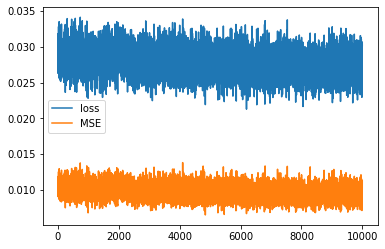

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


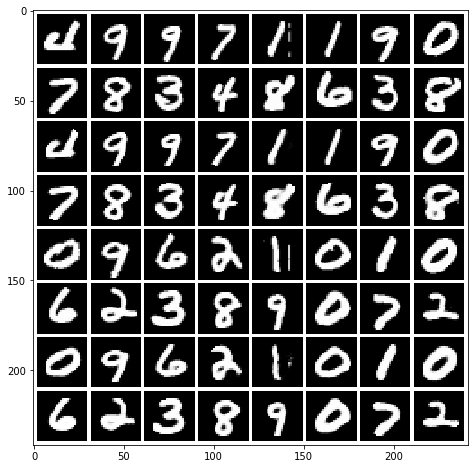

Mean squared dist: 0.010047836
epoch: 19 	 step:0 	 loss: 0.02606 	 reg loss: 0.001536
epoch: 19 	 step:100 	 loss: 0.0279 	 reg loss: 0.001666
epoch: 19 	 step:200 	 loss: 0.02756 	 reg loss: 0.001616
epoch: 19 	 step:300 	 loss: 0.02494 	 reg loss: 0.001592
epoch: 19 	 step:400 	 loss: 0.02735 	 reg loss: 0.00163
epoch: 19 	 step:500 	 loss: 0.02774 	 reg loss: 0.001626
epoch: 19 	 step:600 	 loss: 0.03099 	 reg loss: 0.001654
epoch: 19 	 step:700 	 loss: 0.026 	 reg loss: 0.001509
epoch: 19 	 step:800 	 loss: 0.02607 	 reg loss: 0.001558
epoch: 19 	 step:900 	 loss: 0.02715 	 reg loss: 0.001566
epoch: 19 	 step:1000 	 loss: 0.02762 	 reg loss: 0.001594
epoch: 19 	 step:1100 	 loss: 0.02989 	 reg loss: 0.001607
epoch: 19 	 step:1200 	 loss: 0.02622 	 reg loss: 0.001538
epoch: 19 	 step:1300 	 loss: 0.02845 	 reg loss: 0.001614
epoch: 19 	 step:1400 	 loss: 0.02691 	 reg loss: 0.001508
epoch: 19 	 step:1500 	 loss: 0.02448 	 reg loss: 0.001508
epoch: 19 	 step:1600 	 loss: 0.03041 	 r

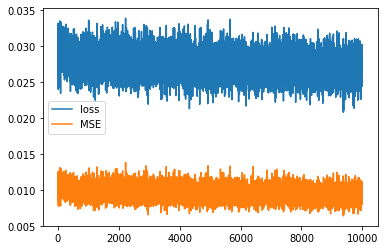

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


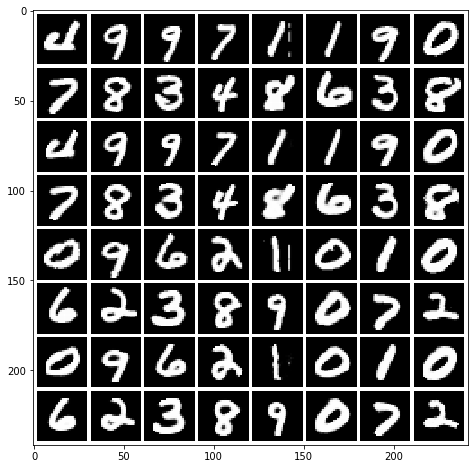

Mean squared dist: 0.00990669
epoch: 20 	 step:0 	 loss: 0.02646 	 reg loss: 0.001442
epoch: 20 	 step:100 	 loss: 0.02507 	 reg loss: 0.00155
epoch: 20 	 step:200 	 loss: 0.02428 	 reg loss: 0.001518
epoch: 20 	 step:300 	 loss: 0.02864 	 reg loss: 0.001535
epoch: 20 	 step:400 	 loss: 0.03015 	 reg loss: 0.0016
epoch: 20 	 step:500 	 loss: 0.02533 	 reg loss: 0.001541
epoch: 20 	 step:600 	 loss: 0.02502 	 reg loss: 0.001582
epoch: 20 	 step:700 	 loss: 0.02328 	 reg loss: 0.001495
epoch: 20 	 step:800 	 loss: 0.02744 	 reg loss: 0.001601
epoch: 20 	 step:900 	 loss: 0.02368 	 reg loss: 0.001483
epoch: 20 	 step:1000 	 loss: 0.02584 	 reg loss: 0.001503
epoch: 20 	 step:1100 	 loss: 0.02754 	 reg loss: 0.001557
epoch: 20 	 step:1200 	 loss: 0.03028 	 reg loss: 0.001549
epoch: 20 	 step:1300 	 loss: 0.02817 	 reg loss: 0.001473
epoch: 20 	 step:1400 	 loss: 0.02688 	 reg loss: 0.001569
epoch: 20 	 step:1500 	 loss: 0.02721 	 reg loss: 0.001565
epoch: 20 	 step:1600 	 loss: 0.02681 	 r

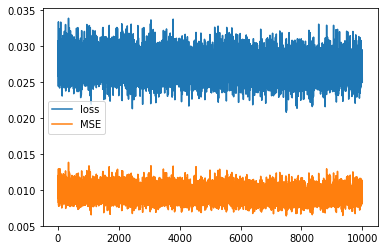

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


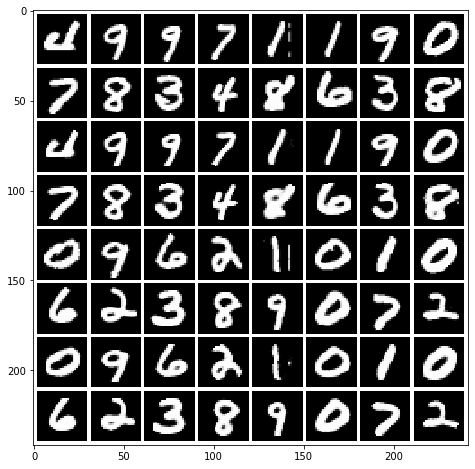

Mean squared dist: 0.009914073
epoch: 21 	 step:0 	 loss: 0.0268 	 reg loss: 0.001584
epoch: 21 	 step:100 	 loss: 0.02374 	 reg loss: 0.001491
epoch: 21 	 step:200 	 loss: 0.02248 	 reg loss: 0.001471
epoch: 21 	 step:300 	 loss: 0.02563 	 reg loss: 0.001543
epoch: 21 	 step:400 	 loss: 0.02365 	 reg loss: 0.001473
epoch: 21 	 step:500 	 loss: 0.02857 	 reg loss: 0.001596
epoch: 21 	 step:600 	 loss: 0.02586 	 reg loss: 0.001563
epoch: 21 	 step:700 	 loss: 0.02637 	 reg loss: 0.001507
epoch: 21 	 step:800 	 loss: 0.02429 	 reg loss: 0.001473
epoch: 21 	 step:900 	 loss: 0.02439 	 reg loss: 0.001456
epoch: 21 	 step:1000 	 loss: 0.02636 	 reg loss: 0.001615
epoch: 21 	 step:1100 	 loss: 0.02699 	 reg loss: 0.001513
epoch: 21 	 step:1200 	 loss: 0.02404 	 reg loss: 0.001445
epoch: 21 	 step:1300 	 loss: 0.02861 	 reg loss: 0.001561
epoch: 21 	 step:1400 	 loss: 0.02822 	 reg loss: 0.001552
epoch: 21 	 step:1500 	 loss: 0.02317 	 reg loss: 0.001515
epoch: 21 	 step:1600 	 loss: 0.0258 	

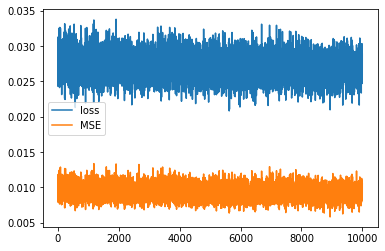

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


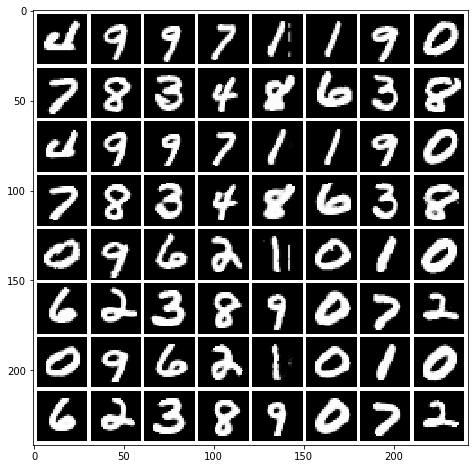

Mean squared dist: 0.009782025
epoch: 22 	 step:0 	 loss: 0.02978 	 reg loss: 0.001541
epoch: 22 	 step:100 	 loss: 0.02546 	 reg loss: 0.001527
epoch: 22 	 step:200 	 loss: 0.02771 	 reg loss: 0.001552
epoch: 22 	 step:300 	 loss: 0.02579 	 reg loss: 0.001535
epoch: 22 	 step:400 	 loss: 0.02761 	 reg loss: 0.001571
epoch: 22 	 step:500 	 loss: 0.02339 	 reg loss: 0.001523
epoch: 22 	 step:600 	 loss: 0.02846 	 reg loss: 0.001573
epoch: 22 	 step:700 	 loss: 0.02638 	 reg loss: 0.001519
epoch: 22 	 step:800 	 loss: 0.02698 	 reg loss: 0.001575
epoch: 22 	 step:900 	 loss: 0.02707 	 reg loss: 0.001589
epoch: 22 	 step:1000 	 loss: 0.02556 	 reg loss: 0.001563
epoch: 22 	 step:1100 	 loss: 0.02369 	 reg loss: 0.001429
epoch: 22 	 step:1200 	 loss: 0.0251 	 reg loss: 0.001535
epoch: 22 	 step:1300 	 loss: 0.02639 	 reg loss: 0.001608
epoch: 22 	 step:1400 	 loss: 0.02567 	 reg loss: 0.0015
epoch: 22 	 step:1500 	 loss: 0.02747 	 reg loss: 0.001555
epoch: 22 	 step:1600 	 loss: 0.02624 	 

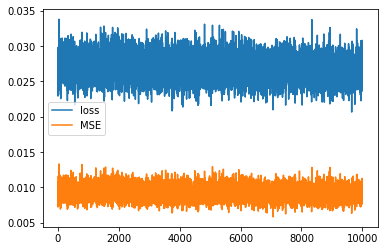

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


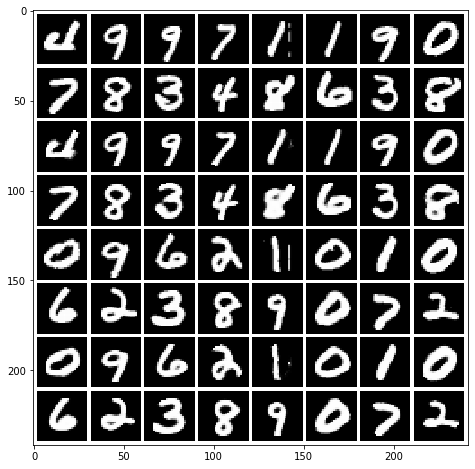

Mean squared dist: 0.009561498
epoch: 23 	 step:0 	 loss: 0.02488 	 reg loss: 0.001479
epoch: 23 	 step:100 	 loss: 0.02644 	 reg loss: 0.001508
epoch: 23 	 step:200 	 loss: 0.02387 	 reg loss: 0.001514
epoch: 23 	 step:300 	 loss: 0.02841 	 reg loss: 0.001626
epoch: 23 	 step:400 	 loss: 0.02535 	 reg loss: 0.001466
epoch: 23 	 step:500 	 loss: 0.02836 	 reg loss: 0.001543
epoch: 23 	 step:600 	 loss: 0.02674 	 reg loss: 0.001482
epoch: 23 	 step:700 	 loss: 0.02481 	 reg loss: 0.001458
epoch: 23 	 step:800 	 loss: 0.02904 	 reg loss: 0.001555
epoch: 23 	 step:900 	 loss: 0.02933 	 reg loss: 0.001531
epoch: 23 	 step:1000 	 loss: 0.02557 	 reg loss: 0.001514
epoch: 23 	 step:1100 	 loss: 0.02459 	 reg loss: 0.001511
epoch: 23 	 step:1200 	 loss: 0.0245 	 reg loss: 0.001565
epoch: 23 	 step:1300 	 loss: 0.02878 	 reg loss: 0.001512
epoch: 23 	 step:1400 	 loss: 0.02559 	 reg loss: 0.0015
epoch: 23 	 step:1500 	 loss: 0.0245 	 reg loss: 0.001465
epoch: 23 	 step:1600 	 loss: 0.02437 	 r

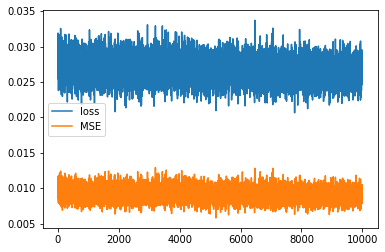

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


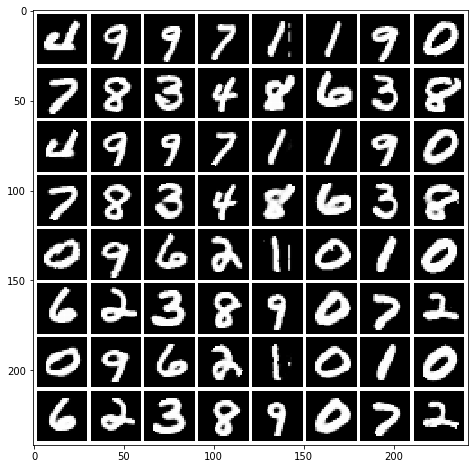

Mean squared dist: 0.0097273225
epoch: 24 	 step:0 	 loss: 0.02329 	 reg loss: 0.001441
epoch: 24 	 step:100 	 loss: 0.02646 	 reg loss: 0.001489
epoch: 24 	 step:200 	 loss: 0.02769 	 reg loss: 0.001531
epoch: 24 	 step:300 	 loss: 0.02492 	 reg loss: 0.001507
epoch: 24 	 step:400 	 loss: 0.02496 	 reg loss: 0.001514
epoch: 24 	 step:500 	 loss: 0.02553 	 reg loss: 0.001521
epoch: 24 	 step:600 	 loss: 0.03063 	 reg loss: 0.001646
epoch: 24 	 step:700 	 loss: 0.02508 	 reg loss: 0.001468
epoch: 24 	 step:800 	 loss: 0.02542 	 reg loss: 0.001521
epoch: 24 	 step:900 	 loss: 0.02669 	 reg loss: 0.001517
epoch: 24 	 step:1000 	 loss: 0.0253 	 reg loss: 0.001424
epoch: 24 	 step:1100 	 loss: 0.02664 	 reg loss: 0.001571
epoch: 24 	 step:1200 	 loss: 0.02857 	 reg loss: 0.001504
epoch: 24 	 step:1300 	 loss: 0.02442 	 reg loss: 0.001466
epoch: 24 	 step:1400 	 loss: 0.02873 	 reg loss: 0.001578
epoch: 24 	 step:1500 	 loss: 0.02629 	 reg loss: 0.001462
epoch: 24 	 step:1600 	 loss: 0.02761

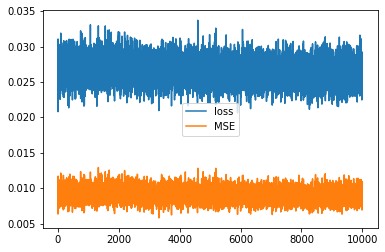

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


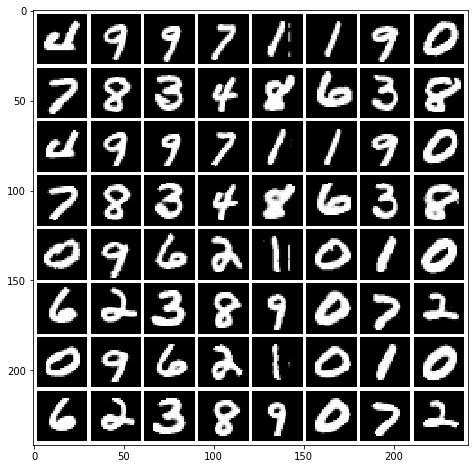

Mean squared dist: 0.0095387185
epoch: 25 	 step:0 	 loss: 0.02776 	 reg loss: 0.001581
epoch: 25 	 step:100 	 loss: 0.02886 	 reg loss: 0.00159
epoch: 25 	 step:200 	 loss: 0.02831 	 reg loss: 0.001616
epoch: 25 	 step:300 	 loss: 0.02599 	 reg loss: 0.001477
epoch: 25 	 step:400 	 loss: 0.02814 	 reg loss: 0.001553
epoch: 25 	 step:500 	 loss: 0.02661 	 reg loss: 0.00149
epoch: 25 	 step:600 	 loss: 0.02703 	 reg loss: 0.001531
epoch: 25 	 step:700 	 loss: 0.02923 	 reg loss: 0.00157
epoch: 25 	 step:800 	 loss: 0.02562 	 reg loss: 0.001521
epoch: 25 	 step:900 	 loss: 0.02593 	 reg loss: 0.001514
epoch: 25 	 step:1000 	 loss: 0.02677 	 reg loss: 0.001439
epoch: 25 	 step:1100 	 loss: 0.02463 	 reg loss: 0.001449
epoch: 25 	 step:1200 	 loss: 0.02475 	 reg loss: 0.001435
epoch: 25 	 step:1300 	 loss: 0.02875 	 reg loss: 0.001485
epoch: 25 	 step:1400 	 loss: 0.0248 	 reg loss: 0.001486
epoch: 25 	 step:1500 	 loss: 0.02642 	 reg loss: 0.001418
epoch: 25 	 step:1600 	 loss: 0.02671 	 

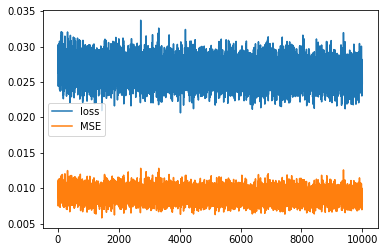

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


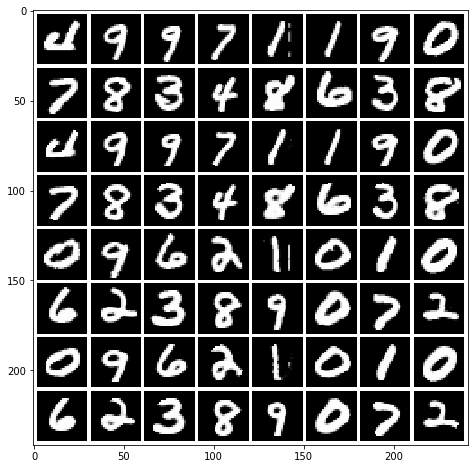

Mean squared dist: 0.009485344
epoch: 26 	 step:0 	 loss: 0.02321 	 reg loss: 0.001455
epoch: 26 	 step:100 	 loss: 0.02722 	 reg loss: 0.00154
epoch: 26 	 step:200 	 loss: 0.02481 	 reg loss: 0.001443
epoch: 26 	 step:300 	 loss: 0.02776 	 reg loss: 0.001498
epoch: 26 	 step:400 	 loss: 0.02606 	 reg loss: 0.001465
epoch: 26 	 step:500 	 loss: 0.02893 	 reg loss: 0.001498
epoch: 26 	 step:600 	 loss: 0.02405 	 reg loss: 0.001497
epoch: 26 	 step:700 	 loss: 0.02738 	 reg loss: 0.001496
epoch: 26 	 step:800 	 loss: 0.02909 	 reg loss: 0.001594
epoch: 26 	 step:900 	 loss: 0.02692 	 reg loss: 0.001521
epoch: 26 	 step:1000 	 loss: 0.0255 	 reg loss: 0.001507
epoch: 26 	 step:1100 	 loss: 0.02473 	 reg loss: 0.001536
epoch: 26 	 step:1200 	 loss: 0.02553 	 reg loss: 0.00142
epoch: 26 	 step:1300 	 loss: 0.02839 	 reg loss: 0.001491
epoch: 26 	 step:1400 	 loss: 0.02402 	 reg loss: 0.001451
epoch: 26 	 step:1500 	 loss: 0.02827 	 reg loss: 0.001484
epoch: 26 	 step:1600 	 loss: 0.03057 	 

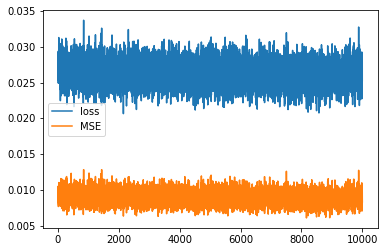

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


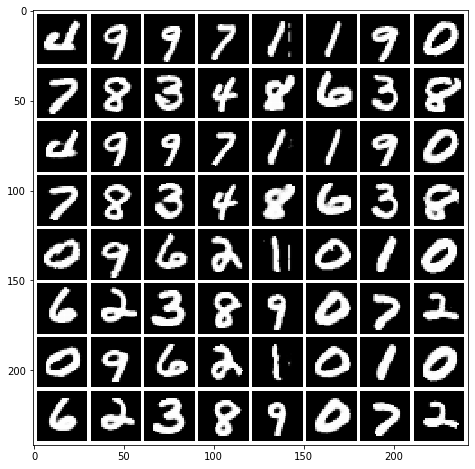

Mean squared dist: 0.009373379
epoch: 27 	 step:0 	 loss: 0.02748 	 reg loss: 0.001497
epoch: 27 	 step:100 	 loss: 0.0286 	 reg loss: 0.001538
epoch: 27 	 step:200 	 loss: 0.02353 	 reg loss: 0.001431
epoch: 27 	 step:300 	 loss: 0.02631 	 reg loss: 0.001444
epoch: 27 	 step:400 	 loss: 0.02487 	 reg loss: 0.0015
epoch: 27 	 step:500 	 loss: 0.02716 	 reg loss: 0.001524
epoch: 27 	 step:600 	 loss: 0.02502 	 reg loss: 0.00144
epoch: 27 	 step:700 	 loss: 0.02685 	 reg loss: 0.00146
epoch: 27 	 step:800 	 loss: 0.02388 	 reg loss: 0.001466
epoch: 27 	 step:900 	 loss: 0.02519 	 reg loss: 0.001488
epoch: 27 	 step:1000 	 loss: 0.02456 	 reg loss: 0.001443
epoch: 27 	 step:1100 	 loss: 0.02484 	 reg loss: 0.001459
epoch: 27 	 step:1200 	 loss: 0.02597 	 reg loss: 0.001467
epoch: 27 	 step:1300 	 loss: 0.02339 	 reg loss: 0.001464
epoch: 27 	 step:1400 	 loss: 0.02697 	 reg loss: 0.001493
epoch: 27 	 step:1500 	 loss: 0.02594 	 reg loss: 0.001479
epoch: 27 	 step:1600 	 loss: 0.0237 	 reg

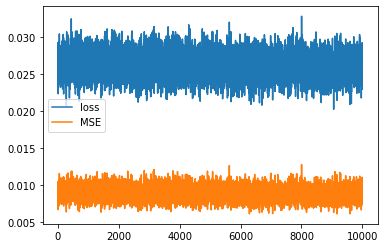

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


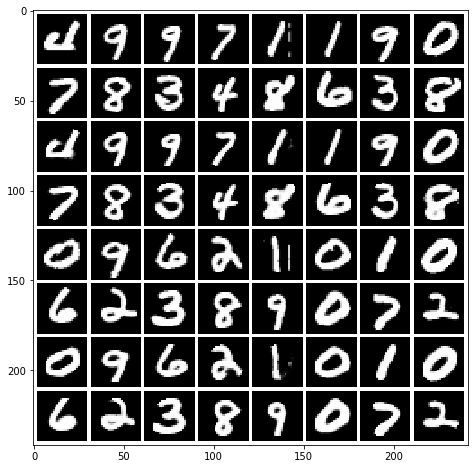

Mean squared dist: 0.009260759
epoch: 28 	 step:0 	 loss: 0.02481 	 reg loss: 0.001419
epoch: 28 	 step:100 	 loss: 0.02678 	 reg loss: 0.001463
epoch: 28 	 step:200 	 loss: 0.02605 	 reg loss: 0.001484
epoch: 28 	 step:300 	 loss: 0.02378 	 reg loss: 0.001478
epoch: 28 	 step:400 	 loss: 0.02479 	 reg loss: 0.001477
epoch: 28 	 step:500 	 loss: 0.02591 	 reg loss: 0.001514
epoch: 28 	 step:600 	 loss: 0.02703 	 reg loss: 0.001499
epoch: 28 	 step:700 	 loss: 0.02469 	 reg loss: 0.001397
epoch: 28 	 step:800 	 loss: 0.02601 	 reg loss: 0.001459
epoch: 28 	 step:900 	 loss: 0.02423 	 reg loss: 0.001466
epoch: 28 	 step:1000 	 loss: 0.02487 	 reg loss: 0.001488
epoch: 28 	 step:1100 	 loss: 0.02389 	 reg loss: 0.001481
epoch: 28 	 step:1200 	 loss: 0.02805 	 reg loss: 0.001529
epoch: 28 	 step:1300 	 loss: 0.02485 	 reg loss: 0.001408
epoch: 28 	 step:1400 	 loss: 0.02493 	 reg loss: 0.001469
epoch: 28 	 step:1500 	 loss: 0.02816 	 reg loss: 0.001538
epoch: 28 	 step:1600 	 loss: 0.02557

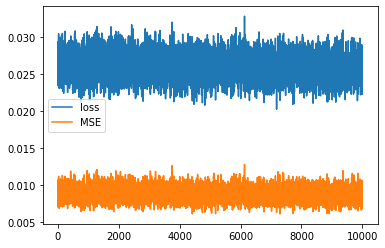

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


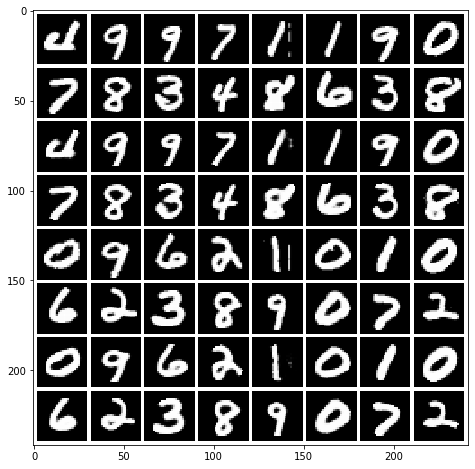

Mean squared dist: 0.009422463
epoch: 29 	 step:0 	 loss: 0.02451 	 reg loss: 0.001451
epoch: 29 	 step:100 	 loss: 0.02805 	 reg loss: 0.001475
epoch: 29 	 step:200 	 loss: 0.02736 	 reg loss: 0.001516
epoch: 29 	 step:300 	 loss: 0.02281 	 reg loss: 0.001412
epoch: 29 	 step:400 	 loss: 0.02578 	 reg loss: 0.001485
epoch: 29 	 step:500 	 loss: 0.02314 	 reg loss: 0.001438
epoch: 29 	 step:600 	 loss: 0.02705 	 reg loss: 0.001503
epoch: 29 	 step:700 	 loss: 0.02595 	 reg loss: 0.001498
epoch: 29 	 step:800 	 loss: 0.02739 	 reg loss: 0.001418
epoch: 29 	 step:900 	 loss: 0.0269 	 reg loss: 0.001434
epoch: 29 	 step:1000 	 loss: 0.02782 	 reg loss: 0.001483
epoch: 29 	 step:1100 	 loss: 0.02585 	 reg loss: 0.001463
epoch: 29 	 step:1200 	 loss: 0.0262 	 reg loss: 0.001462
epoch: 29 	 step:1300 	 loss: 0.02472 	 reg loss: 0.001456
epoch: 29 	 step:1400 	 loss: 0.02485 	 reg loss: 0.001466
epoch: 29 	 step:1500 	 loss: 0.02706 	 reg loss: 0.001468
epoch: 29 	 step:1600 	 loss: 0.02324 	

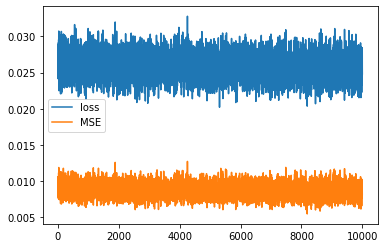

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


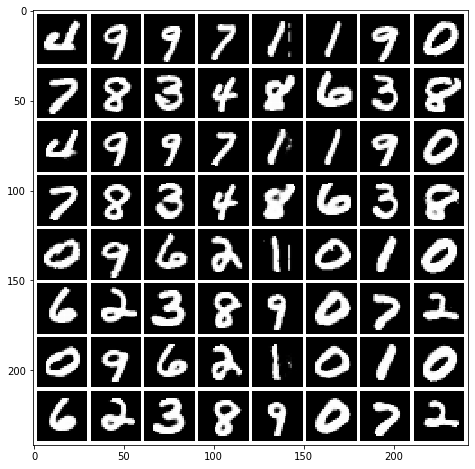

Mean squared dist: 0.009469964
epoch: 30 	 step:0 	 loss: 0.02362 	 reg loss: 0.001464
epoch: 30 	 step:100 	 loss: 0.02368 	 reg loss: 0.001423
epoch: 30 	 step:200 	 loss: 0.02294 	 reg loss: 0.001429
epoch: 30 	 step:300 	 loss: 0.0277 	 reg loss: 0.001446
epoch: 30 	 step:400 	 loss: 0.02594 	 reg loss: 0.001443
epoch: 30 	 step:500 	 loss: 0.02541 	 reg loss: 0.001414
epoch: 30 	 step:600 	 loss: 0.02394 	 reg loss: 0.00147
epoch: 30 	 step:700 	 loss: 0.02503 	 reg loss: 0.001468
epoch: 30 	 step:800 	 loss: 0.02827 	 reg loss: 0.001546
epoch: 30 	 step:900 	 loss: 0.0239 	 reg loss: 0.001469
epoch: 30 	 step:1000 	 loss: 0.0246 	 reg loss: 0.001502
epoch: 30 	 step:1100 	 loss: 0.02259 	 reg loss: 0.001443
epoch: 30 	 step:1200 	 loss: 0.02656 	 reg loss: 0.00142
epoch: 30 	 step:1300 	 loss: 0.02696 	 reg loss: 0.001506
epoch: 30 	 step:1400 	 loss: 0.0274 	 reg loss: 0.001469
epoch: 30 	 step:1500 	 loss: 0.02712 	 reg loss: 0.001443
epoch: 30 	 step:1600 	 loss: 0.02438 	 reg

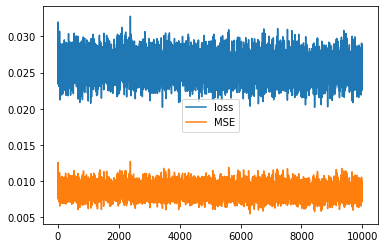

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


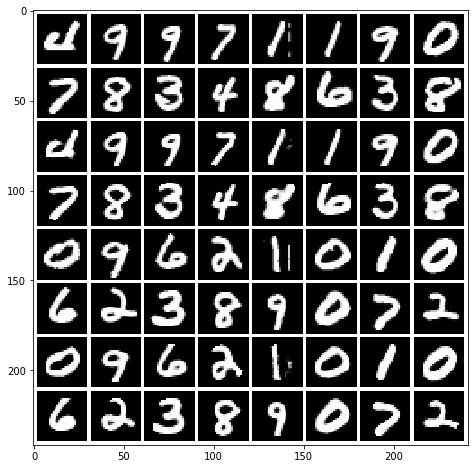

Mean squared dist: 0.009272338
epoch: 31 	 step:0 	 loss: 0.0258 	 reg loss: 0.001405
epoch: 31 	 step:100 	 loss: 0.02593 	 reg loss: 0.001447
epoch: 31 	 step:200 	 loss: 0.02747 	 reg loss: 0.001488
epoch: 31 	 step:300 	 loss: 0.02506 	 reg loss: 0.001449
epoch: 31 	 step:400 	 loss: 0.02664 	 reg loss: 0.001484
epoch: 31 	 step:500 	 loss: 0.02836 	 reg loss: 0.001538
epoch: 31 	 step:600 	 loss: 0.02724 	 reg loss: 0.001406
epoch: 31 	 step:700 	 loss: 0.02611 	 reg loss: 0.001473
epoch: 31 	 step:800 	 loss: 0.02875 	 reg loss: 0.001502
epoch: 31 	 step:900 	 loss: 0.02413 	 reg loss: 0.001443
epoch: 31 	 step:1000 	 loss: 0.02402 	 reg loss: 0.00141
epoch: 31 	 step:1100 	 loss: 0.02398 	 reg loss: 0.001411
epoch: 31 	 step:1200 	 loss: 0.02529 	 reg loss: 0.001462
epoch: 31 	 step:1300 	 loss: 0.02443 	 reg loss: 0.001421
epoch: 31 	 step:1400 	 loss: 0.0235 	 reg loss: 0.001391
epoch: 31 	 step:1500 	 loss: 0.02728 	 reg loss: 0.001383
epoch: 31 	 step:1600 	 loss: 0.02437 	 

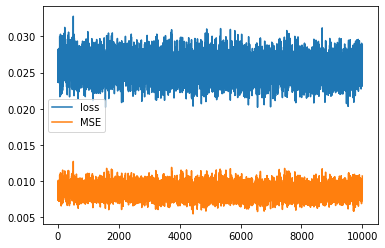

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


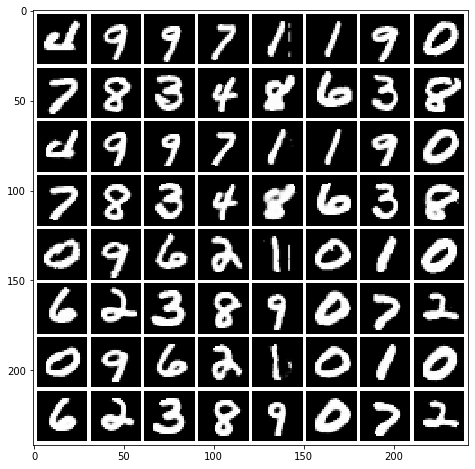

Mean squared dist: 0.009221588
epoch: 32 	 step:0 	 loss: 0.02476 	 reg loss: 0.001464
epoch: 32 	 step:100 	 loss: 0.02519 	 reg loss: 0.001466
epoch: 32 	 step:200 	 loss: 0.02664 	 reg loss: 0.001516
epoch: 32 	 step:300 	 loss: 0.0273 	 reg loss: 0.001513
epoch: 32 	 step:400 	 loss: 0.02526 	 reg loss: 0.001405
epoch: 32 	 step:500 	 loss: 0.02586 	 reg loss: 0.001409
epoch: 32 	 step:600 	 loss: 0.0253 	 reg loss: 0.001409
epoch: 32 	 step:700 	 loss: 0.0242 	 reg loss: 0.001421
epoch: 32 	 step:800 	 loss: 0.0245 	 reg loss: 0.00141
epoch: 32 	 step:900 	 loss: 0.02225 	 reg loss: 0.001494
epoch: 32 	 step:1000 	 loss: 0.02568 	 reg loss: 0.001454
epoch: 32 	 step:1100 	 loss: 0.02602 	 reg loss: 0.001421
epoch: 32 	 step:1200 	 loss: 0.02731 	 reg loss: 0.001462
epoch: 32 	 step:1300 	 loss: 0.02473 	 reg loss: 0.001424
epoch: 32 	 step:1400 	 loss: 0.02849 	 reg loss: 0.00152
epoch: 32 	 step:1500 	 loss: 0.02641 	 reg loss: 0.001513
epoch: 32 	 step:1600 	 loss: 0.02379 	 reg

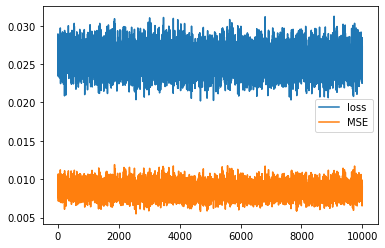

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


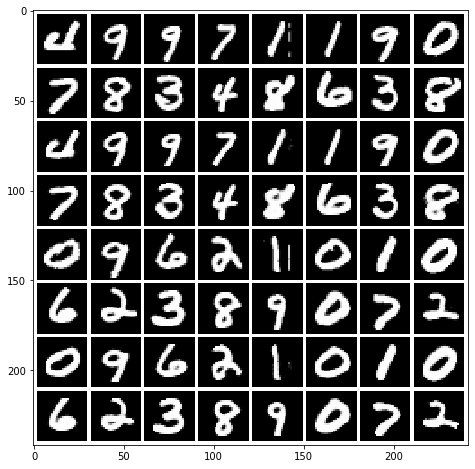

Mean squared dist: 0.009260667
epoch: 33 	 step:0 	 loss: 0.02521 	 reg loss: 0.001475
epoch: 33 	 step:100 	 loss: 0.02323 	 reg loss: 0.001438
epoch: 33 	 step:200 	 loss: 0.02489 	 reg loss: 0.001457
epoch: 33 	 step:300 	 loss: 0.02494 	 reg loss: 0.001442
epoch: 33 	 step:400 	 loss: 0.02512 	 reg loss: 0.001456
epoch: 33 	 step:500 	 loss: 0.02405 	 reg loss: 0.001413
epoch: 33 	 step:600 	 loss: 0.02385 	 reg loss: 0.001422
epoch: 33 	 step:700 	 loss: 0.02476 	 reg loss: 0.001475
epoch: 33 	 step:800 	 loss: 0.0241 	 reg loss: 0.001395
epoch: 33 	 step:900 	 loss: 0.02539 	 reg loss: 0.001493
epoch: 33 	 step:1000 	 loss: 0.02446 	 reg loss: 0.001434
epoch: 33 	 step:1100 	 loss: 0.03022 	 reg loss: 0.001476
epoch: 33 	 step:1200 	 loss: 0.02721 	 reg loss: 0.001457
epoch: 33 	 step:1300 	 loss: 0.02481 	 reg loss: 0.001372
epoch: 33 	 step:1400 	 loss: 0.02617 	 reg loss: 0.001473
epoch: 33 	 step:1500 	 loss: 0.02662 	 reg loss: 0.001395
epoch: 33 	 step:1600 	 loss: 0.02593 

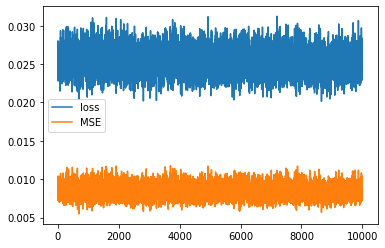

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


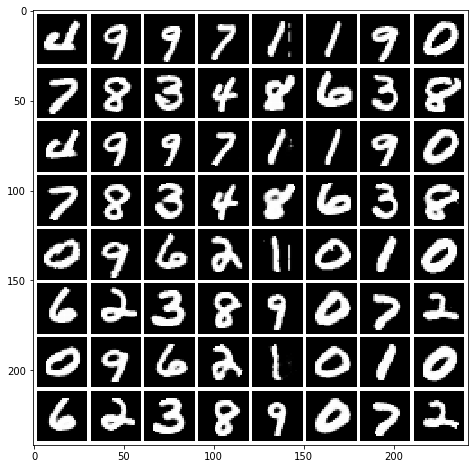

Mean squared dist: 0.009119166
epoch: 34 	 step:0 	 loss: 0.02497 	 reg loss: 0.001476
epoch: 34 	 step:100 	 loss: 0.02535 	 reg loss: 0.001479
epoch: 34 	 step:200 	 loss: 0.02552 	 reg loss: 0.001387
epoch: 34 	 step:300 	 loss: 0.02374 	 reg loss: 0.001435
epoch: 34 	 step:400 	 loss: 0.02375 	 reg loss: 0.001415
epoch: 34 	 step:500 	 loss: 0.02635 	 reg loss: 0.001461
epoch: 34 	 step:600 	 loss: 0.02546 	 reg loss: 0.001442
epoch: 34 	 step:700 	 loss: 0.02467 	 reg loss: 0.001449
epoch: 34 	 step:800 	 loss: 0.02392 	 reg loss: 0.001417
epoch: 34 	 step:900 	 loss: 0.02566 	 reg loss: 0.001458
epoch: 34 	 step:1000 	 loss: 0.0252 	 reg loss: 0.001471
epoch: 34 	 step:1100 	 loss: 0.0258 	 reg loss: 0.00143
epoch: 34 	 step:1200 	 loss: 0.02355 	 reg loss: 0.001385
epoch: 34 	 step:1300 	 loss: 0.02273 	 reg loss: 0.001416
epoch: 34 	 step:1400 	 loss: 0.02553 	 reg loss: 0.001442
epoch: 34 	 step:1500 	 loss: 0.02568 	 reg loss: 0.001464
epoch: 34 	 step:1600 	 loss: 0.02647 	 

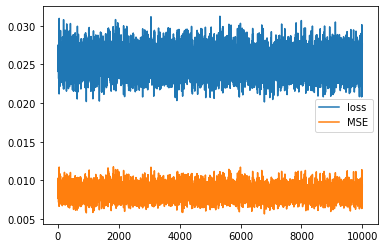

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


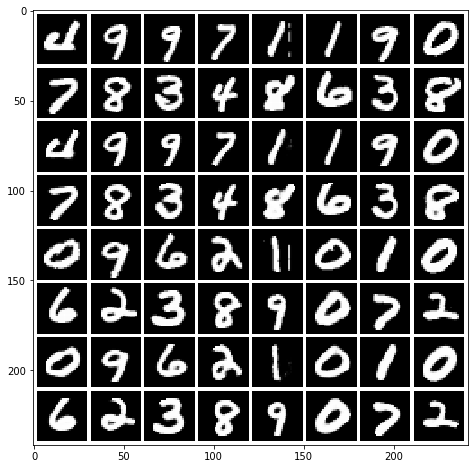

Mean squared dist: 0.009176261
epoch: 35 	 step:0 	 loss: 0.02422 	 reg loss: 0.001418
epoch: 35 	 step:100 	 loss: 0.02742 	 reg loss: 0.001475
epoch: 35 	 step:200 	 loss: 0.026 	 reg loss: 0.00143
epoch: 35 	 step:300 	 loss: 0.02629 	 reg loss: 0.001412
epoch: 35 	 step:400 	 loss: 0.02599 	 reg loss: 0.001427
epoch: 35 	 step:500 	 loss: 0.02529 	 reg loss: 0.001428
epoch: 35 	 step:600 	 loss: 0.02415 	 reg loss: 0.001449
epoch: 35 	 step:700 	 loss: 0.02691 	 reg loss: 0.001441
epoch: 35 	 step:800 	 loss: 0.02354 	 reg loss: 0.001413
epoch: 35 	 step:900 	 loss: 0.0238 	 reg loss: 0.001402
epoch: 35 	 step:1000 	 loss: 0.02609 	 reg loss: 0.001419
epoch: 35 	 step:1100 	 loss: 0.02363 	 reg loss: 0.001408
epoch: 35 	 step:1200 	 loss: 0.02417 	 reg loss: 0.001427
epoch: 35 	 step:1300 	 loss: 0.02643 	 reg loss: 0.001412
epoch: 35 	 step:1400 	 loss: 0.02439 	 reg loss: 0.00138
epoch: 35 	 step:1500 	 loss: 0.02302 	 reg loss: 0.001417
epoch: 35 	 step:1600 	 loss: 0.02768 	 re

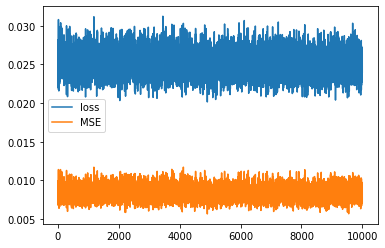

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


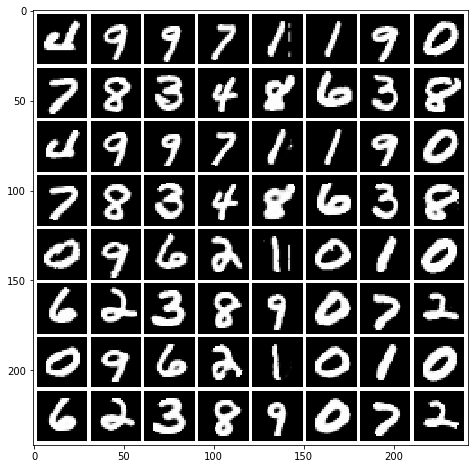

Mean squared dist: 0.009023563
epoch: 36 	 step:0 	 loss: 0.02344 	 reg loss: 0.00137
epoch: 36 	 step:100 	 loss: 0.02333 	 reg loss: 0.001438
epoch: 36 	 step:200 	 loss: 0.02425 	 reg loss: 0.001392
epoch: 36 	 step:300 	 loss: 0.02589 	 reg loss: 0.001457
epoch: 36 	 step:400 	 loss: 0.02424 	 reg loss: 0.001395
epoch: 36 	 step:500 	 loss: 0.02595 	 reg loss: 0.001389
epoch: 36 	 step:600 	 loss: 0.02777 	 reg loss: 0.001467
epoch: 36 	 step:700 	 loss: 0.02483 	 reg loss: 0.001323
epoch: 36 	 step:800 	 loss: 0.02413 	 reg loss: 0.001432
epoch: 36 	 step:900 	 loss: 0.02533 	 reg loss: 0.001436
epoch: 36 	 step:1000 	 loss: 0.02748 	 reg loss: 0.001475
epoch: 36 	 step:1100 	 loss: 0.02429 	 reg loss: 0.001418
epoch: 36 	 step:1200 	 loss: 0.02156 	 reg loss: 0.001373
epoch: 36 	 step:1300 	 loss: 0.02467 	 reg loss: 0.001415
epoch: 36 	 step:1400 	 loss: 0.02573 	 reg loss: 0.00148
epoch: 36 	 step:1500 	 loss: 0.02535 	 reg loss: 0.001387
epoch: 36 	 step:1600 	 loss: 0.02396 	

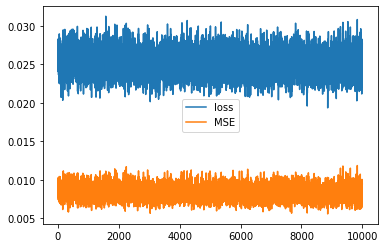

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


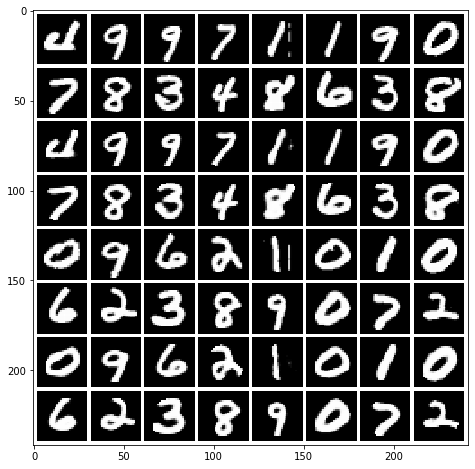

Mean squared dist: 0.008910348
epoch: 37 	 step:0 	 loss: 0.02461 	 reg loss: 0.001457
epoch: 37 	 step:100 	 loss: 0.02511 	 reg loss: 0.001428
epoch: 37 	 step:200 	 loss: 0.02639 	 reg loss: 0.001423
epoch: 37 	 step:300 	 loss: 0.02375 	 reg loss: 0.001427
epoch: 37 	 step:400 	 loss: 0.02867 	 reg loss: 0.001413
epoch: 37 	 step:500 	 loss: 0.02493 	 reg loss: 0.001443
epoch: 37 	 step:600 	 loss: 0.02225 	 reg loss: 0.001385
epoch: 37 	 step:700 	 loss: 0.02122 	 reg loss: 0.00137
epoch: 37 	 step:800 	 loss: 0.02295 	 reg loss: 0.001326
epoch: 37 	 step:900 	 loss: 0.02566 	 reg loss: 0.001411
epoch: 37 	 step:1000 	 loss: 0.02549 	 reg loss: 0.001374
epoch: 37 	 step:1100 	 loss: 0.02617 	 reg loss: 0.001426
epoch: 37 	 step:1200 	 loss: 0.0234 	 reg loss: 0.001394
epoch: 37 	 step:1300 	 loss: 0.02489 	 reg loss: 0.001403
epoch: 37 	 step:1400 	 loss: 0.02211 	 reg loss: 0.001309
epoch: 37 	 step:1500 	 loss: 0.02388 	 reg loss: 0.001407
epoch: 37 	 step:1600 	 loss: 0.02332 	

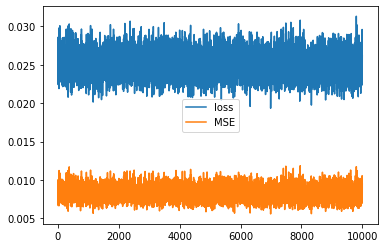

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


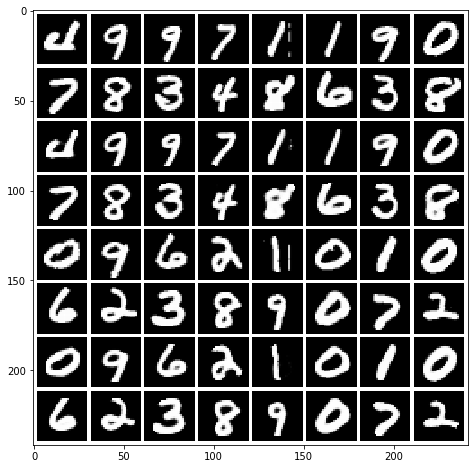

Mean squared dist: 0.00899459
epoch: 38 	 step:0 	 loss: 0.02417 	 reg loss: 0.001426
epoch: 38 	 step:100 	 loss: 0.02555 	 reg loss: 0.001383
epoch: 38 	 step:200 	 loss: 0.02395 	 reg loss: 0.001422
epoch: 38 	 step:300 	 loss: 0.02321 	 reg loss: 0.001391
epoch: 38 	 step:400 	 loss: 0.02532 	 reg loss: 0.001481
epoch: 38 	 step:500 	 loss: 0.02339 	 reg loss: 0.001443
epoch: 38 	 step:600 	 loss: 0.02273 	 reg loss: 0.001391
epoch: 38 	 step:700 	 loss: 0.02231 	 reg loss: 0.001385
epoch: 38 	 step:800 	 loss: 0.02676 	 reg loss: 0.001418
epoch: 38 	 step:900 	 loss: 0.02518 	 reg loss: 0.00136
epoch: 38 	 step:1000 	 loss: 0.02454 	 reg loss: 0.001392
epoch: 38 	 step:1100 	 loss: 0.02524 	 reg loss: 0.001413
epoch: 38 	 step:1200 	 loss: 0.02418 	 reg loss: 0.001417
epoch: 38 	 step:1300 	 loss: 0.02587 	 reg loss: 0.001409
epoch: 38 	 step:1400 	 loss: 0.02724 	 reg loss: 0.001402
epoch: 38 	 step:1500 	 loss: 0.02698 	 reg loss: 0.001442
epoch: 38 	 step:1600 	 loss: 0.0229 	 

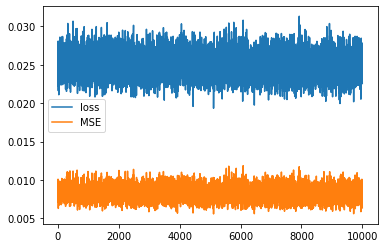

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


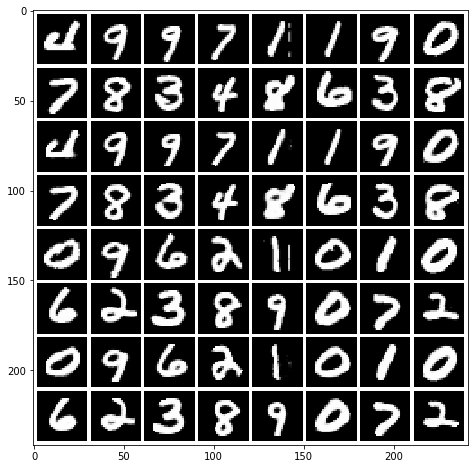

Mean squared dist: 0.008844453
epoch: 39 	 step:0 	 loss: 0.02284 	 reg loss: 0.001388
epoch: 39 	 step:100 	 loss: 0.02554 	 reg loss: 0.0014
epoch: 39 	 step:200 	 loss: 0.02336 	 reg loss: 0.001325
epoch: 39 	 step:300 	 loss: 0.02348 	 reg loss: 0.001386
epoch: 39 	 step:400 	 loss: 0.02624 	 reg loss: 0.001418
epoch: 39 	 step:500 	 loss: 0.02769 	 reg loss: 0.001454
epoch: 39 	 step:600 	 loss: 0.02304 	 reg loss: 0.001395
epoch: 39 	 step:700 	 loss: 0.02475 	 reg loss: 0.001345
epoch: 39 	 step:800 	 loss: 0.02439 	 reg loss: 0.001421
epoch: 39 	 step:900 	 loss: 0.02188 	 reg loss: 0.001345
epoch: 39 	 step:1000 	 loss: 0.02285 	 reg loss: 0.001453
epoch: 39 	 step:1100 	 loss: 0.02453 	 reg loss: 0.001405
epoch: 39 	 step:1200 	 loss: 0.02472 	 reg loss: 0.001406
epoch: 39 	 step:1300 	 loss: 0.02239 	 reg loss: 0.00135
epoch: 39 	 step:1400 	 loss: 0.02576 	 reg loss: 0.001443
epoch: 39 	 step:1500 	 loss: 0.02521 	 reg loss: 0.001447
epoch: 39 	 step:1600 	 loss: 0.02634 	 

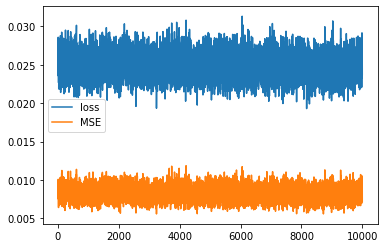

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


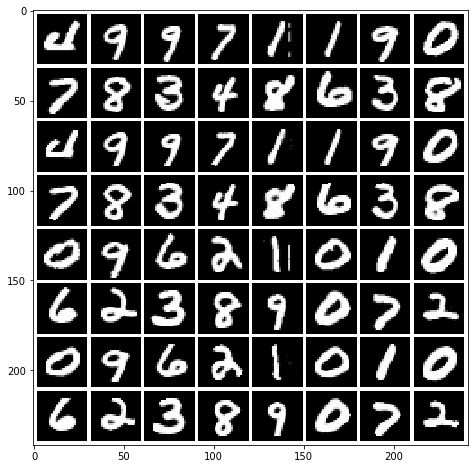

Mean squared dist: 0.008779358
epoch: 40 	 step:0 	 loss: 0.02652 	 reg loss: 0.001482
epoch: 40 	 step:100 	 loss: 0.02535 	 reg loss: 0.001459
epoch: 40 	 step:200 	 loss: 0.02548 	 reg loss: 0.001403
epoch: 40 	 step:300 	 loss: 0.02518 	 reg loss: 0.001385
epoch: 40 	 step:400 	 loss: 0.02084 	 reg loss: 0.001371
epoch: 40 	 step:500 	 loss: 0.02317 	 reg loss: 0.001429
epoch: 40 	 step:600 	 loss: 0.02501 	 reg loss: 0.001378
epoch: 40 	 step:700 	 loss: 0.02309 	 reg loss: 0.001357
epoch: 40 	 step:800 	 loss: 0.02419 	 reg loss: 0.001419
epoch: 40 	 step:900 	 loss: 0.02347 	 reg loss: 0.001451
epoch: 40 	 step:1000 	 loss: 0.02632 	 reg loss: 0.001376
epoch: 40 	 step:1100 	 loss: 0.02529 	 reg loss: 0.001388
epoch: 40 	 step:1200 	 loss: 0.025 	 reg loss: 0.001463
epoch: 40 	 step:1300 	 loss: 0.02395 	 reg loss: 0.001374
epoch: 40 	 step:1400 	 loss: 0.02394 	 reg loss: 0.001371
epoch: 40 	 step:1500 	 loss: 0.02548 	 reg loss: 0.001386
epoch: 40 	 step:1600 	 loss: 0.02675 	

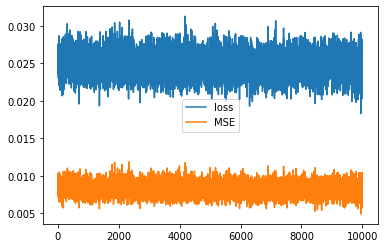

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


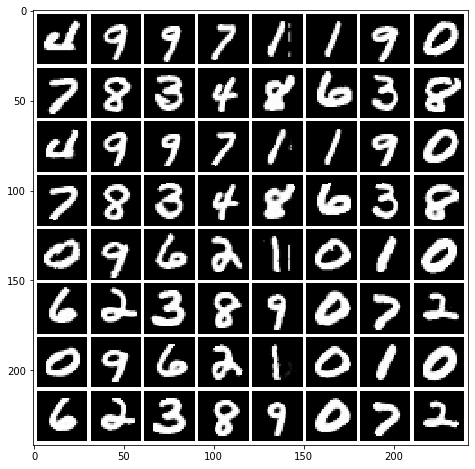

Mean squared dist: 0.008773136
epoch: 41 	 step:0 	 loss: 0.02484 	 reg loss: 0.001416
epoch: 41 	 step:100 	 loss: 0.0265 	 reg loss: 0.001442
epoch: 41 	 step:200 	 loss: 0.0252 	 reg loss: 0.001502
epoch: 41 	 step:300 	 loss: 0.02711 	 reg loss: 0.001395
epoch: 41 	 step:400 	 loss: 0.02217 	 reg loss: 0.001375
epoch: 41 	 step:500 	 loss: 0.02524 	 reg loss: 0.001397
epoch: 41 	 step:600 	 loss: 0.02526 	 reg loss: 0.001313
epoch: 41 	 step:700 	 loss: 0.0257 	 reg loss: 0.001457
epoch: 41 	 step:800 	 loss: 0.02535 	 reg loss: 0.001405
epoch: 41 	 step:900 	 loss: 0.02381 	 reg loss: 0.001381
epoch: 41 	 step:1000 	 loss: 0.02276 	 reg loss: 0.001355
epoch: 41 	 step:1100 	 loss: 0.02561 	 reg loss: 0.001429
epoch: 41 	 step:1200 	 loss: 0.02308 	 reg loss: 0.001391
epoch: 41 	 step:1300 	 loss: 0.02645 	 reg loss: 0.001405
epoch: 41 	 step:1400 	 loss: 0.02262 	 reg loss: 0.001364
epoch: 41 	 step:1500 	 loss: 0.02221 	 reg loss: 0.001403
epoch: 41 	 step:1600 	 loss: 0.02591 	 

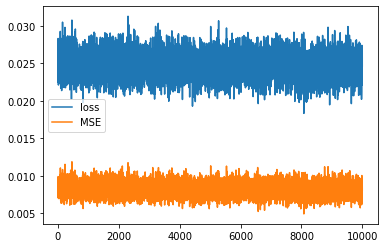

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


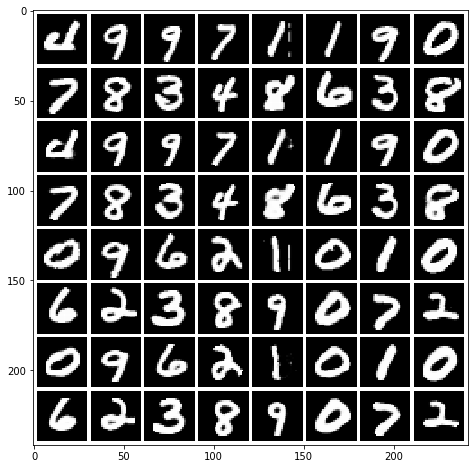

Mean squared dist: 0.008833795
epoch: 42 	 step:0 	 loss: 0.02328 	 reg loss: 0.001316
epoch: 42 	 step:100 	 loss: 0.0233 	 reg loss: 0.00136
epoch: 42 	 step:200 	 loss: 0.02382 	 reg loss: 0.001416
epoch: 42 	 step:300 	 loss: 0.02396 	 reg loss: 0.00137
epoch: 42 	 step:400 	 loss: 0.02563 	 reg loss: 0.001406
epoch: 42 	 step:500 	 loss: 0.0269 	 reg loss: 0.001388
epoch: 42 	 step:600 	 loss: 0.02649 	 reg loss: 0.001423
epoch: 42 	 step:700 	 loss: 0.02412 	 reg loss: 0.001431
epoch: 42 	 step:800 	 loss: 0.02658 	 reg loss: 0.001429
epoch: 42 	 step:900 	 loss: 0.0261 	 reg loss: 0.00139
epoch: 42 	 step:1000 	 loss: 0.02446 	 reg loss: 0.001381
epoch: 42 	 step:1100 	 loss: 0.02169 	 reg loss: 0.001285
epoch: 42 	 step:1200 	 loss: 0.02587 	 reg loss: 0.001441
epoch: 42 	 step:1300 	 loss: 0.02351 	 reg loss: 0.001396
epoch: 42 	 step:1400 	 loss: 0.02724 	 reg loss: 0.001442
epoch: 42 	 step:1500 	 loss: 0.02325 	 reg loss: 0.001386
epoch: 42 	 step:1600 	 loss: 0.02851 	 reg

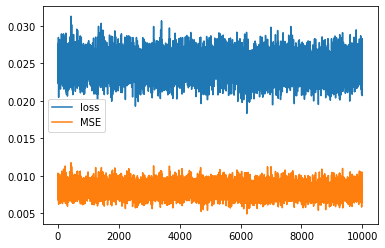

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


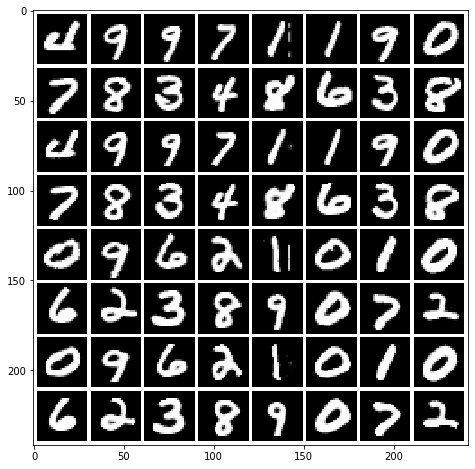

Mean squared dist: 0.008619487
epoch: 43 	 step:0 	 loss: 0.02527 	 reg loss: 0.001372
epoch: 43 	 step:100 	 loss: 0.02293 	 reg loss: 0.001313
epoch: 43 	 step:200 	 loss: 0.02559 	 reg loss: 0.001406
epoch: 43 	 step:300 	 loss: 0.02455 	 reg loss: 0.001458
epoch: 43 	 step:400 	 loss: 0.02344 	 reg loss: 0.001396
epoch: 43 	 step:500 	 loss: 0.02686 	 reg loss: 0.001457
epoch: 43 	 step:600 	 loss: 0.02386 	 reg loss: 0.001397
epoch: 43 	 step:700 	 loss: 0.02995 	 reg loss: 0.001523
epoch: 43 	 step:800 	 loss: 0.02498 	 reg loss: 0.001431
epoch: 43 	 step:900 	 loss: 0.02426 	 reg loss: 0.001394
epoch: 43 	 step:1000 	 loss: 0.0231 	 reg loss: 0.001374
epoch: 43 	 step:1100 	 loss: 0.02533 	 reg loss: 0.001377
epoch: 43 	 step:1200 	 loss: 0.0242 	 reg loss: 0.001386
epoch: 43 	 step:1300 	 loss: 0.02535 	 reg loss: 0.001372
epoch: 43 	 step:1400 	 loss: 0.02685 	 reg loss: 0.001376
epoch: 43 	 step:1500 	 loss: 0.02656 	 reg loss: 0.001397
epoch: 43 	 step:1600 	 loss: 0.02343 	

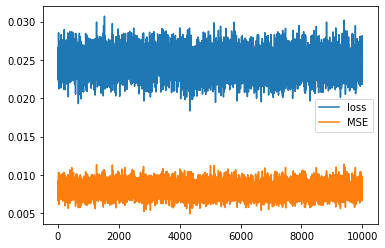

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


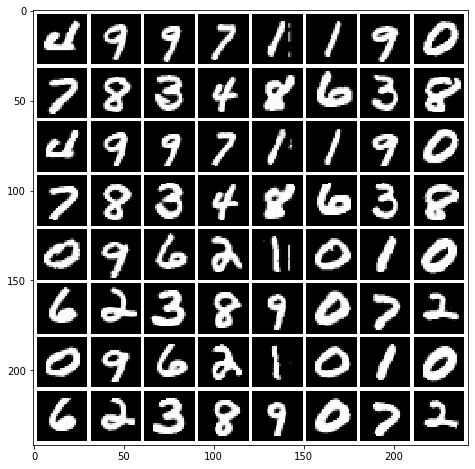

Mean squared dist: 0.008586248
epoch: 44 	 step:0 	 loss: 0.02394 	 reg loss: 0.001391
epoch: 44 	 step:100 	 loss: 0.02499 	 reg loss: 0.001432
epoch: 44 	 step:200 	 loss: 0.02272 	 reg loss: 0.001384
epoch: 44 	 step:300 	 loss: 0.02393 	 reg loss: 0.001364
epoch: 44 	 step:400 	 loss: 0.0238 	 reg loss: 0.001426
epoch: 44 	 step:500 	 loss: 0.02124 	 reg loss: 0.001329
epoch: 44 	 step:600 	 loss: 0.02419 	 reg loss: 0.001386
epoch: 44 	 step:700 	 loss: 0.02375 	 reg loss: 0.00137
epoch: 44 	 step:800 	 loss: 0.02586 	 reg loss: 0.001445
epoch: 44 	 step:900 	 loss: 0.02319 	 reg loss: 0.001381
epoch: 44 	 step:1000 	 loss: 0.02402 	 reg loss: 0.001315
epoch: 44 	 step:1100 	 loss: 0.02266 	 reg loss: 0.001347
epoch: 44 	 step:1200 	 loss: 0.02456 	 reg loss: 0.001404
epoch: 44 	 step:1300 	 loss: 0.02257 	 reg loss: 0.001296
epoch: 44 	 step:1400 	 loss: 0.02045 	 reg loss: 0.001322
epoch: 44 	 step:1500 	 loss: 0.02525 	 reg loss: 0.001333
epoch: 44 	 step:1600 	 loss: 0.02374 	

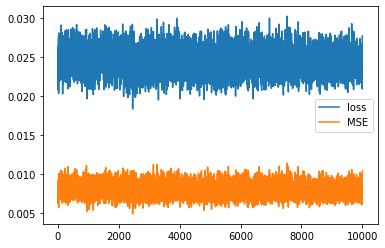

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


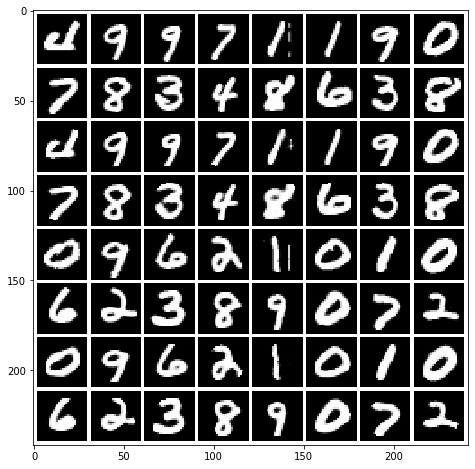

Mean squared dist: 0.008705018
epoch: 45 	 step:0 	 loss: 0.02576 	 reg loss: 0.001404
epoch: 45 	 step:100 	 loss: 0.02315 	 reg loss: 0.001437
epoch: 45 	 step:200 	 loss: 0.02282 	 reg loss: 0.001351
epoch: 45 	 step:300 	 loss: 0.02552 	 reg loss: 0.001359
epoch: 45 	 step:400 	 loss: 0.02547 	 reg loss: 0.001444
epoch: 45 	 step:500 	 loss: 0.02403 	 reg loss: 0.001396
epoch: 45 	 step:600 	 loss: 0.02605 	 reg loss: 0.00142
epoch: 45 	 step:700 	 loss: 0.02346 	 reg loss: 0.001332
epoch: 45 	 step:800 	 loss: 0.02473 	 reg loss: 0.001386
epoch: 45 	 step:900 	 loss: 0.02321 	 reg loss: 0.001426
epoch: 45 	 step:1000 	 loss: 0.02252 	 reg loss: 0.001334
epoch: 45 	 step:1100 	 loss: 0.02273 	 reg loss: 0.001365
epoch: 45 	 step:1200 	 loss: 0.02216 	 reg loss: 0.001369
epoch: 45 	 step:1300 	 loss: 0.02336 	 reg loss: 0.001415
epoch: 45 	 step:1400 	 loss: 0.02325 	 reg loss: 0.00137
epoch: 45 	 step:1500 	 loss: 0.02138 	 reg loss: 0.001332
epoch: 45 	 step:1600 	 loss: 0.02566 	

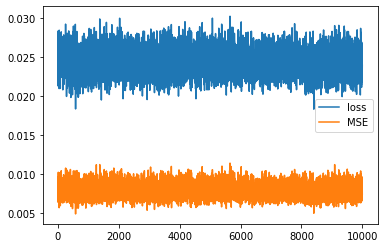

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


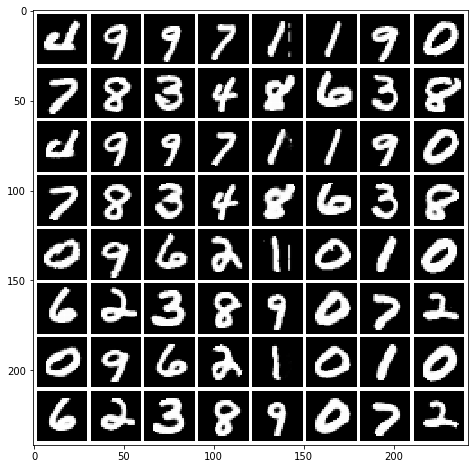

Mean squared dist: 0.008559004
epoch: 46 	 step:0 	 loss: 0.02109 	 reg loss: 0.001381
epoch: 46 	 step:100 	 loss: 0.02403 	 reg loss: 0.001393
epoch: 46 	 step:200 	 loss: 0.02428 	 reg loss: 0.001465
epoch: 46 	 step:300 	 loss: 0.02535 	 reg loss: 0.001404
epoch: 46 	 step:400 	 loss: 0.02391 	 reg loss: 0.001408
epoch: 46 	 step:500 	 loss: 0.02536 	 reg loss: 0.001383
epoch: 46 	 step:600 	 loss: 0.02523 	 reg loss: 0.001422
epoch: 46 	 step:700 	 loss: 0.02509 	 reg loss: 0.001429
epoch: 46 	 step:800 	 loss: 0.02539 	 reg loss: 0.001419
epoch: 46 	 step:900 	 loss: 0.02244 	 reg loss: 0.001346
epoch: 46 	 step:1000 	 loss: 0.02555 	 reg loss: 0.001421
epoch: 46 	 step:1100 	 loss: 0.02451 	 reg loss: 0.001374
epoch: 46 	 step:1200 	 loss: 0.02467 	 reg loss: 0.001324
epoch: 46 	 step:1300 	 loss: 0.02231 	 reg loss: 0.001359
epoch: 46 	 step:1400 	 loss: 0.02402 	 reg loss: 0.001393
epoch: 46 	 step:1500 	 loss: 0.02284 	 reg loss: 0.001396
epoch: 46 	 step:1600 	 loss: 0.02437

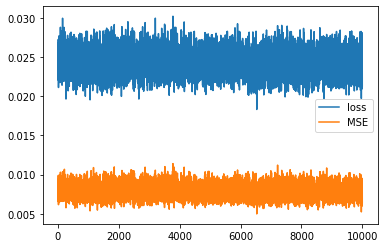

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


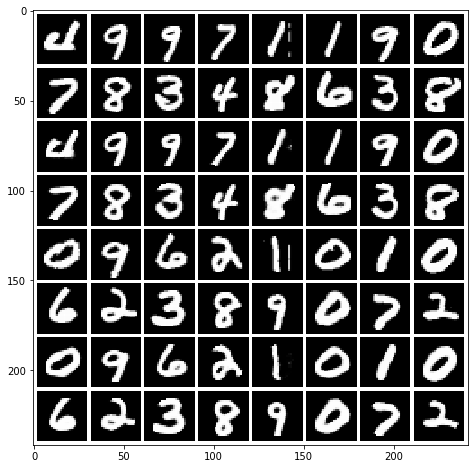

Mean squared dist: 0.008559761
epoch: 47 	 step:0 	 loss: 0.02302 	 reg loss: 0.001293
epoch: 47 	 step:100 	 loss: 0.02523 	 reg loss: 0.001431
epoch: 47 	 step:200 	 loss: 0.02465 	 reg loss: 0.00146
epoch: 47 	 step:300 	 loss: 0.02805 	 reg loss: 0.001409
epoch: 47 	 step:400 	 loss: 0.02314 	 reg loss: 0.001351
epoch: 47 	 step:500 	 loss: 0.02622 	 reg loss: 0.0014
epoch: 47 	 step:600 	 loss: 0.02619 	 reg loss: 0.00139
epoch: 47 	 step:700 	 loss: 0.02345 	 reg loss: 0.001408
epoch: 47 	 step:800 	 loss: 0.02164 	 reg loss: 0.001328
epoch: 47 	 step:900 	 loss: 0.02249 	 reg loss: 0.001316
epoch: 47 	 step:1000 	 loss: 0.02442 	 reg loss: 0.001382
epoch: 47 	 step:1100 	 loss: 0.02404 	 reg loss: 0.001396
epoch: 47 	 step:1200 	 loss: 0.02446 	 reg loss: 0.001392
epoch: 47 	 step:1300 	 loss: 0.02326 	 reg loss: 0.00139
epoch: 47 	 step:1400 	 loss: 0.02176 	 reg loss: 0.001355
epoch: 47 	 step:1500 	 loss: 0.02506 	 reg loss: 0.001404
epoch: 47 	 step:1600 	 loss: 0.0243 	 reg

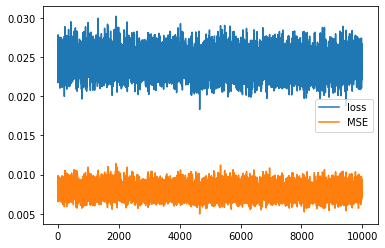

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


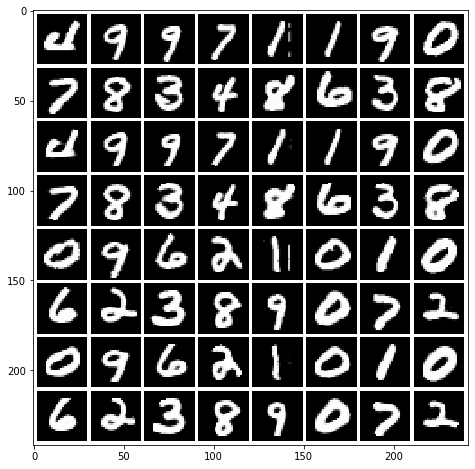

Mean squared dist: 0.008365202
epoch: 48 	 step:0 	 loss: 0.02449 	 reg loss: 0.001385
epoch: 48 	 step:100 	 loss: 0.02463 	 reg loss: 0.001381
epoch: 48 	 step:200 	 loss: 0.02771 	 reg loss: 0.00145
epoch: 48 	 step:300 	 loss: 0.02467 	 reg loss: 0.001388
epoch: 48 	 step:400 	 loss: 0.02591 	 reg loss: 0.00142
epoch: 48 	 step:500 	 loss: 0.0215 	 reg loss: 0.001372
epoch: 48 	 step:600 	 loss: 0.02235 	 reg loss: 0.00138
epoch: 48 	 step:700 	 loss: 0.02543 	 reg loss: 0.001391
epoch: 48 	 step:800 	 loss: 0.0232 	 reg loss: 0.001366
epoch: 48 	 step:900 	 loss: 0.02433 	 reg loss: 0.001395
epoch: 48 	 step:1000 	 loss: 0.02425 	 reg loss: 0.001345
epoch: 48 	 step:1100 	 loss: 0.02461 	 reg loss: 0.001384
epoch: 48 	 step:1200 	 loss: 0.02638 	 reg loss: 0.001431
epoch: 48 	 step:1300 	 loss: 0.02349 	 reg loss: 0.001349
epoch: 48 	 step:1400 	 loss: 0.0235 	 reg loss: 0.001427
epoch: 48 	 step:1500 	 loss: 0.0239 	 reg loss: 0.001354
epoch: 48 	 step:1600 	 loss: 0.02468 	 reg 

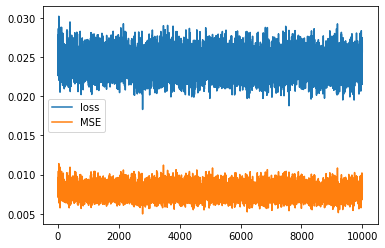

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


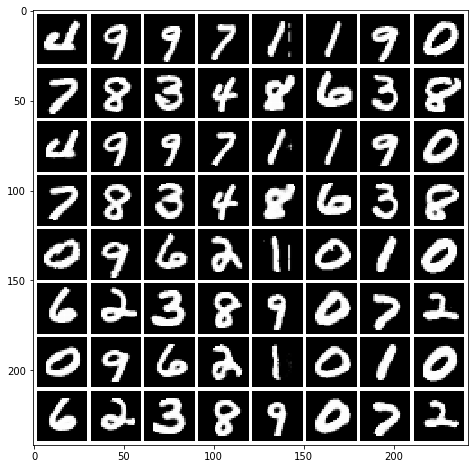

Mean squared dist: 0.0084699225
epoch: 49 	 step:0 	 loss: 0.02348 	 reg loss: 0.001378
epoch: 49 	 step:100 	 loss: 0.02547 	 reg loss: 0.001404
epoch: 49 	 step:200 	 loss: 0.02382 	 reg loss: 0.001373
epoch: 49 	 step:300 	 loss: 0.02433 	 reg loss: 0.001358
epoch: 49 	 step:400 	 loss: 0.02447 	 reg loss: 0.00139
epoch: 49 	 step:500 	 loss: 0.02368 	 reg loss: 0.001473
epoch: 49 	 step:600 	 loss: 0.02722 	 reg loss: 0.001385
epoch: 49 	 step:700 	 loss: 0.02314 	 reg loss: 0.001363
epoch: 49 	 step:800 	 loss: 0.02418 	 reg loss: 0.001376
epoch: 49 	 step:900 	 loss: 0.02448 	 reg loss: 0.001429
epoch: 49 	 step:1000 	 loss: 0.02569 	 reg loss: 0.001368
epoch: 49 	 step:1100 	 loss: 0.02473 	 reg loss: 0.0014
epoch: 49 	 step:1200 	 loss: 0.02515 	 reg loss: 0.001389
epoch: 49 	 step:1300 	 loss: 0.02219 	 reg loss: 0.001336
epoch: 49 	 step:1400 	 loss: 0.02138 	 reg loss: 0.001336
epoch: 49 	 step:1500 	 loss: 0.02419 	 reg loss: 0.001379
epoch: 49 	 step:1600 	 loss: 0.02282 	

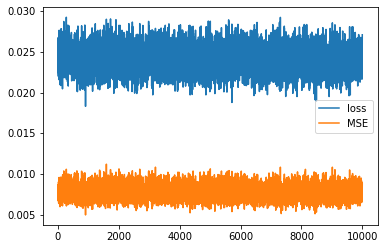

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


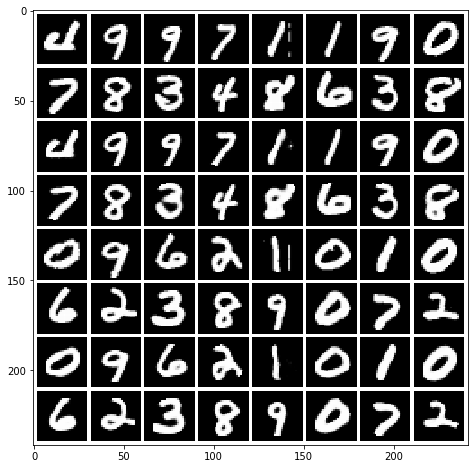

Mean squared dist: 0.008411719
epoch: 50 	 step:0 	 loss: 0.02359 	 reg loss: 0.001327
epoch: 50 	 step:100 	 loss: 0.0224 	 reg loss: 0.001367
epoch: 50 	 step:200 	 loss: 0.02068 	 reg loss: 0.001353
epoch: 50 	 step:300 	 loss: 0.0237 	 reg loss: 0.001379
epoch: 50 	 step:400 	 loss: 0.02406 	 reg loss: 0.001402
epoch: 50 	 step:500 	 loss: 0.02363 	 reg loss: 0.001342
epoch: 50 	 step:600 	 loss: 0.02349 	 reg loss: 0.001349
epoch: 50 	 step:700 	 loss: 0.02293 	 reg loss: 0.001311
epoch: 50 	 step:800 	 loss: 0.02047 	 reg loss: 0.001326
epoch: 50 	 step:900 	 loss: 0.02694 	 reg loss: 0.001383
epoch: 50 	 step:1000 	 loss: 0.02294 	 reg loss: 0.001398
epoch: 50 	 step:1100 	 loss: 0.02376 	 reg loss: 0.001374
epoch: 50 	 step:1200 	 loss: 0.02411 	 reg loss: 0.001378
epoch: 50 	 step:1300 	 loss: 0.02132 	 reg loss: 0.001304
epoch: 50 	 step:1400 	 loss: 0.0233 	 reg loss: 0.001362
epoch: 50 	 step:1500 	 loss: 0.0216 	 reg loss: 0.001368
epoch: 50 	 step:1600 	 loss: 0.02423 	 r

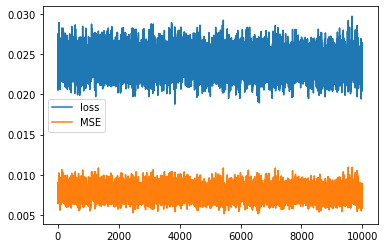

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


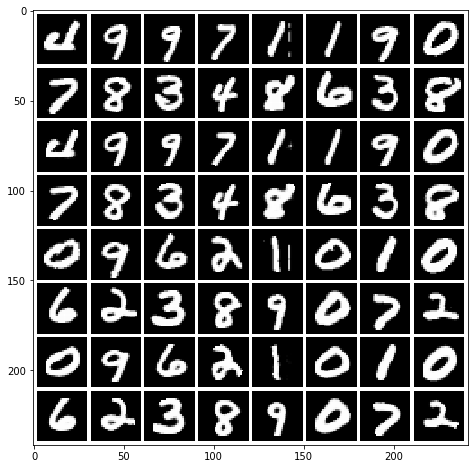

Mean squared dist: 0.008304731
epoch: 51 	 step:0 	 loss: 0.02384 	 reg loss: 0.001341
epoch: 51 	 step:100 	 loss: 0.0245 	 reg loss: 0.001429
epoch: 51 	 step:200 	 loss: 0.02361 	 reg loss: 0.001342
epoch: 51 	 step:300 	 loss: 0.02302 	 reg loss: 0.001305
epoch: 51 	 step:400 	 loss: 0.02299 	 reg loss: 0.001317
epoch: 51 	 step:500 	 loss: 0.02347 	 reg loss: 0.001373
epoch: 51 	 step:600 	 loss: 0.02122 	 reg loss: 0.00127
epoch: 51 	 step:700 	 loss: 0.02262 	 reg loss: 0.00136
epoch: 51 	 step:800 	 loss: 0.0217 	 reg loss: 0.001358
epoch: 51 	 step:900 	 loss: 0.0219 	 reg loss: 0.001325
epoch: 51 	 step:1000 	 loss: 0.02467 	 reg loss: 0.001412
epoch: 51 	 step:1100 	 loss: 0.02269 	 reg loss: 0.001354
epoch: 51 	 step:1200 	 loss: 0.0247 	 reg loss: 0.001371
epoch: 51 	 step:1300 	 loss: 0.02696 	 reg loss: 0.001401
epoch: 51 	 step:1400 	 loss: 0.02462 	 reg loss: 0.001331
epoch: 51 	 step:1500 	 loss: 0.02263 	 reg loss: 0.001342
epoch: 51 	 step:1600 	 loss: 0.02537 	 reg

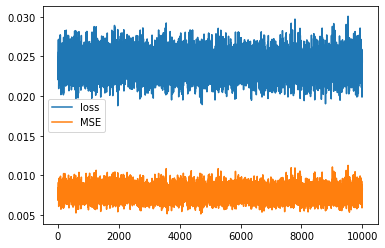

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


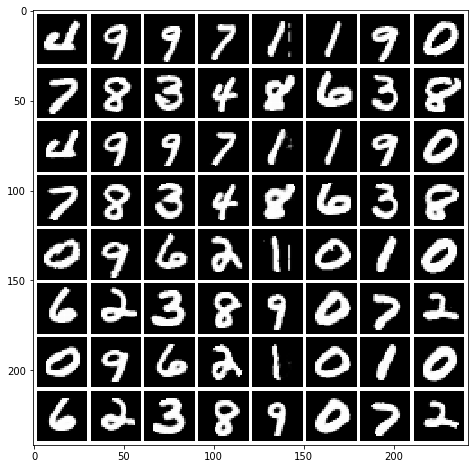

Mean squared dist: 0.008327243
epoch: 52 	 step:0 	 loss: 0.02356 	 reg loss: 0.001378
epoch: 52 	 step:100 	 loss: 0.0277 	 reg loss: 0.001471
epoch: 52 	 step:200 	 loss: 0.02533 	 reg loss: 0.001474
epoch: 52 	 step:300 	 loss: 0.02316 	 reg loss: 0.001369
epoch: 52 	 step:400 	 loss: 0.02116 	 reg loss: 0.00142
epoch: 52 	 step:500 	 loss: 0.02418 	 reg loss: 0.001435
epoch: 52 	 step:600 	 loss: 0.0222 	 reg loss: 0.001362
epoch: 52 	 step:700 	 loss: 0.02717 	 reg loss: 0.001436
epoch: 52 	 step:800 	 loss: 0.02432 	 reg loss: 0.001368
epoch: 52 	 step:900 	 loss: 0.02211 	 reg loss: 0.001316
epoch: 52 	 step:1000 	 loss: 0.02878 	 reg loss: 0.001441
epoch: 52 	 step:1100 	 loss: 0.02424 	 reg loss: 0.001346
epoch: 52 	 step:1200 	 loss: 0.02537 	 reg loss: 0.001394
epoch: 52 	 step:1300 	 loss: 0.0239 	 reg loss: 0.001345
epoch: 52 	 step:1400 	 loss: 0.0218 	 reg loss: 0.001361
epoch: 52 	 step:1500 	 loss: 0.02397 	 reg loss: 0.001427
epoch: 52 	 step:1600 	 loss: 0.02193 	 re

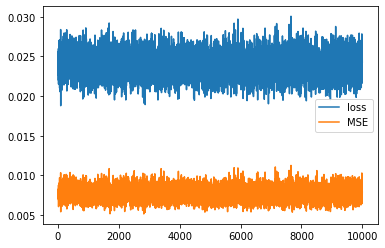

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


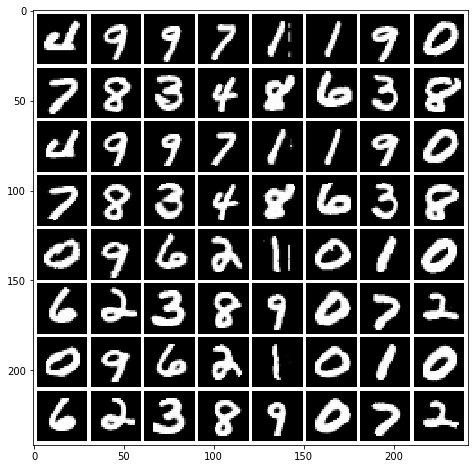

Mean squared dist: 0.008318064
epoch: 53 	 step:0 	 loss: 0.02501 	 reg loss: 0.001447
epoch: 53 	 step:100 	 loss: 0.02428 	 reg loss: 0.001393
epoch: 53 	 step:200 	 loss: 0.0237 	 reg loss: 0.001418
epoch: 53 	 step:300 	 loss: 0.02314 	 reg loss: 0.001386
epoch: 53 	 step:400 	 loss: 0.02238 	 reg loss: 0.00137
epoch: 53 	 step:500 	 loss: 0.02157 	 reg loss: 0.001315
epoch: 53 	 step:600 	 loss: 0.02213 	 reg loss: 0.001383
epoch: 53 	 step:700 	 loss: 0.02792 	 reg loss: 0.001423
epoch: 53 	 step:800 	 loss: 0.02216 	 reg loss: 0.001292
epoch: 53 	 step:900 	 loss: 0.0234 	 reg loss: 0.001386
epoch: 53 	 step:1000 	 loss: 0.02217 	 reg loss: 0.001393
epoch: 53 	 step:1100 	 loss: 0.02365 	 reg loss: 0.001359
epoch: 53 	 step:1200 	 loss: 0.02222 	 reg loss: 0.001338
epoch: 53 	 step:1300 	 loss: 0.02383 	 reg loss: 0.001366
epoch: 53 	 step:1400 	 loss: 0.02249 	 reg loss: 0.001346
epoch: 53 	 step:1500 	 loss: 0.02362 	 reg loss: 0.001406
epoch: 53 	 step:1600 	 loss: 0.02536 	 

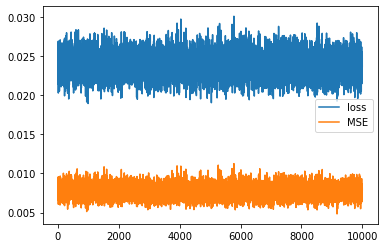

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


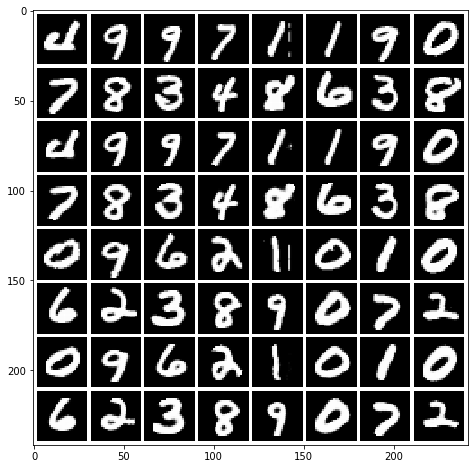

Mean squared dist: 0.008419272
epoch: 54 	 step:0 	 loss: 0.02299 	 reg loss: 0.001377
epoch: 54 	 step:100 	 loss: 0.02284 	 reg loss: 0.001391
epoch: 54 	 step:200 	 loss: 0.02182 	 reg loss: 0.001293
epoch: 54 	 step:300 	 loss: 0.01995 	 reg loss: 0.001319
epoch: 54 	 step:400 	 loss: 0.02395 	 reg loss: 0.001367
epoch: 54 	 step:500 	 loss: 0.02406 	 reg loss: 0.001402
epoch: 54 	 step:600 	 loss: 0.02326 	 reg loss: 0.001379
epoch: 54 	 step:700 	 loss: 0.02498 	 reg loss: 0.001379
epoch: 54 	 step:800 	 loss: 0.02391 	 reg loss: 0.001362
epoch: 54 	 step:900 	 loss: 0.02286 	 reg loss: 0.001356
epoch: 54 	 step:1000 	 loss: 0.0249 	 reg loss: 0.00142
epoch: 54 	 step:1100 	 loss: 0.02405 	 reg loss: 0.001363
epoch: 54 	 step:1200 	 loss: 0.02601 	 reg loss: 0.001414
epoch: 54 	 step:1300 	 loss: 0.02278 	 reg loss: 0.001353
epoch: 54 	 step:1400 	 loss: 0.02525 	 reg loss: 0.001418
epoch: 54 	 step:1500 	 loss: 0.02386 	 reg loss: 0.00137
epoch: 54 	 step:1600 	 loss: 0.02366 	 

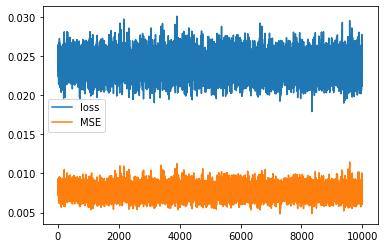

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


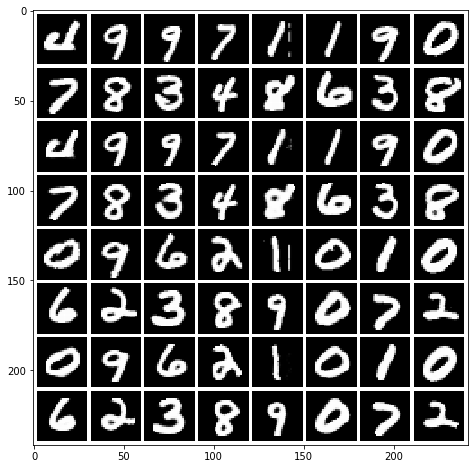

Mean squared dist: 0.008252472
epoch: 55 	 step:0 	 loss: 0.02563 	 reg loss: 0.0014
epoch: 55 	 step:100 	 loss: 0.02419 	 reg loss: 0.001431
epoch: 55 	 step:200 	 loss: 0.02204 	 reg loss: 0.001334
epoch: 55 	 step:300 	 loss: 0.02566 	 reg loss: 0.001432
epoch: 55 	 step:400 	 loss: 0.02397 	 reg loss: 0.001388
epoch: 55 	 step:500 	 loss: 0.02334 	 reg loss: 0.001409
epoch: 55 	 step:600 	 loss: 0.02233 	 reg loss: 0.001333
epoch: 55 	 step:700 	 loss: 0.02498 	 reg loss: 0.001417
epoch: 55 	 step:800 	 loss: 0.02383 	 reg loss: 0.001359
epoch: 55 	 step:900 	 loss: 0.02396 	 reg loss: 0.001372
epoch: 55 	 step:1000 	 loss: 0.02387 	 reg loss: 0.001342
epoch: 55 	 step:1100 	 loss: 0.02389 	 reg loss: 0.001395
epoch: 55 	 step:1200 	 loss: 0.02322 	 reg loss: 0.001304
epoch: 55 	 step:1300 	 loss: 0.02347 	 reg loss: 0.001389
epoch: 55 	 step:1400 	 loss: 0.02333 	 reg loss: 0.001341
epoch: 55 	 step:1500 	 loss: 0.02513 	 reg loss: 0.00138
epoch: 55 	 step:1600 	 loss: 0.02312 	 

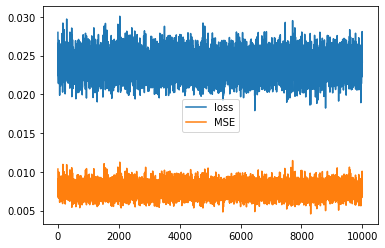

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


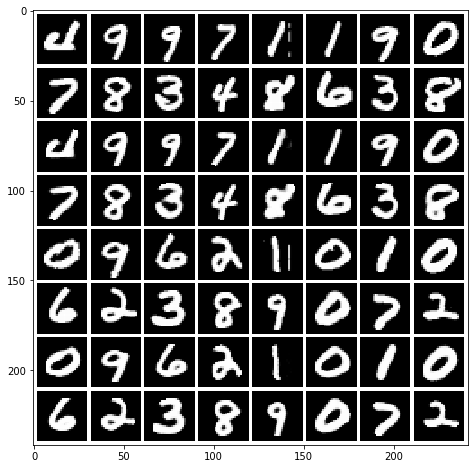

Mean squared dist: 0.008274743
epoch: 56 	 step:0 	 loss: 0.02339 	 reg loss: 0.001403
epoch: 56 	 step:100 	 loss: 0.02101 	 reg loss: 0.001319
epoch: 56 	 step:200 	 loss: 0.02357 	 reg loss: 0.001385
epoch: 56 	 step:300 	 loss: 0.02221 	 reg loss: 0.00137
epoch: 56 	 step:400 	 loss: 0.02202 	 reg loss: 0.001354
epoch: 56 	 step:500 	 loss: 0.02285 	 reg loss: 0.001425
epoch: 56 	 step:600 	 loss: 0.02446 	 reg loss: 0.001357
epoch: 56 	 step:700 	 loss: 0.02479 	 reg loss: 0.001368
epoch: 56 	 step:800 	 loss: 0.02418 	 reg loss: 0.001333
epoch: 56 	 step:900 	 loss: 0.02436 	 reg loss: 0.001448
epoch: 56 	 step:1000 	 loss: 0.02218 	 reg loss: 0.00129
epoch: 56 	 step:1100 	 loss: 0.02448 	 reg loss: 0.00132
epoch: 56 	 step:1200 	 loss: 0.02399 	 reg loss: 0.001391
epoch: 56 	 step:1300 	 loss: 0.02562 	 reg loss: 0.001356
epoch: 56 	 step:1400 	 loss: 0.02294 	 reg loss: 0.001331
epoch: 56 	 step:1500 	 loss: 0.02394 	 reg loss: 0.00133
epoch: 56 	 step:1600 	 loss: 0.02258 	 r

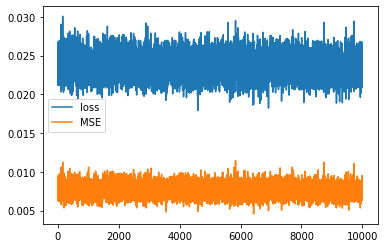

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


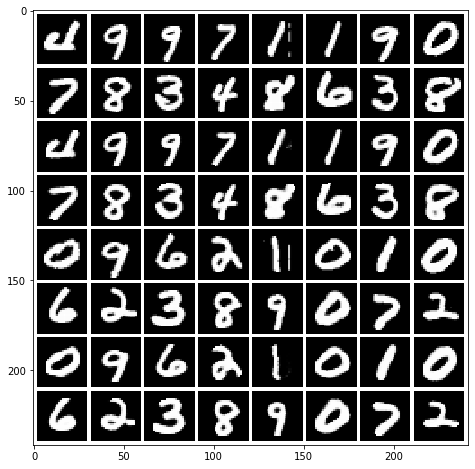

Mean squared dist: 0.008329425
epoch: 57 	 step:0 	 loss: 0.0235 	 reg loss: 0.0014
epoch: 57 	 step:100 	 loss: 0.0196 	 reg loss: 0.001345
epoch: 57 	 step:200 	 loss: 0.0241 	 reg loss: 0.001373
epoch: 57 	 step:300 	 loss: 0.02179 	 reg loss: 0.001311
epoch: 57 	 step:400 	 loss: 0.02387 	 reg loss: 0.001315
epoch: 57 	 step:500 	 loss: 0.02131 	 reg loss: 0.001329
epoch: 57 	 step:600 	 loss: 0.02347 	 reg loss: 0.001369
epoch: 57 	 step:700 	 loss: 0.02441 	 reg loss: 0.001397
epoch: 57 	 step:800 	 loss: 0.0254 	 reg loss: 0.001358
epoch: 57 	 step:900 	 loss: 0.02385 	 reg loss: 0.001373
epoch: 57 	 step:1000 	 loss: 0.02368 	 reg loss: 0.001371
epoch: 57 	 step:1100 	 loss: 0.02481 	 reg loss: 0.001359
epoch: 57 	 step:1200 	 loss: 0.02406 	 reg loss: 0.001369
epoch: 57 	 step:1300 	 loss: 0.02375 	 reg loss: 0.001344
epoch: 57 	 step:1400 	 loss: 0.02354 	 reg loss: 0.001381
epoch: 57 	 step:1500 	 loss: 0.02502 	 reg loss: 0.001405
epoch: 57 	 step:1600 	 loss: 0.02353 	 reg

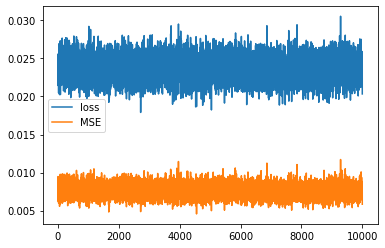

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


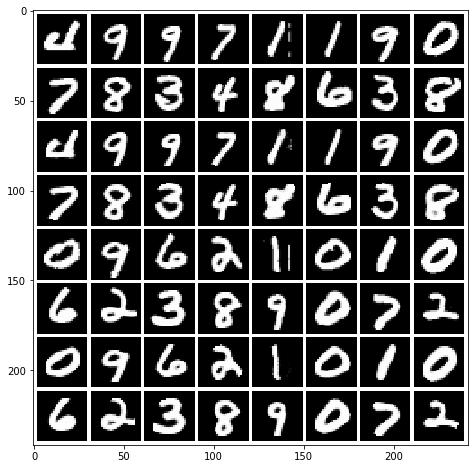

Mean squared dist: 0.0081318775
epoch: 58 	 step:0 	 loss: 0.02272 	 reg loss: 0.001309
epoch: 58 	 step:100 	 loss: 0.02569 	 reg loss: 0.001399
epoch: 58 	 step:200 	 loss: 0.02219 	 reg loss: 0.001364
epoch: 58 	 step:300 	 loss: 0.02088 	 reg loss: 0.001353
epoch: 58 	 step:400 	 loss: 0.02566 	 reg loss: 0.001354
epoch: 58 	 step:500 	 loss: 0.02517 	 reg loss: 0.001403
epoch: 58 	 step:600 	 loss: 0.02057 	 reg loss: 0.001323
epoch: 58 	 step:700 	 loss: 0.0228 	 reg loss: 0.001366
epoch: 58 	 step:800 	 loss: 0.02546 	 reg loss: 0.001431
epoch: 58 	 step:900 	 loss: 0.02181 	 reg loss: 0.001374
epoch: 58 	 step:1000 	 loss: 0.0233 	 reg loss: 0.00135
epoch: 58 	 step:1100 	 loss: 0.02324 	 reg loss: 0.001358
epoch: 58 	 step:1200 	 loss: 0.0253 	 reg loss: 0.001379
epoch: 58 	 step:1300 	 loss: 0.02466 	 reg loss: 0.001391
epoch: 58 	 step:1400 	 loss: 0.02574 	 reg loss: 0.001362
epoch: 58 	 step:1500 	 loss: 0.02097 	 reg loss: 0.001347
epoch: 58 	 step:1600 	 loss: 0.02185 	 

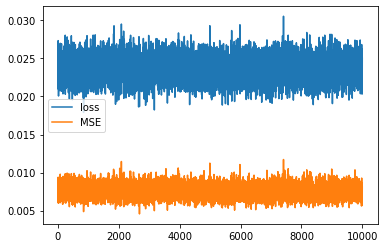

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


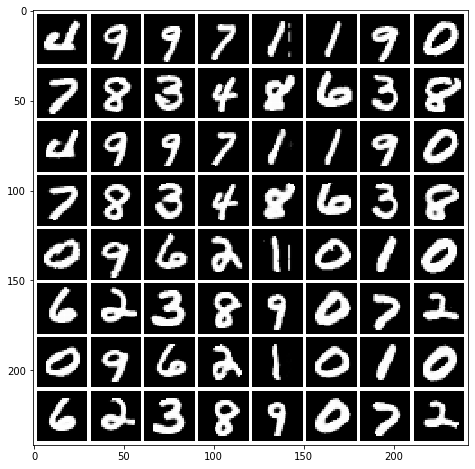

Mean squared dist: 0.008180044
epoch: 59 	 step:0 	 loss: 0.02339 	 reg loss: 0.00134
epoch: 59 	 step:100 	 loss: 0.02237 	 reg loss: 0.001308
epoch: 59 	 step:200 	 loss: 0.0247 	 reg loss: 0.001425
epoch: 59 	 step:300 	 loss: 0.02377 	 reg loss: 0.001383
epoch: 59 	 step:400 	 loss: 0.02529 	 reg loss: 0.001356
epoch: 59 	 step:500 	 loss: 0.02308 	 reg loss: 0.001338
epoch: 59 	 step:600 	 loss: 0.02421 	 reg loss: 0.001413
epoch: 59 	 step:700 	 loss: 0.02373 	 reg loss: 0.00135
epoch: 59 	 step:800 	 loss: 0.02264 	 reg loss: 0.001423
epoch: 59 	 step:900 	 loss: 0.02455 	 reg loss: 0.001366
epoch: 59 	 step:1000 	 loss: 0.02207 	 reg loss: 0.001396
epoch: 59 	 step:1100 	 loss: 0.02326 	 reg loss: 0.001424
epoch: 59 	 step:1200 	 loss: 0.02404 	 reg loss: 0.001338
epoch: 59 	 step:1300 	 loss: 0.02455 	 reg loss: 0.001367
epoch: 59 	 step:1400 	 loss: 0.02586 	 reg loss: 0.001326
epoch: 59 	 step:1500 	 loss: 0.02364 	 reg loss: 0.001338
epoch: 59 	 step:1600 	 loss: 0.02215 	 

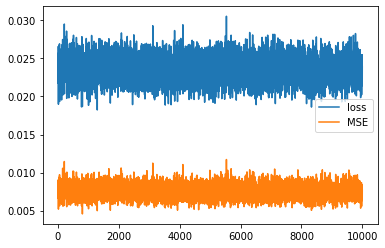

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


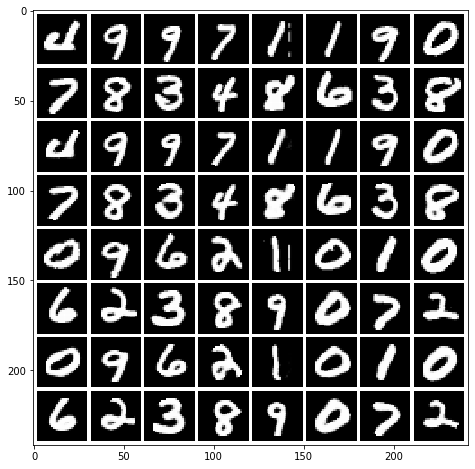

Mean squared dist: 0.008086916
epoch: 60 	 step:0 	 loss: 0.02298 	 reg loss: 0.001349
epoch: 60 	 step:100 	 loss: 0.02497 	 reg loss: 0.001342
epoch: 60 	 step:200 	 loss: 0.02171 	 reg loss: 0.001347
epoch: 60 	 step:300 	 loss: 0.02407 	 reg loss: 0.001387
epoch: 60 	 step:400 	 loss: 0.02402 	 reg loss: 0.001382
epoch: 60 	 step:500 	 loss: 0.02354 	 reg loss: 0.001355
epoch: 60 	 step:600 	 loss: 0.02498 	 reg loss: 0.001385
epoch: 60 	 step:700 	 loss: 0.02453 	 reg loss: 0.001372
epoch: 60 	 step:800 	 loss: 0.02252 	 reg loss: 0.001373
epoch: 60 	 step:900 	 loss: 0.02205 	 reg loss: 0.001317
epoch: 60 	 step:1000 	 loss: 0.02268 	 reg loss: 0.001362
epoch: 60 	 step:1100 	 loss: 0.02446 	 reg loss: 0.001347
epoch: 60 	 step:1200 	 loss: 0.02461 	 reg loss: 0.001413
epoch: 60 	 step:1300 	 loss: 0.02498 	 reg loss: 0.001406
epoch: 60 	 step:1400 	 loss: 0.02416 	 reg loss: 0.001356
epoch: 60 	 step:1500 	 loss: 0.02331 	 reg loss: 0.001367
epoch: 60 	 step:1600 	 loss: 0.02513

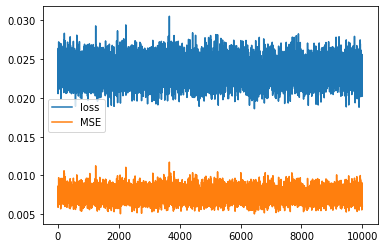

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


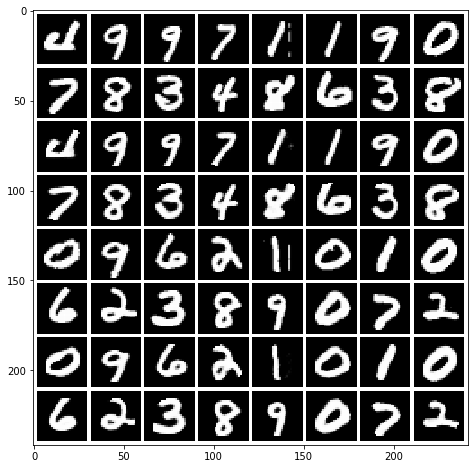

Mean squared dist: 0.00815155
epoch: 61 	 step:0 	 loss: 0.02347 	 reg loss: 0.001347
epoch: 61 	 step:100 	 loss: 0.02371 	 reg loss: 0.001343
epoch: 61 	 step:200 	 loss: 0.02406 	 reg loss: 0.001409
epoch: 61 	 step:300 	 loss: 0.02513 	 reg loss: 0.001441
epoch: 61 	 step:400 	 loss: 0.02427 	 reg loss: 0.001435
epoch: 61 	 step:500 	 loss: 0.02476 	 reg loss: 0.001394
epoch: 61 	 step:600 	 loss: 0.02541 	 reg loss: 0.001405
epoch: 61 	 step:700 	 loss: 0.0211 	 reg loss: 0.001362
epoch: 61 	 step:800 	 loss: 0.023 	 reg loss: 0.001326
epoch: 61 	 step:900 	 loss: 0.02317 	 reg loss: 0.001303
epoch: 61 	 step:1000 	 loss: 0.02331 	 reg loss: 0.001343
epoch: 61 	 step:1100 	 loss: 0.02422 	 reg loss: 0.001358
epoch: 61 	 step:1200 	 loss: 0.02112 	 reg loss: 0.001342
epoch: 61 	 step:1300 	 loss: 0.02362 	 reg loss: 0.001329
epoch: 61 	 step:1400 	 loss: 0.02334 	 reg loss: 0.001388
epoch: 61 	 step:1500 	 loss: 0.02297 	 reg loss: 0.001327
epoch: 61 	 step:1600 	 loss: 0.02284 	 r

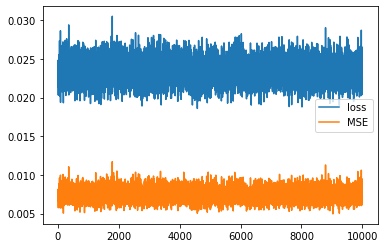

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


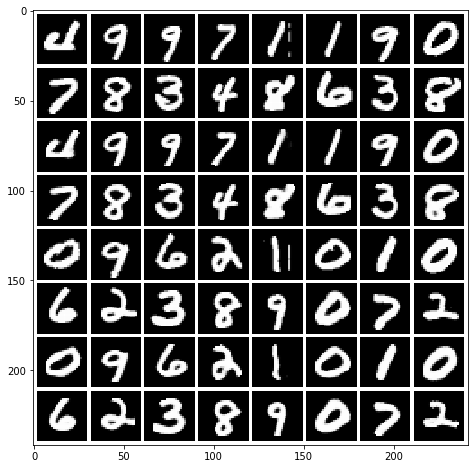

Mean squared dist: 0.008174873
epoch: 62 	 step:0 	 loss: 0.02233 	 reg loss: 0.001358
epoch: 62 	 step:100 	 loss: 0.02348 	 reg loss: 0.0014
epoch: 62 	 step:200 	 loss: 0.02227 	 reg loss: 0.001321
epoch: 62 	 step:300 	 loss: 0.02209 	 reg loss: 0.001361
epoch: 62 	 step:400 	 loss: 0.02362 	 reg loss: 0.001411
epoch: 62 	 step:500 	 loss: 0.02392 	 reg loss: 0.001372
epoch: 62 	 step:600 	 loss: 0.02197 	 reg loss: 0.001377
epoch: 62 	 step:700 	 loss: 0.02074 	 reg loss: 0.001313
epoch: 62 	 step:800 	 loss: 0.02457 	 reg loss: 0.00139
epoch: 62 	 step:900 	 loss: 0.0228 	 reg loss: 0.001292
epoch: 62 	 step:1000 	 loss: 0.01883 	 reg loss: 0.001309
epoch: 62 	 step:1100 	 loss: 0.02492 	 reg loss: 0.001406
epoch: 62 	 step:1200 	 loss: 0.02517 	 reg loss: 0.001414
epoch: 62 	 step:1300 	 loss: 0.02481 	 reg loss: 0.00141
epoch: 62 	 step:1400 	 loss: 0.02438 	 reg loss: 0.001398
epoch: 62 	 step:1500 	 loss: 0.0229 	 reg loss: 0.001334
epoch: 62 	 step:1600 	 loss: 0.02255 	 reg

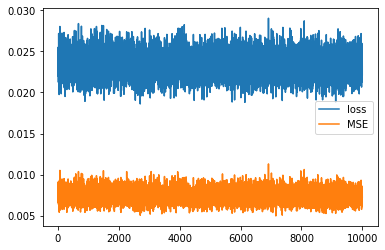

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


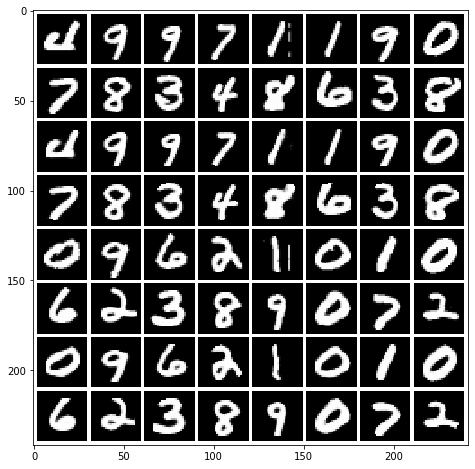

Mean squared dist: 0.0081026815
epoch: 63 	 step:0 	 loss: 0.02081 	 reg loss: 0.001299
epoch: 63 	 step:100 	 loss: 0.02548 	 reg loss: 0.001373
epoch: 63 	 step:200 	 loss: 0.0242 	 reg loss: 0.001371
epoch: 63 	 step:300 	 loss: 0.02383 	 reg loss: 0.001341
epoch: 63 	 step:400 	 loss: 0.02209 	 reg loss: 0.001345
epoch: 63 	 step:500 	 loss: 0.02576 	 reg loss: 0.001357
epoch: 63 	 step:600 	 loss: 0.02268 	 reg loss: 0.001352
epoch: 63 	 step:700 	 loss: 0.02427 	 reg loss: 0.001391
epoch: 63 	 step:800 	 loss: 0.02387 	 reg loss: 0.001319
epoch: 63 	 step:900 	 loss: 0.02488 	 reg loss: 0.001398
epoch: 63 	 step:1000 	 loss: 0.0246 	 reg loss: 0.001425
epoch: 63 	 step:1100 	 loss: 0.02223 	 reg loss: 0.001268
epoch: 63 	 step:1200 	 loss: 0.02192 	 reg loss: 0.001389
epoch: 63 	 step:1300 	 loss: 0.02366 	 reg loss: 0.001356
epoch: 63 	 step:1400 	 loss: 0.02432 	 reg loss: 0.001379
epoch: 63 	 step:1500 	 loss: 0.02245 	 reg loss: 0.001348
epoch: 63 	 step:1600 	 loss: 0.02143 

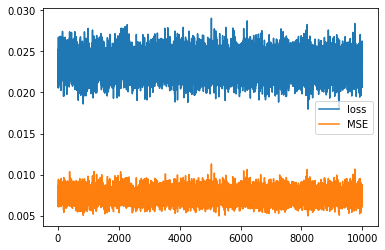

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


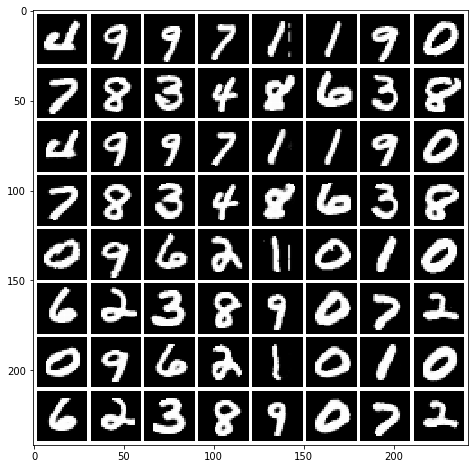

Mean squared dist: 0.008007447
epoch: 64 	 step:0 	 loss: 0.0225 	 reg loss: 0.001343
epoch: 64 	 step:100 	 loss: 0.02152 	 reg loss: 0.001359
epoch: 64 	 step:200 	 loss: 0.02572 	 reg loss: 0.001353
epoch: 64 	 step:300 	 loss: 0.02186 	 reg loss: 0.001304
epoch: 64 	 step:400 	 loss: 0.02518 	 reg loss: 0.001364
epoch: 64 	 step:500 	 loss: 0.02234 	 reg loss: 0.001314
epoch: 64 	 step:600 	 loss: 0.02301 	 reg loss: 0.001364
epoch: 64 	 step:700 	 loss: 0.02307 	 reg loss: 0.001394
epoch: 64 	 step:800 	 loss: 0.02106 	 reg loss: 0.001336
epoch: 64 	 step:900 	 loss: 0.02416 	 reg loss: 0.001406
epoch: 64 	 step:1000 	 loss: 0.02091 	 reg loss: 0.001315
epoch: 64 	 step:1100 	 loss: 0.02392 	 reg loss: 0.001269
epoch: 64 	 step:1200 	 loss: 0.02446 	 reg loss: 0.001385
epoch: 64 	 step:1300 	 loss: 0.02297 	 reg loss: 0.00139
epoch: 64 	 step:1400 	 loss: 0.02069 	 reg loss: 0.001309
epoch: 64 	 step:1500 	 loss: 0.02461 	 reg loss: 0.001346
epoch: 64 	 step:1600 	 loss: 0.02573 	

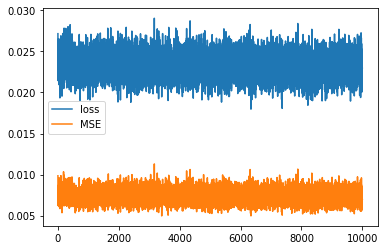

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


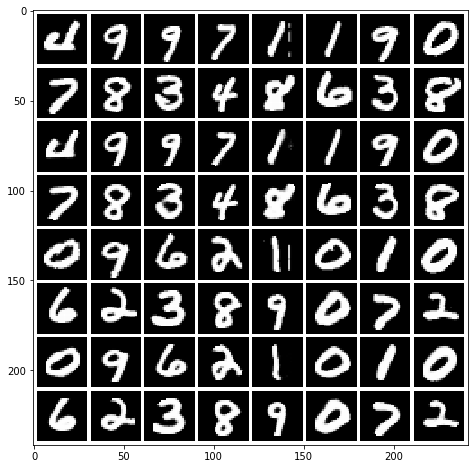

Mean squared dist: 0.008059238
epoch: 65 	 step:0 	 loss: 0.02157 	 reg loss: 0.001306
epoch: 65 	 step:100 	 loss: 0.02472 	 reg loss: 0.001374
epoch: 65 	 step:200 	 loss: 0.02311 	 reg loss: 0.001361
epoch: 65 	 step:300 	 loss: 0.02302 	 reg loss: 0.001314
epoch: 65 	 step:400 	 loss: 0.02188 	 reg loss: 0.001348
epoch: 65 	 step:500 	 loss: 0.02063 	 reg loss: 0.001338
epoch: 65 	 step:600 	 loss: 0.0229 	 reg loss: 0.001371
epoch: 65 	 step:700 	 loss: 0.02244 	 reg loss: 0.001346
epoch: 65 	 step:800 	 loss: 0.02417 	 reg loss: 0.001355
epoch: 65 	 step:900 	 loss: 0.0253 	 reg loss: 0.001356
epoch: 65 	 step:1000 	 loss: 0.02302 	 reg loss: 0.001354
epoch: 65 	 step:1100 	 loss: 0.02134 	 reg loss: 0.001315
epoch: 65 	 step:1200 	 loss: 0.02536 	 reg loss: 0.001358
epoch: 65 	 step:1300 	 loss: 0.02426 	 reg loss: 0.001311
epoch: 65 	 step:1400 	 loss: 0.02356 	 reg loss: 0.001355
epoch: 65 	 step:1500 	 loss: 0.02273 	 reg loss: 0.001298
epoch: 65 	 step:1600 	 loss: 0.02317 	

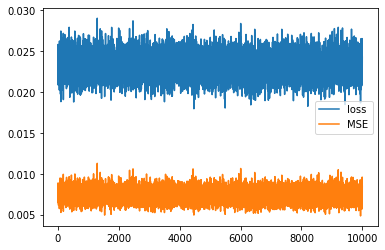

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


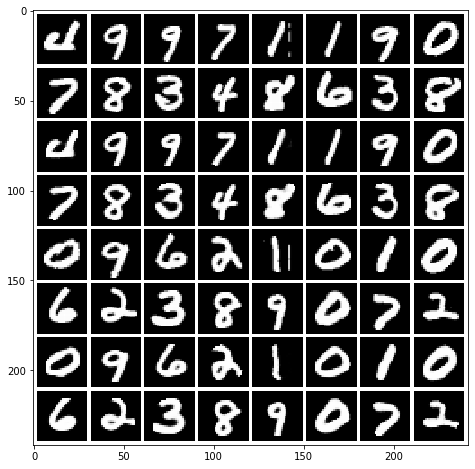

Mean squared dist: 0.008066002
epoch: 66 	 step:0 	 loss: 0.02435 	 reg loss: 0.001368
epoch: 66 	 step:100 	 loss: 0.02385 	 reg loss: 0.001364
epoch: 66 	 step:200 	 loss: 0.02344 	 reg loss: 0.001338
epoch: 66 	 step:300 	 loss: 0.0208 	 reg loss: 0.001318
epoch: 66 	 step:400 	 loss: 0.02296 	 reg loss: 0.001261
epoch: 66 	 step:500 	 loss: 0.02596 	 reg loss: 0.00143
epoch: 66 	 step:600 	 loss: 0.02267 	 reg loss: 0.001318
epoch: 66 	 step:700 	 loss: 0.02271 	 reg loss: 0.00137
epoch: 66 	 step:800 	 loss: 0.0228 	 reg loss: 0.00142
epoch: 66 	 step:900 	 loss: 0.02362 	 reg loss: 0.001359
epoch: 66 	 step:1000 	 loss: 0.02358 	 reg loss: 0.001316
epoch: 66 	 step:1100 	 loss: 0.02033 	 reg loss: 0.001304
epoch: 66 	 step:1200 	 loss: 0.02457 	 reg loss: 0.00141
epoch: 66 	 step:1300 	 loss: 0.02525 	 reg loss: 0.001382
epoch: 66 	 step:1400 	 loss: 0.02406 	 reg loss: 0.001359
epoch: 66 	 step:1500 	 loss: 0.0247 	 reg loss: 0.001403
epoch: 66 	 step:1600 	 loss: 0.02177 	 reg 

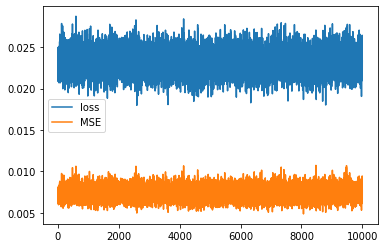

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


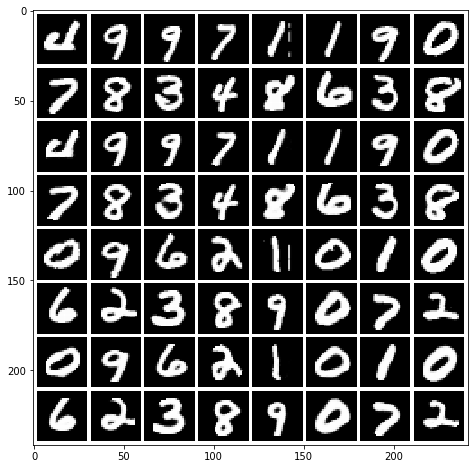

Mean squared dist: 0.007918947
epoch: 67 	 step:0 	 loss: 0.02403 	 reg loss: 0.001327
epoch: 67 	 step:100 	 loss: 0.02447 	 reg loss: 0.001334
epoch: 67 	 step:200 	 loss: 0.02334 	 reg loss: 0.001328
epoch: 67 	 step:300 	 loss: 0.02442 	 reg loss: 0.00132
epoch: 67 	 step:400 	 loss: 0.02387 	 reg loss: 0.001343
epoch: 67 	 step:500 	 loss: 0.02387 	 reg loss: 0.001356
epoch: 67 	 step:600 	 loss: 0.02268 	 reg loss: 0.00133
epoch: 67 	 step:700 	 loss: 0.02268 	 reg loss: 0.001381
epoch: 67 	 step:800 	 loss: 0.02197 	 reg loss: 0.001297
epoch: 67 	 step:900 	 loss: 0.02259 	 reg loss: 0.001327
epoch: 67 	 step:1000 	 loss: 0.02131 	 reg loss: 0.001267
epoch: 67 	 step:1100 	 loss: 0.02514 	 reg loss: 0.001408
epoch: 67 	 step:1200 	 loss: 0.02219 	 reg loss: 0.001345
epoch: 67 	 step:1300 	 loss: 0.02171 	 reg loss: 0.001398
epoch: 67 	 step:1400 	 loss: 0.02312 	 reg loss: 0.001351
epoch: 67 	 step:1500 	 loss: 0.02181 	 reg loss: 0.001379
epoch: 67 	 step:1600 	 loss: 0.02009 	

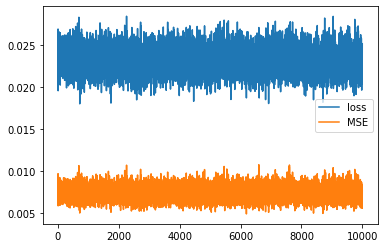

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


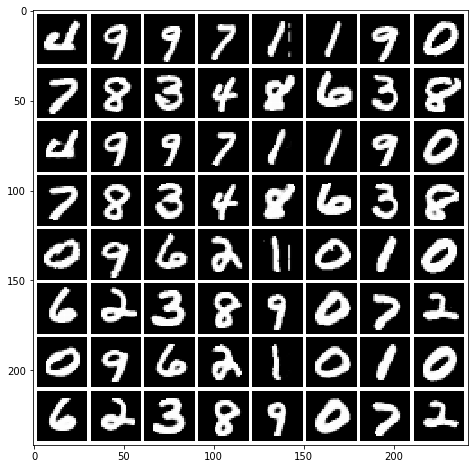

Mean squared dist: 0.007886203
epoch: 68 	 step:0 	 loss: 0.02141 	 reg loss: 0.001352
epoch: 68 	 step:100 	 loss: 0.0243 	 reg loss: 0.001419
epoch: 68 	 step:200 	 loss: 0.02162 	 reg loss: 0.001322
epoch: 68 	 step:300 	 loss: 0.02532 	 reg loss: 0.001428
epoch: 68 	 step:400 	 loss: 0.02367 	 reg loss: 0.001359
epoch: 68 	 step:500 	 loss: 0.02278 	 reg loss: 0.001326
epoch: 68 	 step:600 	 loss: 0.02303 	 reg loss: 0.001338
epoch: 68 	 step:700 	 loss: 0.02521 	 reg loss: 0.001361
epoch: 68 	 step:800 	 loss: 0.02441 	 reg loss: 0.0014
epoch: 68 	 step:900 	 loss: 0.02484 	 reg loss: 0.001376
epoch: 68 	 step:1000 	 loss: 0.02247 	 reg loss: 0.001337
epoch: 68 	 step:1100 	 loss: 0.02306 	 reg loss: 0.001341
epoch: 68 	 step:1200 	 loss: 0.02149 	 reg loss: 0.001306
epoch: 68 	 step:1300 	 loss: 0.02211 	 reg loss: 0.001294
epoch: 68 	 step:1400 	 loss: 0.0222 	 reg loss: 0.001358
epoch: 68 	 step:1500 	 loss: 0.02105 	 reg loss: 0.001316
epoch: 68 	 step:1600 	 loss: 0.02285 	 r

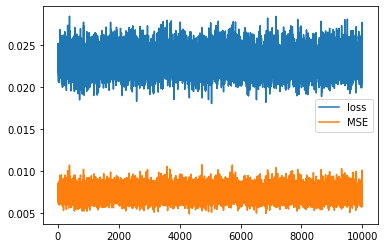

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


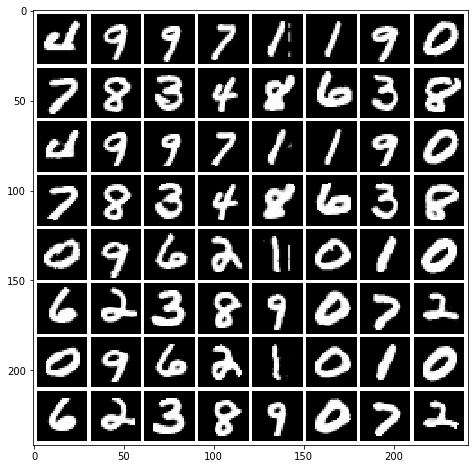

Mean squared dist: 0.0079115555
epoch: 69 	 step:0 	 loss: 0.01991 	 reg loss: 0.001323
epoch: 69 	 step:100 	 loss: 0.0238 	 reg loss: 0.001376
epoch: 69 	 step:200 	 loss: 0.02368 	 reg loss: 0.001347
epoch: 69 	 step:300 	 loss: 0.02171 	 reg loss: 0.001356
epoch: 69 	 step:400 	 loss: 0.02349 	 reg loss: 0.001385
epoch: 69 	 step:500 	 loss: 0.02428 	 reg loss: 0.001342
epoch: 69 	 step:600 	 loss: 0.02499 	 reg loss: 0.001413
epoch: 69 	 step:700 	 loss: 0.02123 	 reg loss: 0.001272
epoch: 69 	 step:800 	 loss: 0.02244 	 reg loss: 0.001366
epoch: 69 	 step:900 	 loss: 0.02057 	 reg loss: 0.001327
epoch: 69 	 step:1000 	 loss: 0.02422 	 reg loss: 0.001387
epoch: 69 	 step:1100 	 loss: 0.0222 	 reg loss: 0.001323
epoch: 69 	 step:1200 	 loss: 0.02098 	 reg loss: 0.001354
epoch: 69 	 step:1300 	 loss: 0.02383 	 reg loss: 0.001388
epoch: 69 	 step:1400 	 loss: 0.02493 	 reg loss: 0.001278
epoch: 69 	 step:1500 	 loss: 0.02439 	 reg loss: 0.001341
epoch: 69 	 step:1600 	 loss: 0.02431 

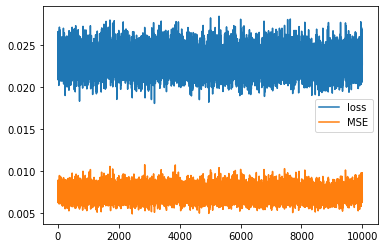

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


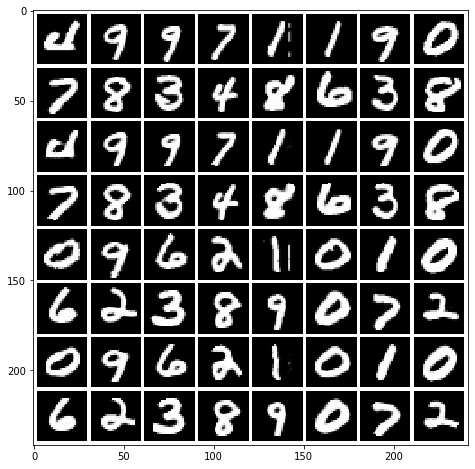

Mean squared dist: 0.007996876
epoch: 70 	 step:0 	 loss: 0.02321 	 reg loss: 0.001372
epoch: 70 	 step:100 	 loss: 0.02248 	 reg loss: 0.001337
epoch: 70 	 step:200 	 loss: 0.02407 	 reg loss: 0.001356
epoch: 70 	 step:300 	 loss: 0.02464 	 reg loss: 0.001393
epoch: 70 	 step:400 	 loss: 0.02521 	 reg loss: 0.001318
epoch: 70 	 step:500 	 loss: 0.02265 	 reg loss: 0.001374
epoch: 70 	 step:600 	 loss: 0.02374 	 reg loss: 0.001303
epoch: 70 	 step:700 	 loss: 0.02131 	 reg loss: 0.001348
epoch: 70 	 step:800 	 loss: 0.02324 	 reg loss: 0.001281
epoch: 70 	 step:900 	 loss: 0.02034 	 reg loss: 0.001283
epoch: 70 	 step:1000 	 loss: 0.02312 	 reg loss: 0.001338
epoch: 70 	 step:1100 	 loss: 0.02259 	 reg loss: 0.001304
epoch: 70 	 step:1200 	 loss: 0.02231 	 reg loss: 0.001305
epoch: 70 	 step:1300 	 loss: 0.02339 	 reg loss: 0.001348
epoch: 70 	 step:1400 	 loss: 0.01968 	 reg loss: 0.001318
epoch: 70 	 step:1500 	 loss: 0.02186 	 reg loss: 0.001374
epoch: 70 	 step:1600 	 loss: 0.02084

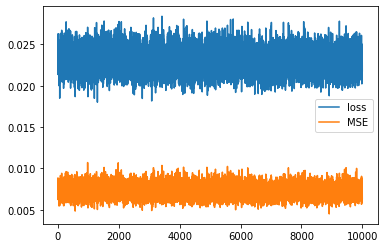

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


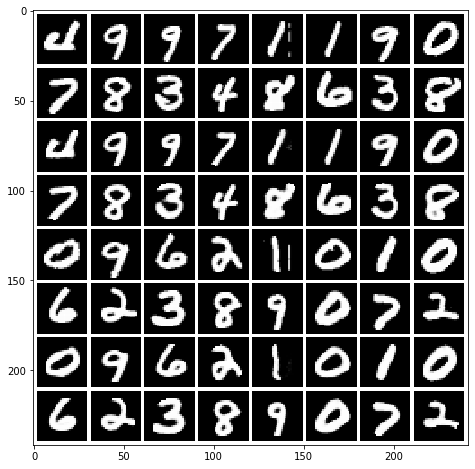

Mean squared dist: 0.007818495
epoch: 71 	 step:0 	 loss: 0.02181 	 reg loss: 0.001304
epoch: 71 	 step:100 	 loss: 0.02299 	 reg loss: 0.001353
epoch: 71 	 step:200 	 loss: 0.02261 	 reg loss: 0.001357
epoch: 71 	 step:300 	 loss: 0.02384 	 reg loss: 0.001325
epoch: 71 	 step:400 	 loss: 0.02169 	 reg loss: 0.001356
epoch: 71 	 step:500 	 loss: 0.02005 	 reg loss: 0.001341
epoch: 71 	 step:600 	 loss: 0.02143 	 reg loss: 0.001335
epoch: 71 	 step:700 	 loss: 0.02084 	 reg loss: 0.001287
epoch: 71 	 step:800 	 loss: 0.02079 	 reg loss: 0.001279
epoch: 71 	 step:900 	 loss: 0.02386 	 reg loss: 0.001377
epoch: 71 	 step:1000 	 loss: 0.02353 	 reg loss: 0.00136
epoch: 71 	 step:1100 	 loss: 0.02314 	 reg loss: 0.001315
epoch: 71 	 step:1200 	 loss: 0.02692 	 reg loss: 0.00137
epoch: 71 	 step:1300 	 loss: 0.02656 	 reg loss: 0.001362
epoch: 71 	 step:1400 	 loss: 0.02459 	 reg loss: 0.001367
epoch: 71 	 step:1500 	 loss: 0.02445 	 reg loss: 0.001398
epoch: 71 	 step:1600 	 loss: 0.02349 	

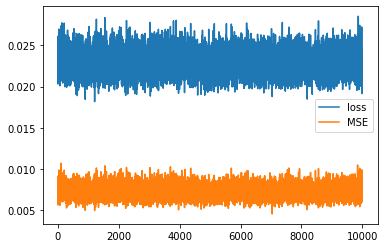

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


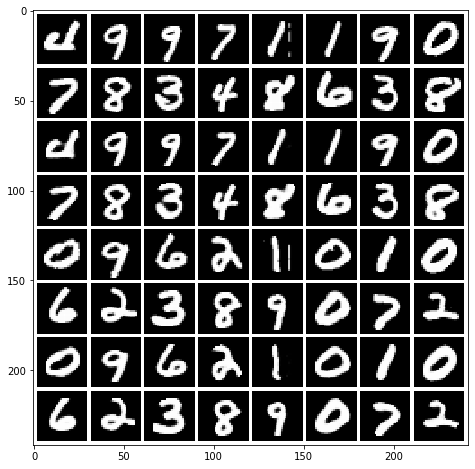

Mean squared dist: 0.007872293
epoch: 72 	 step:0 	 loss: 0.01983 	 reg loss: 0.001272
epoch: 72 	 step:100 	 loss: 0.02205 	 reg loss: 0.001301
epoch: 72 	 step:200 	 loss: 0.02546 	 reg loss: 0.001356
epoch: 72 	 step:300 	 loss: 0.02309 	 reg loss: 0.001285
epoch: 72 	 step:400 	 loss: 0.02136 	 reg loss: 0.001331
epoch: 72 	 step:500 	 loss: 0.02342 	 reg loss: 0.001374
epoch: 72 	 step:600 	 loss: 0.02387 	 reg loss: 0.001323
epoch: 72 	 step:700 	 loss: 0.02366 	 reg loss: 0.001398
epoch: 72 	 step:800 	 loss: 0.02219 	 reg loss: 0.001346
epoch: 72 	 step:900 	 loss: 0.02163 	 reg loss: 0.001311
epoch: 72 	 step:1000 	 loss: 0.02203 	 reg loss: 0.00129
epoch: 72 	 step:1100 	 loss: 0.02178 	 reg loss: 0.00134
epoch: 72 	 step:1200 	 loss: 0.02102 	 reg loss: 0.00132
epoch: 72 	 step:1300 	 loss: 0.02404 	 reg loss: 0.00131
epoch: 72 	 step:1400 	 loss: 0.0207 	 reg loss: 0.00133
epoch: 72 	 step:1500 	 loss: 0.02174 	 reg loss: 0.001327
epoch: 72 	 step:1600 	 loss: 0.02247 	 reg

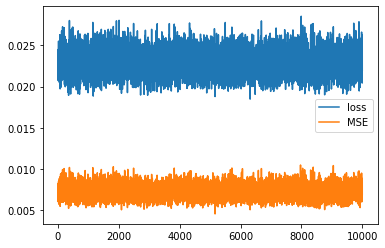

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


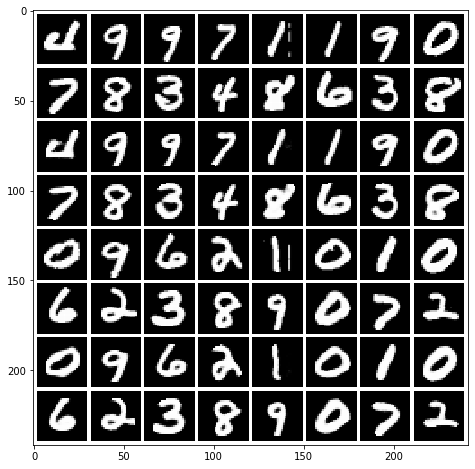

Mean squared dist: 0.007918047
epoch: 73 	 step:0 	 loss: 0.02243 	 reg loss: 0.001392
epoch: 73 	 step:100 	 loss: 0.0238 	 reg loss: 0.00138
epoch: 73 	 step:200 	 loss: 0.02155 	 reg loss: 0.001261
epoch: 73 	 step:300 	 loss: 0.02127 	 reg loss: 0.001346
epoch: 73 	 step:400 	 loss: 0.02556 	 reg loss: 0.001368
epoch: 73 	 step:500 	 loss: 0.02284 	 reg loss: 0.001326
epoch: 73 	 step:600 	 loss: 0.02288 	 reg loss: 0.001342
epoch: 73 	 step:700 	 loss: 0.02115 	 reg loss: 0.00129
epoch: 73 	 step:800 	 loss: 0.02137 	 reg loss: 0.001301
epoch: 73 	 step:900 	 loss: 0.0216 	 reg loss: 0.001334
epoch: 73 	 step:1000 	 loss: 0.02343 	 reg loss: 0.001385
epoch: 73 	 step:1100 	 loss: 0.02291 	 reg loss: 0.001373
epoch: 73 	 step:1200 	 loss: 0.0222 	 reg loss: 0.001323
epoch: 73 	 step:1300 	 loss: 0.02125 	 reg loss: 0.001264
epoch: 73 	 step:1400 	 loss: 0.02332 	 reg loss: 0.001337
epoch: 73 	 step:1500 	 loss: 0.02313 	 reg loss: 0.001347
epoch: 73 	 step:1600 	 loss: 0.02473 	 re

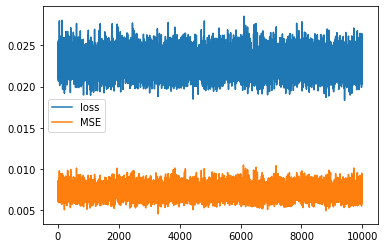

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


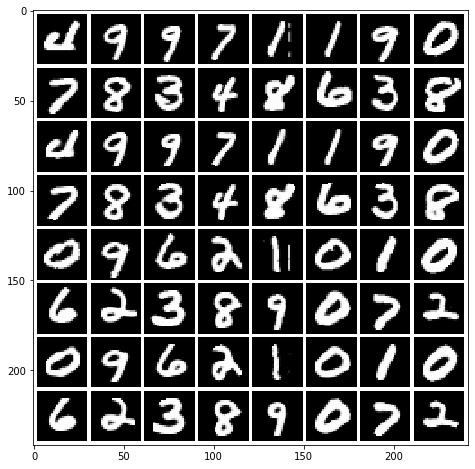

Mean squared dist: 0.007875584
epoch: 74 	 step:0 	 loss: 0.02273 	 reg loss: 0.001298
epoch: 74 	 step:100 	 loss: 0.02381 	 reg loss: 0.001376
epoch: 74 	 step:200 	 loss: 0.02368 	 reg loss: 0.001346
epoch: 74 	 step:300 	 loss: 0.02237 	 reg loss: 0.001306
epoch: 74 	 step:400 	 loss: 0.02161 	 reg loss: 0.001315
epoch: 74 	 step:500 	 loss: 0.02228 	 reg loss: 0.001264
epoch: 74 	 step:600 	 loss: 0.02566 	 reg loss: 0.001301
epoch: 74 	 step:700 	 loss: 0.0227 	 reg loss: 0.001298
epoch: 74 	 step:800 	 loss: 0.0229 	 reg loss: 0.001368
epoch: 74 	 step:900 	 loss: 0.02205 	 reg loss: 0.001304
epoch: 74 	 step:1000 	 loss: 0.0219 	 reg loss: 0.001323
epoch: 74 	 step:1100 	 loss: 0.02399 	 reg loss: 0.001366
epoch: 74 	 step:1200 	 loss: 0.02368 	 reg loss: 0.001387
epoch: 74 	 step:1300 	 loss: 0.02474 	 reg loss: 0.001341
epoch: 74 	 step:1400 	 loss: 0.02579 	 reg loss: 0.001409
epoch: 74 	 step:1500 	 loss: 0.02197 	 reg loss: 0.001347
epoch: 74 	 step:1600 	 loss: 0.02305 	 

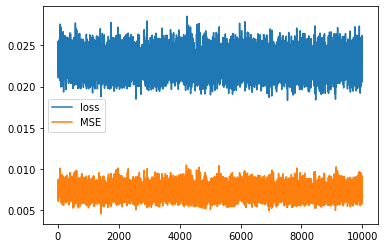

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


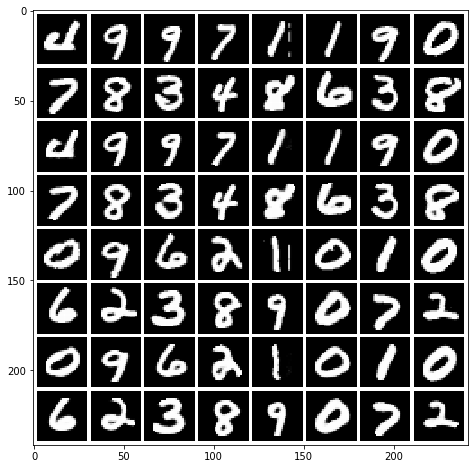

Mean squared dist: 0.0077695088
epoch: 75 	 step:0 	 loss: 0.02405 	 reg loss: 0.001343
epoch: 75 	 step:100 	 loss: 0.02271 	 reg loss: 0.001394
epoch: 75 	 step:200 	 loss: 0.02262 	 reg loss: 0.001373
epoch: 75 	 step:300 	 loss: 0.02362 	 reg loss: 0.001358
epoch: 75 	 step:400 	 loss: 0.0214 	 reg loss: 0.00136
epoch: 75 	 step:500 	 loss: 0.02275 	 reg loss: 0.001324
epoch: 75 	 step:600 	 loss: 0.02257 	 reg loss: 0.001309
epoch: 75 	 step:700 	 loss: 0.02358 	 reg loss: 0.001361
epoch: 75 	 step:800 	 loss: 0.02552 	 reg loss: 0.001343
epoch: 75 	 step:900 	 loss: 0.02209 	 reg loss: 0.00136
epoch: 75 	 step:1000 	 loss: 0.02318 	 reg loss: 0.001332
epoch: 75 	 step:1100 	 loss: 0.02165 	 reg loss: 0.001331
epoch: 75 	 step:1200 	 loss: 0.02056 	 reg loss: 0.001299
epoch: 75 	 step:1300 	 loss: 0.02292 	 reg loss: 0.001309
epoch: 75 	 step:1400 	 loss: 0.0191 	 reg loss: 0.001262
epoch: 75 	 step:1500 	 loss: 0.02262 	 reg loss: 0.001314
epoch: 75 	 step:1600 	 loss: 0.02224 	 

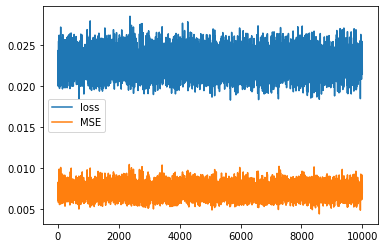

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


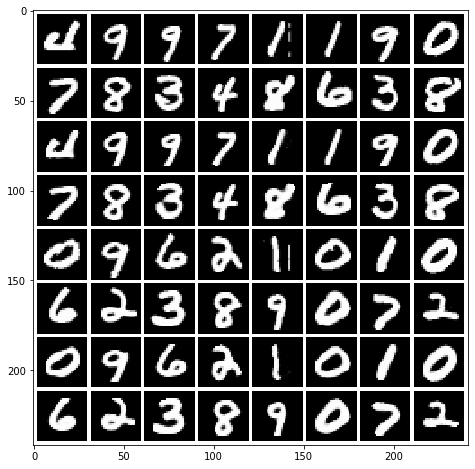

Mean squared dist: 0.007877212
epoch: 76 	 step:0 	 loss: 0.02191 	 reg loss: 0.001269
epoch: 76 	 step:100 	 loss: 0.02362 	 reg loss: 0.001324
epoch: 76 	 step:200 	 loss: 0.02215 	 reg loss: 0.001332
epoch: 76 	 step:300 	 loss: 0.02437 	 reg loss: 0.001391
epoch: 76 	 step:400 	 loss: 0.02211 	 reg loss: 0.001296
epoch: 76 	 step:500 	 loss: 0.02253 	 reg loss: 0.001339
epoch: 76 	 step:600 	 loss: 0.02182 	 reg loss: 0.001363
epoch: 76 	 step:700 	 loss: 0.02342 	 reg loss: 0.001291
epoch: 76 	 step:800 	 loss: 0.02374 	 reg loss: 0.00133
epoch: 76 	 step:900 	 loss: 0.02147 	 reg loss: 0.001261
epoch: 76 	 step:1000 	 loss: 0.02284 	 reg loss: 0.001278
epoch: 76 	 step:1100 	 loss: 0.02183 	 reg loss: 0.001284
epoch: 76 	 step:1200 	 loss: 0.02122 	 reg loss: 0.001309
epoch: 76 	 step:1300 	 loss: 0.02335 	 reg loss: 0.001343
epoch: 76 	 step:1400 	 loss: 0.01997 	 reg loss: 0.001345
epoch: 76 	 step:1500 	 loss: 0.02653 	 reg loss: 0.001359
epoch: 76 	 step:1600 	 loss: 0.02023 

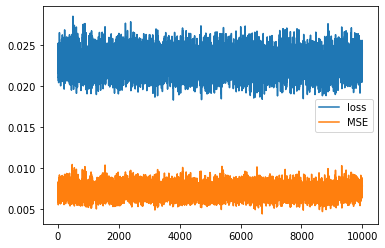

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


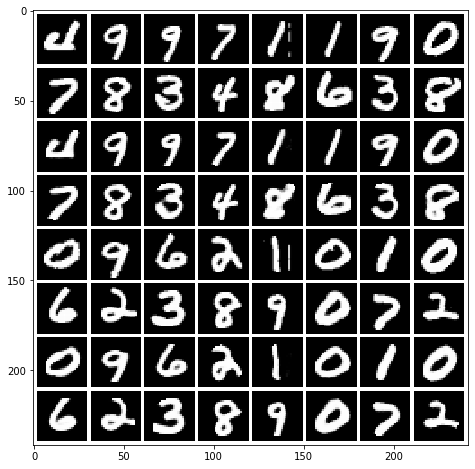

Mean squared dist: 0.0077490434
epoch: 77 	 step:0 	 loss: 0.01954 	 reg loss: 0.001285
epoch: 77 	 step:100 	 loss: 0.02076 	 reg loss: 0.001313
epoch: 77 	 step:200 	 loss: 0.02287 	 reg loss: 0.001336
epoch: 77 	 step:300 	 loss: 0.0224 	 reg loss: 0.00138
epoch: 77 	 step:400 	 loss: 0.02081 	 reg loss: 0.001296
epoch: 77 	 step:500 	 loss: 0.02173 	 reg loss: 0.001303
epoch: 77 	 step:600 	 loss: 0.02448 	 reg loss: 0.001383
epoch: 77 	 step:700 	 loss: 0.02092 	 reg loss: 0.001261
epoch: 77 	 step:800 	 loss: 0.02456 	 reg loss: 0.001387
epoch: 77 	 step:900 	 loss: 0.02266 	 reg loss: 0.001348
epoch: 77 	 step:1000 	 loss: 0.02107 	 reg loss: 0.001345
epoch: 77 	 step:1100 	 loss: 0.02462 	 reg loss: 0.001385
epoch: 77 	 step:1200 	 loss: 0.02333 	 reg loss: 0.00134
epoch: 77 	 step:1300 	 loss: 0.0228 	 reg loss: 0.001366
epoch: 77 	 step:1400 	 loss: 0.02201 	 reg loss: 0.001307
epoch: 77 	 step:1500 	 loss: 0.02056 	 reg loss: 0.001317
epoch: 77 	 step:1600 	 loss: 0.0236 	 r

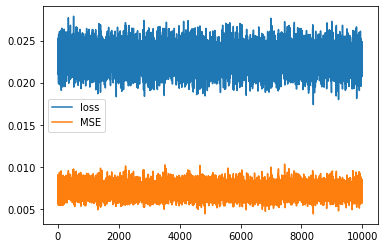

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


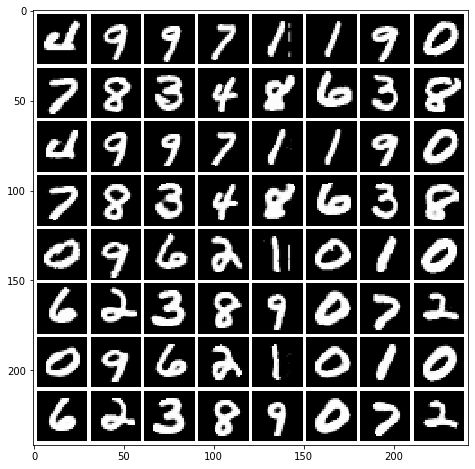

Mean squared dist: 0.007877404
epoch: 78 	 step:0 	 loss: 0.02213 	 reg loss: 0.00133
epoch: 78 	 step:100 	 loss: 0.02346 	 reg loss: 0.001362
epoch: 78 	 step:200 	 loss: 0.02243 	 reg loss: 0.00129
epoch: 78 	 step:300 	 loss: 0.02343 	 reg loss: 0.001324
epoch: 78 	 step:400 	 loss: 0.023 	 reg loss: 0.001387
epoch: 78 	 step:500 	 loss: 0.02397 	 reg loss: 0.001433
epoch: 78 	 step:600 	 loss: 0.02083 	 reg loss: 0.001304
epoch: 78 	 step:700 	 loss: 0.02196 	 reg loss: 0.001282
epoch: 78 	 step:800 	 loss: 0.02612 	 reg loss: 0.001406
epoch: 78 	 step:900 	 loss: 0.02518 	 reg loss: 0.001375
epoch: 78 	 step:1000 	 loss: 0.02348 	 reg loss: 0.001324
epoch: 78 	 step:1100 	 loss: 0.02233 	 reg loss: 0.001304
epoch: 78 	 step:1200 	 loss: 0.02194 	 reg loss: 0.001363
epoch: 78 	 step:1300 	 loss: 0.02069 	 reg loss: 0.001258
epoch: 78 	 step:1400 	 loss: 0.02428 	 reg loss: 0.001355
epoch: 78 	 step:1500 	 loss: 0.0209 	 reg loss: 0.001314
epoch: 78 	 step:1600 	 loss: 0.02274 	 re

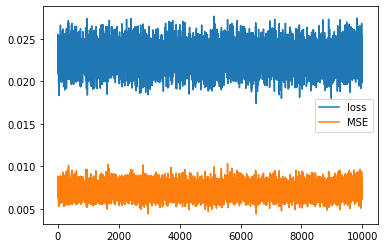

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


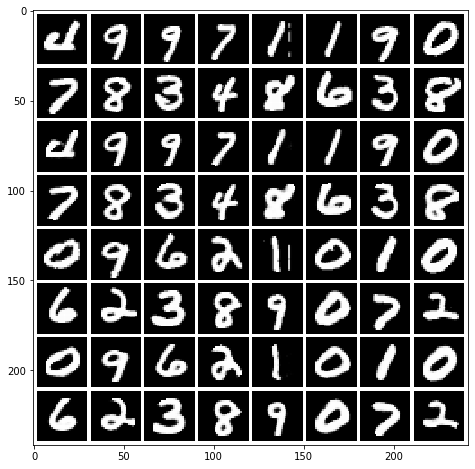

Mean squared dist: 0.007900004
epoch: 79 	 step:0 	 loss: 0.02317 	 reg loss: 0.001295
epoch: 79 	 step:100 	 loss: 0.02355 	 reg loss: 0.001356
epoch: 79 	 step:200 	 loss: 0.02393 	 reg loss: 0.001421
epoch: 79 	 step:300 	 loss: 0.02297 	 reg loss: 0.001341
epoch: 79 	 step:400 	 loss: 0.02083 	 reg loss: 0.001325
epoch: 79 	 step:500 	 loss: 0.02086 	 reg loss: 0.001271
epoch: 79 	 step:600 	 loss: 0.02107 	 reg loss: 0.00124
epoch: 79 	 step:700 	 loss: 0.02083 	 reg loss: 0.00127
epoch: 79 	 step:800 	 loss: 0.01962 	 reg loss: 0.00126
epoch: 79 	 step:900 	 loss: 0.02345 	 reg loss: 0.001355
epoch: 79 	 step:1000 	 loss: 0.0242 	 reg loss: 0.001361
epoch: 79 	 step:1100 	 loss: 0.02353 	 reg loss: 0.001283
epoch: 79 	 step:1200 	 loss: 0.02135 	 reg loss: 0.001306
epoch: 79 	 step:1300 	 loss: 0.02256 	 reg loss: 0.001352
epoch: 79 	 step:1400 	 loss: 0.02155 	 reg loss: 0.001345
epoch: 79 	 step:1500 	 loss: 0.02395 	 reg loss: 0.001338
epoch: 79 	 step:1600 	 loss: 0.02006 	 r

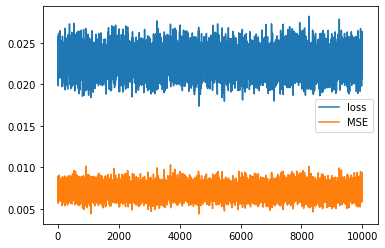

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


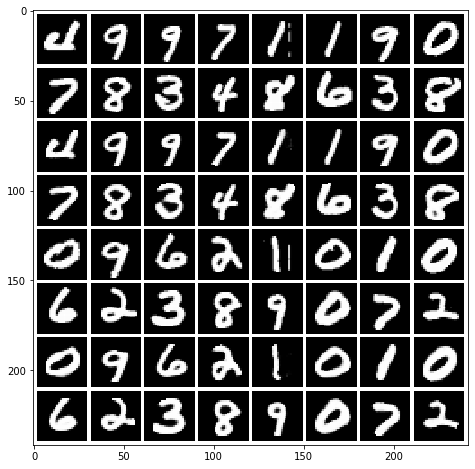

Mean squared dist: 0.007779283
epoch: 80 	 step:0 	 loss: 0.02206 	 reg loss: 0.001265
epoch: 80 	 step:100 	 loss: 0.02381 	 reg loss: 0.001346
epoch: 80 	 step:200 	 loss: 0.01944 	 reg loss: 0.001302
epoch: 80 	 step:300 	 loss: 0.02254 	 reg loss: 0.001316
epoch: 80 	 step:400 	 loss: 0.02282 	 reg loss: 0.001406
epoch: 80 	 step:500 	 loss: 0.02209 	 reg loss: 0.001288
epoch: 80 	 step:600 	 loss: 0.02375 	 reg loss: 0.001361
epoch: 80 	 step:700 	 loss: 0.02144 	 reg loss: 0.001342
epoch: 80 	 step:800 	 loss: 0.02248 	 reg loss: 0.001337
epoch: 80 	 step:900 	 loss: 0.02097 	 reg loss: 0.001287
epoch: 80 	 step:1000 	 loss: 0.02252 	 reg loss: 0.001288
epoch: 80 	 step:1100 	 loss: 0.01928 	 reg loss: 0.001275
epoch: 80 	 step:1200 	 loss: 0.02322 	 reg loss: 0.001382
epoch: 80 	 step:1300 	 loss: 0.02378 	 reg loss: 0.001294
epoch: 80 	 step:1400 	 loss: 0.02 	 reg loss: 0.001302
epoch: 80 	 step:1500 	 loss: 0.02543 	 reg loss: 0.001373
epoch: 80 	 step:1600 	 loss: 0.02204 	 

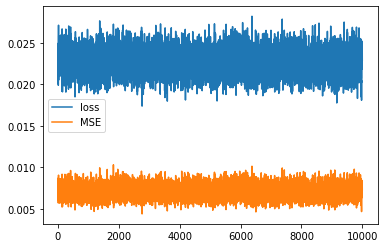

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


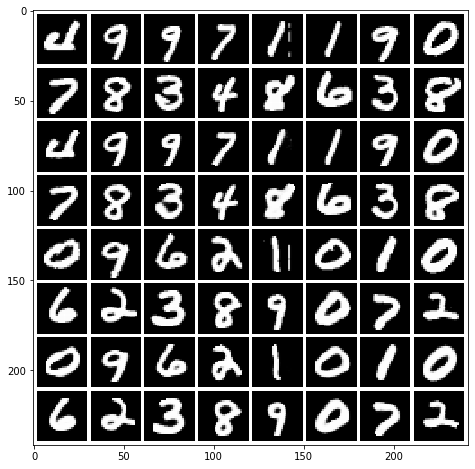

Mean squared dist: 0.0078027393
epoch: 81 	 step:0 	 loss: 0.02046 	 reg loss: 0.001265
epoch: 81 	 step:100 	 loss: 0.0237 	 reg loss: 0.00133
epoch: 81 	 step:200 	 loss: 0.02271 	 reg loss: 0.001312
epoch: 81 	 step:300 	 loss: 0.02259 	 reg loss: 0.001313
epoch: 81 	 step:400 	 loss: 0.02402 	 reg loss: 0.001372
epoch: 81 	 step:500 	 loss: 0.02491 	 reg loss: 0.001368
epoch: 81 	 step:600 	 loss: 0.02211 	 reg loss: 0.001348
epoch: 81 	 step:700 	 loss: 0.02338 	 reg loss: 0.001362
epoch: 81 	 step:800 	 loss: 0.02172 	 reg loss: 0.001292
epoch: 81 	 step:900 	 loss: 0.02022 	 reg loss: 0.001257
epoch: 81 	 step:1000 	 loss: 0.01987 	 reg loss: 0.001207
epoch: 81 	 step:1100 	 loss: 0.02263 	 reg loss: 0.001345
epoch: 81 	 step:1200 	 loss: 0.02104 	 reg loss: 0.001367
epoch: 81 	 step:1300 	 loss: 0.02155 	 reg loss: 0.001297
epoch: 81 	 step:1400 	 loss: 0.02181 	 reg loss: 0.001316
epoch: 81 	 step:1500 	 loss: 0.02325 	 reg loss: 0.001326
epoch: 81 	 step:1600 	 loss: 0.02229 

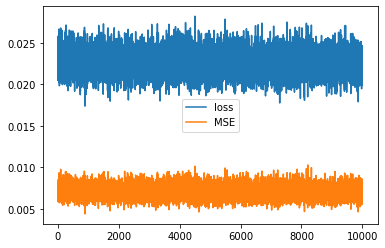

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


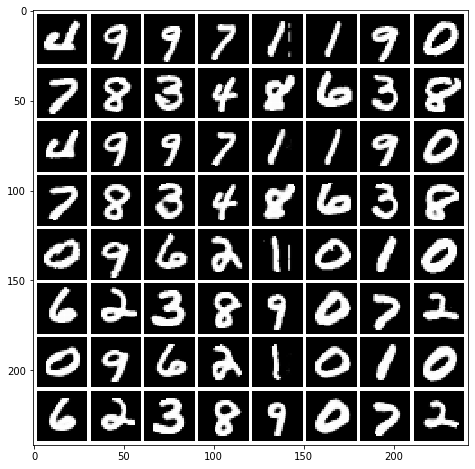

Mean squared dist: 0.0076737725
epoch: 82 	 step:0 	 loss: 0.02081 	 reg loss: 0.001318
epoch: 82 	 step:100 	 loss: 0.02279 	 reg loss: 0.001348
epoch: 82 	 step:200 	 loss: 0.02528 	 reg loss: 0.001369
epoch: 82 	 step:300 	 loss: 0.02246 	 reg loss: 0.001306
epoch: 82 	 step:400 	 loss: 0.0221 	 reg loss: 0.001321
epoch: 82 	 step:500 	 loss: 0.02034 	 reg loss: 0.001285
epoch: 82 	 step:600 	 loss: 0.02168 	 reg loss: 0.001342
epoch: 82 	 step:700 	 loss: 0.02228 	 reg loss: 0.001342
epoch: 82 	 step:800 	 loss: 0.02319 	 reg loss: 0.001348
epoch: 82 	 step:900 	 loss: 0.02119 	 reg loss: 0.001328
epoch: 82 	 step:1000 	 loss: 0.01964 	 reg loss: 0.001285
epoch: 82 	 step:1100 	 loss: 0.02206 	 reg loss: 0.001296
epoch: 82 	 step:1200 	 loss: 0.02212 	 reg loss: 0.001325
epoch: 82 	 step:1300 	 loss: 0.02383 	 reg loss: 0.001329
epoch: 82 	 step:1400 	 loss: 0.02185 	 reg loss: 0.001314
epoch: 82 	 step:1500 	 loss: 0.02231 	 reg loss: 0.001313
epoch: 82 	 step:1600 	 loss: 0.02328

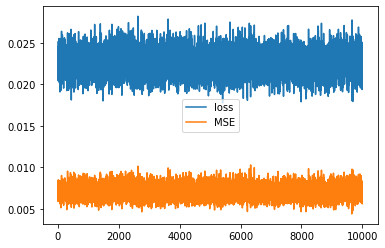

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


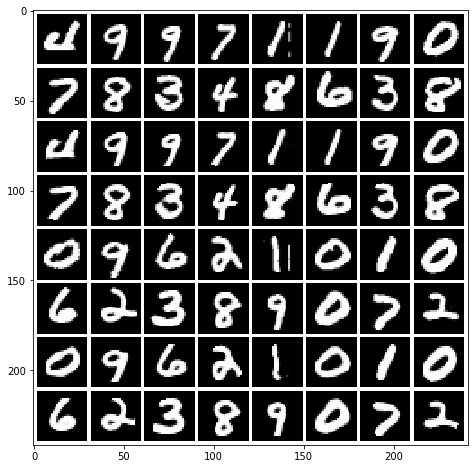

Mean squared dist: 0.0077214474
epoch: 83 	 step:0 	 loss: 0.0251 	 reg loss: 0.001381
epoch: 83 	 step:100 	 loss: 0.02174 	 reg loss: 0.001275
epoch: 83 	 step:200 	 loss: 0.02164 	 reg loss: 0.001277
epoch: 83 	 step:300 	 loss: 0.0237 	 reg loss: 0.001403
epoch: 83 	 step:400 	 loss: 0.02323 	 reg loss: 0.001278
epoch: 83 	 step:500 	 loss: 0.01995 	 reg loss: 0.001274
epoch: 83 	 step:600 	 loss: 0.02103 	 reg loss: 0.001279
epoch: 83 	 step:700 	 loss: 0.02361 	 reg loss: 0.001334
epoch: 83 	 step:800 	 loss: 0.02388 	 reg loss: 0.001358
epoch: 83 	 step:900 	 loss: 0.02461 	 reg loss: 0.001342
epoch: 83 	 step:1000 	 loss: 0.02465 	 reg loss: 0.001341
epoch: 83 	 step:1100 	 loss: 0.01986 	 reg loss: 0.001226
epoch: 83 	 step:1200 	 loss: 0.02295 	 reg loss: 0.001305
epoch: 83 	 step:1300 	 loss: 0.02356 	 reg loss: 0.001331
epoch: 83 	 step:1400 	 loss: 0.0199 	 reg loss: 0.001241
epoch: 83 	 step:1500 	 loss: 0.02491 	 reg loss: 0.001366
epoch: 83 	 step:1600 	 loss: 0.02106 	

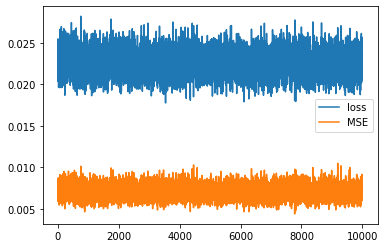

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


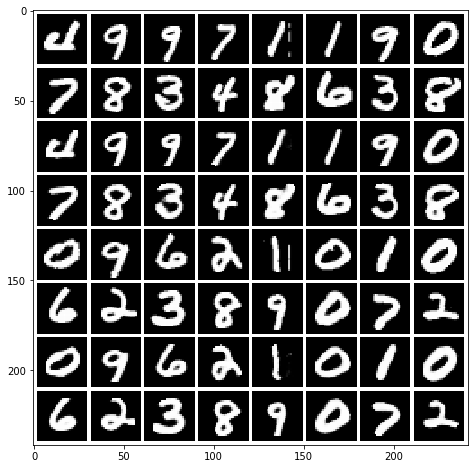

Mean squared dist: 0.0077016284
epoch: 84 	 step:0 	 loss: 0.02136 	 reg loss: 0.001299
epoch: 84 	 step:100 	 loss: 0.02456 	 reg loss: 0.001366
epoch: 84 	 step:200 	 loss: 0.02291 	 reg loss: 0.001304
epoch: 84 	 step:300 	 loss: 0.02285 	 reg loss: 0.00136
epoch: 84 	 step:400 	 loss: 0.02156 	 reg loss: 0.001273
epoch: 84 	 step:500 	 loss: 0.02134 	 reg loss: 0.001272
epoch: 84 	 step:600 	 loss: 0.02112 	 reg loss: 0.001259
epoch: 84 	 step:700 	 loss: 0.02099 	 reg loss: 0.001303
epoch: 84 	 step:800 	 loss: 0.02236 	 reg loss: 0.001321
epoch: 84 	 step:900 	 loss: 0.0226 	 reg loss: 0.001272
epoch: 84 	 step:1000 	 loss: 0.02222 	 reg loss: 0.00132
epoch: 84 	 step:1100 	 loss: 0.02308 	 reg loss: 0.001352
epoch: 84 	 step:1200 	 loss: 0.02284 	 reg loss: 0.001297
epoch: 84 	 step:1300 	 loss: 0.02076 	 reg loss: 0.001291
epoch: 84 	 step:1400 	 loss: 0.0267 	 reg loss: 0.001324
epoch: 84 	 step:1500 	 loss: 0.02327 	 reg loss: 0.001361
epoch: 84 	 step:1600 	 loss: 0.02332 	 

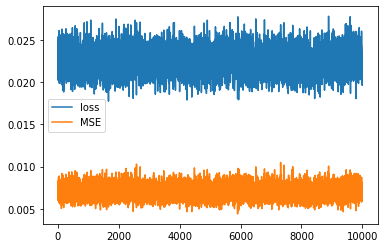

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


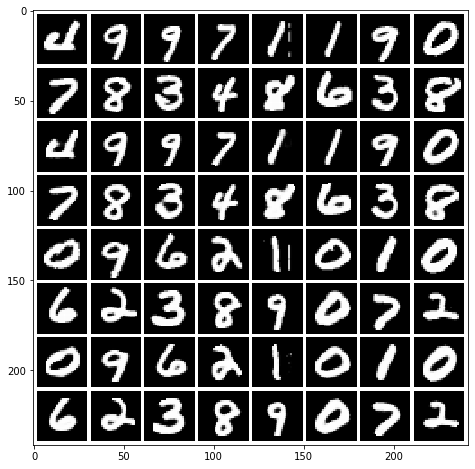

Mean squared dist: 0.0076445094
epoch: 85 	 step:0 	 loss: 0.02507 	 reg loss: 0.001336
epoch: 85 	 step:100 	 loss: 0.02266 	 reg loss: 0.001295
epoch: 85 	 step:200 	 loss: 0.02057 	 reg loss: 0.001281
epoch: 85 	 step:300 	 loss: 0.02019 	 reg loss: 0.001256
epoch: 85 	 step:400 	 loss: 0.02269 	 reg loss: 0.001363
epoch: 85 	 step:500 	 loss: 0.02265 	 reg loss: 0.001279
epoch: 85 	 step:600 	 loss: 0.02243 	 reg loss: 0.00132
epoch: 85 	 step:700 	 loss: 0.02096 	 reg loss: 0.001291
epoch: 85 	 step:800 	 loss: 0.02494 	 reg loss: 0.001322
epoch: 85 	 step:900 	 loss: 0.02217 	 reg loss: 0.001305
epoch: 85 	 step:1000 	 loss: 0.0245 	 reg loss: 0.001375
epoch: 85 	 step:1100 	 loss: 0.02155 	 reg loss: 0.001294
epoch: 85 	 step:1200 	 loss: 0.0207 	 reg loss: 0.001303
epoch: 85 	 step:1300 	 loss: 0.02521 	 reg loss: 0.001339
epoch: 85 	 step:1400 	 loss: 0.02286 	 reg loss: 0.001319
epoch: 85 	 step:1500 	 loss: 0.02392 	 reg loss: 0.001325
epoch: 85 	 step:1600 	 loss: 0.02163 	

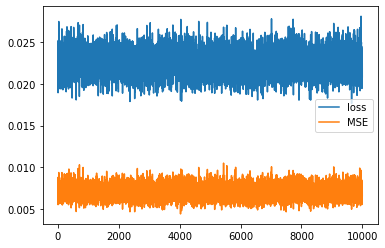

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


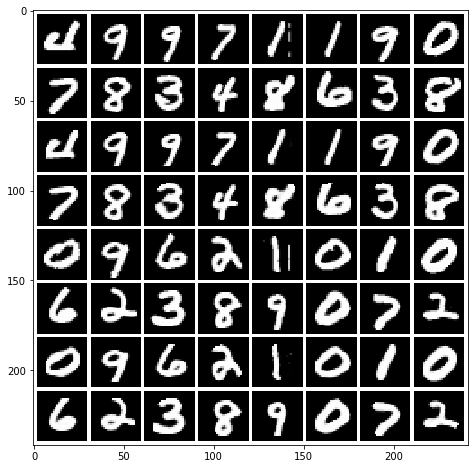

Mean squared dist: 0.0076824715
epoch: 86 	 step:0 	 loss: 0.02196 	 reg loss: 0.001289
epoch: 86 	 step:100 	 loss: 0.02191 	 reg loss: 0.001302
epoch: 86 	 step:200 	 loss: 0.02038 	 reg loss: 0.001252
epoch: 86 	 step:300 	 loss: 0.02278 	 reg loss: 0.001336
epoch: 86 	 step:400 	 loss: 0.023 	 reg loss: 0.001302
epoch: 86 	 step:500 	 loss: 0.02051 	 reg loss: 0.001298
epoch: 86 	 step:600 	 loss: 0.02123 	 reg loss: 0.001317
epoch: 86 	 step:700 	 loss: 0.0218 	 reg loss: 0.001357
epoch: 86 	 step:800 	 loss: 0.02271 	 reg loss: 0.001308
epoch: 86 	 step:900 	 loss: 0.0245 	 reg loss: 0.001354
epoch: 86 	 step:1000 	 loss: 0.02084 	 reg loss: 0.001326
epoch: 86 	 step:1100 	 loss: 0.02313 	 reg loss: 0.001339
epoch: 86 	 step:1200 	 loss: 0.02224 	 reg loss: 0.00131
epoch: 86 	 step:1300 	 loss: 0.022 	 reg loss: 0.001299
epoch: 86 	 step:1400 	 loss: 0.02358 	 reg loss: 0.001328
epoch: 86 	 step:1500 	 loss: 0.02326 	 reg loss: 0.001349
epoch: 86 	 step:1600 	 loss: 0.02293 	 reg

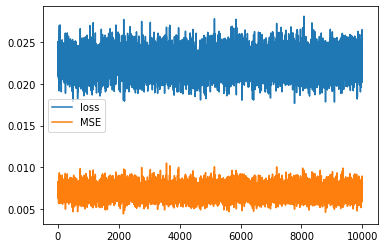

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


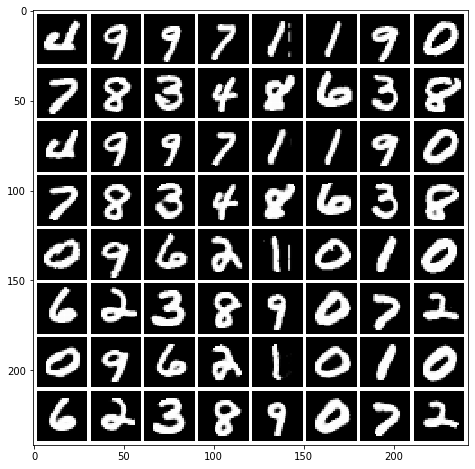

Mean squared dist: 0.0077922274
epoch: 87 	 step:0 	 loss: 0.02115 	 reg loss: 0.001302
epoch: 87 	 step:100 	 loss: 0.02304 	 reg loss: 0.001361
epoch: 87 	 step:200 	 loss: 0.02268 	 reg loss: 0.001336
epoch: 87 	 step:300 	 loss: 0.02312 	 reg loss: 0.001331
epoch: 87 	 step:400 	 loss: 0.01977 	 reg loss: 0.001307
epoch: 87 	 step:500 	 loss: 0.02331 	 reg loss: 0.001319
epoch: 87 	 step:600 	 loss: 0.02577 	 reg loss: 0.001337
epoch: 87 	 step:700 	 loss: 0.01989 	 reg loss: 0.001246
epoch: 87 	 step:800 	 loss: 0.02346 	 reg loss: 0.001321
epoch: 87 	 step:900 	 loss: 0.025 	 reg loss: 0.001357
epoch: 87 	 step:1000 	 loss: 0.02397 	 reg loss: 0.00139
epoch: 87 	 step:1100 	 loss: 0.02004 	 reg loss: 0.001234
epoch: 87 	 step:1200 	 loss: 0.02301 	 reg loss: 0.001312
epoch: 87 	 step:1300 	 loss: 0.02467 	 reg loss: 0.001319
epoch: 87 	 step:1400 	 loss: 0.02306 	 reg loss: 0.00132
epoch: 87 	 step:1500 	 loss: 0.02337 	 reg loss: 0.001349
epoch: 87 	 step:1600 	 loss: 0.02196 	 

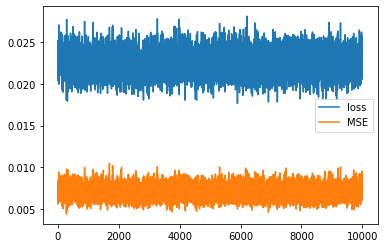

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


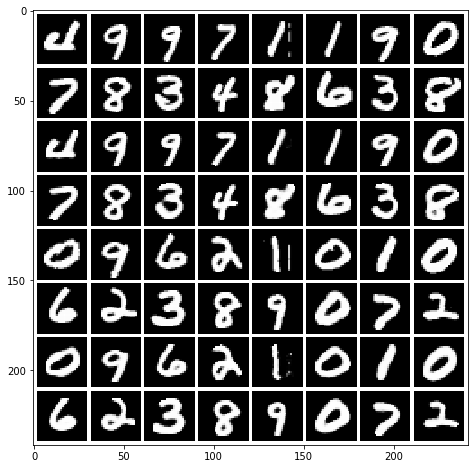

Mean squared dist: 0.00773821
epoch: 88 	 step:0 	 loss: 0.02343 	 reg loss: 0.001316
epoch: 88 	 step:100 	 loss: 0.02348 	 reg loss: 0.001401
epoch: 88 	 step:200 	 loss: 0.02431 	 reg loss: 0.001351
epoch: 88 	 step:300 	 loss: 0.02367 	 reg loss: 0.00134
epoch: 88 	 step:400 	 loss: 0.02129 	 reg loss: 0.001306
epoch: 88 	 step:500 	 loss: 0.02338 	 reg loss: 0.001377
epoch: 88 	 step:600 	 loss: 0.02082 	 reg loss: 0.001273
epoch: 88 	 step:700 	 loss: 0.02308 	 reg loss: 0.001298
epoch: 88 	 step:800 	 loss: 0.0216 	 reg loss: 0.001307
epoch: 88 	 step:900 	 loss: 0.02406 	 reg loss: 0.001364
epoch: 88 	 step:1000 	 loss: 0.02244 	 reg loss: 0.001349
epoch: 88 	 step:1100 	 loss: 0.02082 	 reg loss: 0.001301
epoch: 88 	 step:1200 	 loss: 0.0223 	 reg loss: 0.001309
epoch: 88 	 step:1300 	 loss: 0.0217 	 reg loss: 0.001273
epoch: 88 	 step:1400 	 loss: 0.02399 	 reg loss: 0.0013
epoch: 88 	 step:1500 	 loss: 0.02339 	 reg loss: 0.001291
epoch: 88 	 step:1600 	 loss: 0.0224 	 reg l

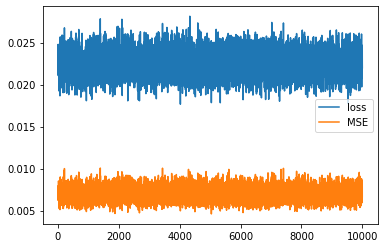

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


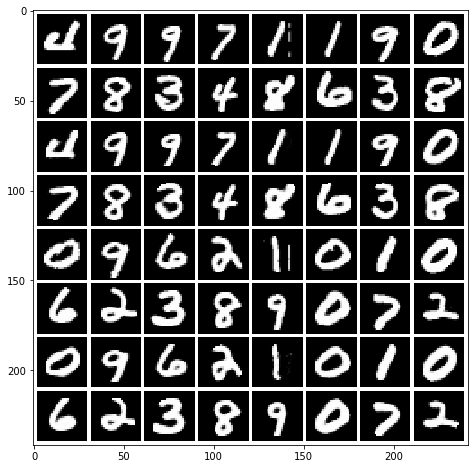

Mean squared dist: 0.0076245135
epoch: 89 	 step:0 	 loss: 0.02122 	 reg loss: 0.001287
epoch: 89 	 step:100 	 loss: 0.02169 	 reg loss: 0.00127
epoch: 89 	 step:200 	 loss: 0.02069 	 reg loss: 0.00126
epoch: 89 	 step:300 	 loss: 0.02186 	 reg loss: 0.001282
epoch: 89 	 step:400 	 loss: 0.02353 	 reg loss: 0.001386
epoch: 89 	 step:500 	 loss: 0.02218 	 reg loss: 0.001316
epoch: 89 	 step:600 	 loss: 0.02252 	 reg loss: 0.001321
epoch: 89 	 step:700 	 loss: 0.02 	 reg loss: 0.001283
epoch: 89 	 step:800 	 loss: 0.02383 	 reg loss: 0.001344
epoch: 89 	 step:900 	 loss: 0.02071 	 reg loss: 0.001266
epoch: 89 	 step:1000 	 loss: 0.02396 	 reg loss: 0.001266
epoch: 89 	 step:1100 	 loss: 0.02162 	 reg loss: 0.001272
epoch: 89 	 step:1200 	 loss: 0.02188 	 reg loss: 0.00131
epoch: 89 	 step:1300 	 loss: 0.02127 	 reg loss: 0.001256
epoch: 89 	 step:1400 	 loss: 0.02454 	 reg loss: 0.001314
epoch: 89 	 step:1500 	 loss: 0.02254 	 reg loss: 0.001264
epoch: 89 	 step:1600 	 loss: 0.0224 	 reg

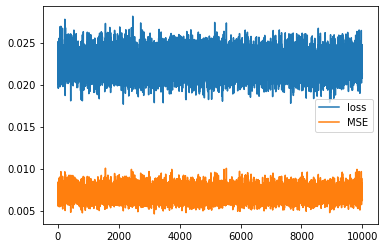

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


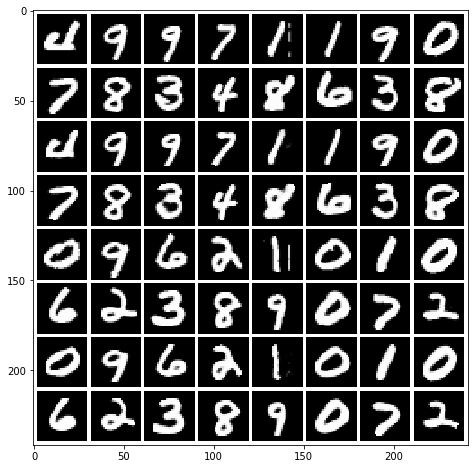

Mean squared dist: 0.007812057
epoch: 90 	 step:0 	 loss: 0.02101 	 reg loss: 0.001272
epoch: 90 	 step:100 	 loss: 0.02441 	 reg loss: 0.001314
epoch: 90 	 step:200 	 loss: 0.02047 	 reg loss: 0.00126
epoch: 90 	 step:300 	 loss: 0.02074 	 reg loss: 0.001257
epoch: 90 	 step:400 	 loss: 0.02061 	 reg loss: 0.001256
epoch: 90 	 step:500 	 loss: 0.02322 	 reg loss: 0.001363
epoch: 90 	 step:600 	 loss: 0.02248 	 reg loss: 0.001301
epoch: 90 	 step:700 	 loss: 0.02213 	 reg loss: 0.001287
epoch: 90 	 step:800 	 loss: 0.02331 	 reg loss: 0.001286
epoch: 90 	 step:900 	 loss: 0.0215 	 reg loss: 0.001287
epoch: 90 	 step:1000 	 loss: 0.02057 	 reg loss: 0.001259
epoch: 90 	 step:1100 	 loss: 0.02377 	 reg loss: 0.001381
epoch: 90 	 step:1200 	 loss: 0.02108 	 reg loss: 0.001258
epoch: 90 	 step:1300 	 loss: 0.02263 	 reg loss: 0.001333
epoch: 90 	 step:1400 	 loss: 0.02211 	 reg loss: 0.001316
epoch: 90 	 step:1500 	 loss: 0.02482 	 reg loss: 0.00132
epoch: 90 	 step:1600 	 loss: 0.02001 	 

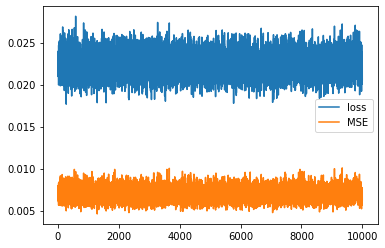

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


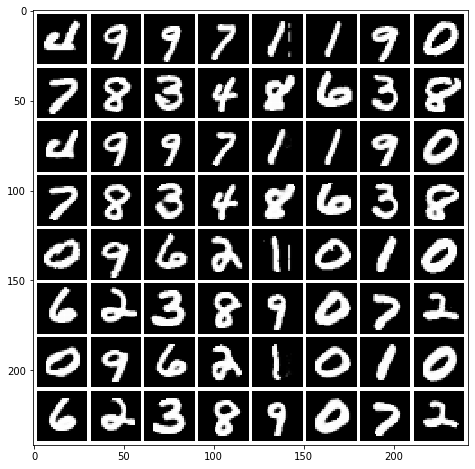

Mean squared dist: 0.0076621934
epoch: 91 	 step:0 	 loss: 0.0201 	 reg loss: 0.001254
epoch: 91 	 step:100 	 loss: 0.0209 	 reg loss: 0.001282
epoch: 91 	 step:200 	 loss: 0.02243 	 reg loss: 0.001337
epoch: 91 	 step:300 	 loss: 0.0207 	 reg loss: 0.001285
epoch: 91 	 step:400 	 loss: 0.02284 	 reg loss: 0.001294
epoch: 91 	 step:500 	 loss: 0.02371 	 reg loss: 0.001342
epoch: 91 	 step:600 	 loss: 0.02512 	 reg loss: 0.001328
epoch: 91 	 step:700 	 loss: 0.0238 	 reg loss: 0.001334
epoch: 91 	 step:800 	 loss: 0.023 	 reg loss: 0.001297
epoch: 91 	 step:900 	 loss: 0.02244 	 reg loss: 0.001351
epoch: 91 	 step:1000 	 loss: 0.0218 	 reg loss: 0.001304
epoch: 91 	 step:1100 	 loss: 0.02095 	 reg loss: 0.001283
epoch: 91 	 step:1200 	 loss: 0.02101 	 reg loss: 0.001307
epoch: 91 	 step:1300 	 loss: 0.02368 	 reg loss: 0.001265
epoch: 91 	 step:1400 	 loss: 0.02231 	 reg loss: 0.001287
epoch: 91 	 step:1500 	 loss: 0.02138 	 reg loss: 0.001302
epoch: 91 	 step:1600 	 loss: 0.02297 	 reg

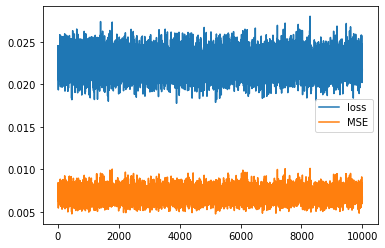

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


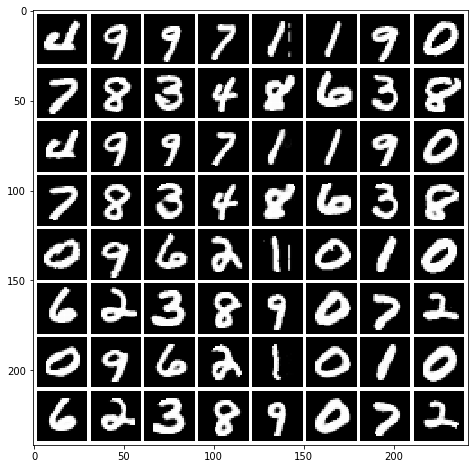

Mean squared dist: 0.0075594443
epoch: 92 	 step:0 	 loss: 0.02277 	 reg loss: 0.001339
epoch: 92 	 step:100 	 loss: 0.02054 	 reg loss: 0.001294
epoch: 92 	 step:200 	 loss: 0.02199 	 reg loss: 0.001304
epoch: 92 	 step:300 	 loss: 0.02206 	 reg loss: 0.001327
epoch: 92 	 step:400 	 loss: 0.02404 	 reg loss: 0.001273
epoch: 92 	 step:500 	 loss: 0.01818 	 reg loss: 0.001242
epoch: 92 	 step:600 	 loss: 0.02226 	 reg loss: 0.001295
epoch: 92 	 step:700 	 loss: 0.02394 	 reg loss: 0.001354
epoch: 92 	 step:800 	 loss: 0.02001 	 reg loss: 0.001283
epoch: 92 	 step:900 	 loss: 0.02274 	 reg loss: 0.0013
epoch: 92 	 step:1000 	 loss: 0.02132 	 reg loss: 0.001303
epoch: 92 	 step:1100 	 loss: 0.02091 	 reg loss: 0.001273
epoch: 92 	 step:1200 	 loss: 0.02178 	 reg loss: 0.001295
epoch: 92 	 step:1300 	 loss: 0.0209 	 reg loss: 0.001249
epoch: 92 	 step:1400 	 loss: 0.02366 	 reg loss: 0.001335
epoch: 92 	 step:1500 	 loss: 0.02113 	 reg loss: 0.001253
epoch: 92 	 step:1600 	 loss: 0.02351 	

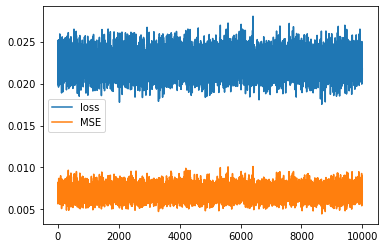

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


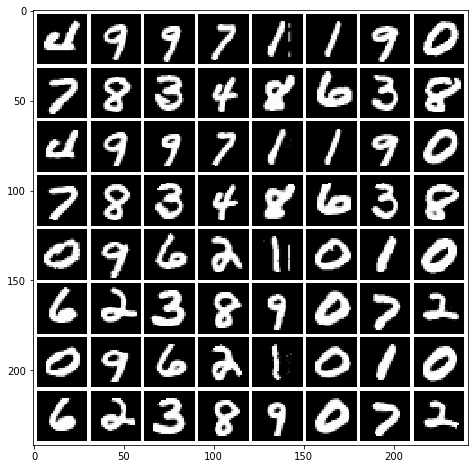

Mean squared dist: 0.007581606
epoch: 93 	 step:0 	 loss: 0.02379 	 reg loss: 0.001336
epoch: 93 	 step:100 	 loss: 0.02116 	 reg loss: 0.001258
epoch: 93 	 step:200 	 loss: 0.02139 	 reg loss: 0.00128
epoch: 93 	 step:300 	 loss: 0.02059 	 reg loss: 0.001274
epoch: 93 	 step:400 	 loss: 0.02053 	 reg loss: 0.001261
epoch: 93 	 step:500 	 loss: 0.02363 	 reg loss: 0.001283
epoch: 93 	 step:600 	 loss: 0.0218 	 reg loss: 0.001327
epoch: 93 	 step:700 	 loss: 0.02435 	 reg loss: 0.001311
epoch: 93 	 step:800 	 loss: 0.02334 	 reg loss: 0.001355
epoch: 93 	 step:900 	 loss: 0.02118 	 reg loss: 0.001307
epoch: 93 	 step:1000 	 loss: 0.02421 	 reg loss: 0.00136
epoch: 93 	 step:1100 	 loss: 0.02175 	 reg loss: 0.001275
epoch: 93 	 step:1200 	 loss: 0.02424 	 reg loss: 0.001278
epoch: 93 	 step:1300 	 loss: 0.02082 	 reg loss: 0.001288
epoch: 93 	 step:1400 	 loss: 0.02437 	 reg loss: 0.001286
epoch: 93 	 step:1500 	 loss: 0.02085 	 reg loss: 0.001374
epoch: 93 	 step:1600 	 loss: 0.02119 	 

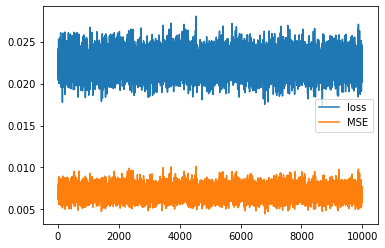

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


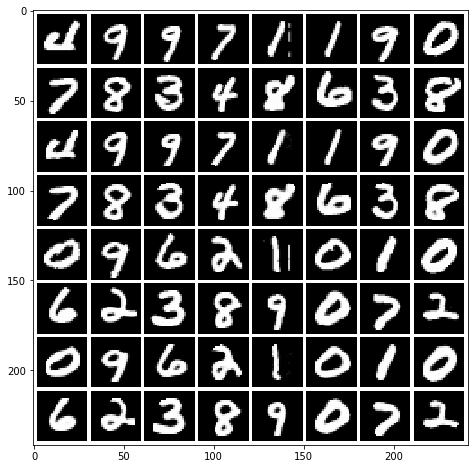

Mean squared dist: 0.007644358
epoch: 94 	 step:0 	 loss: 0.02355 	 reg loss: 0.001309
epoch: 94 	 step:100 	 loss: 0.02008 	 reg loss: 0.00129
epoch: 94 	 step:200 	 loss: 0.02325 	 reg loss: 0.001332
epoch: 94 	 step:300 	 loss: 0.02237 	 reg loss: 0.001251
epoch: 94 	 step:400 	 loss: 0.02156 	 reg loss: 0.001257
epoch: 94 	 step:500 	 loss: 0.02215 	 reg loss: 0.001278
epoch: 94 	 step:600 	 loss: 0.02147 	 reg loss: 0.001231
epoch: 94 	 step:700 	 loss: 0.02107 	 reg loss: 0.001264
epoch: 94 	 step:800 	 loss: 0.022 	 reg loss: 0.001283
epoch: 94 	 step:900 	 loss: 0.02314 	 reg loss: 0.001248
epoch: 94 	 step:1000 	 loss: 0.02335 	 reg loss: 0.001326
epoch: 94 	 step:1100 	 loss: 0.02301 	 reg loss: 0.0013
epoch: 94 	 step:1200 	 loss: 0.01942 	 reg loss: 0.001245
epoch: 94 	 step:1300 	 loss: 0.02242 	 reg loss: 0.001327
epoch: 94 	 step:1400 	 loss: 0.02295 	 reg loss: 0.001227
epoch: 94 	 step:1500 	 loss: 0.02194 	 reg loss: 0.001266
epoch: 94 	 step:1600 	 loss: 0.02251 	 re

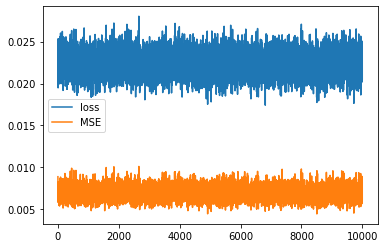

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


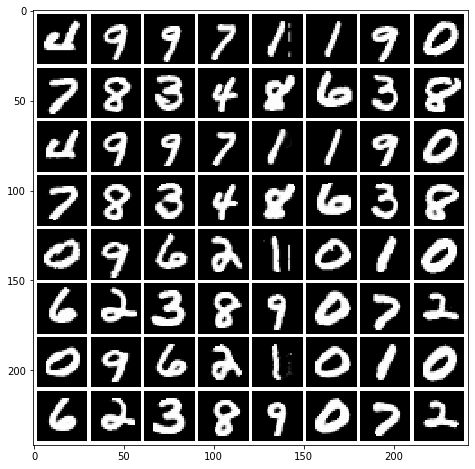

Mean squared dist: 0.0076746307
epoch: 95 	 step:0 	 loss: 0.02327 	 reg loss: 0.001309
epoch: 95 	 step:100 	 loss: 0.02327 	 reg loss: 0.001293
epoch: 95 	 step:200 	 loss: 0.02276 	 reg loss: 0.001312
epoch: 95 	 step:300 	 loss: 0.02117 	 reg loss: 0.001297
epoch: 95 	 step:400 	 loss: 0.02361 	 reg loss: 0.001318
epoch: 95 	 step:500 	 loss: 0.02075 	 reg loss: 0.001314
epoch: 95 	 step:600 	 loss: 0.0228 	 reg loss: 0.001281
epoch: 95 	 step:700 	 loss: 0.02131 	 reg loss: 0.001301
epoch: 95 	 step:800 	 loss: 0.02193 	 reg loss: 0.001278
epoch: 95 	 step:900 	 loss: 0.0215 	 reg loss: 0.001265
epoch: 95 	 step:1000 	 loss: 0.02124 	 reg loss: 0.001286
epoch: 95 	 step:1100 	 loss: 0.02386 	 reg loss: 0.001322
epoch: 95 	 step:1200 	 loss: 0.0222 	 reg loss: 0.001307
epoch: 95 	 step:1300 	 loss: 0.02158 	 reg loss: 0.001254
epoch: 95 	 step:1400 	 loss: 0.02192 	 reg loss: 0.001285
epoch: 95 	 step:1500 	 loss: 0.02108 	 reg loss: 0.001285
epoch: 95 	 step:1600 	 loss: 0.0233 	 

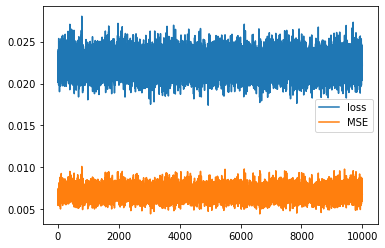

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


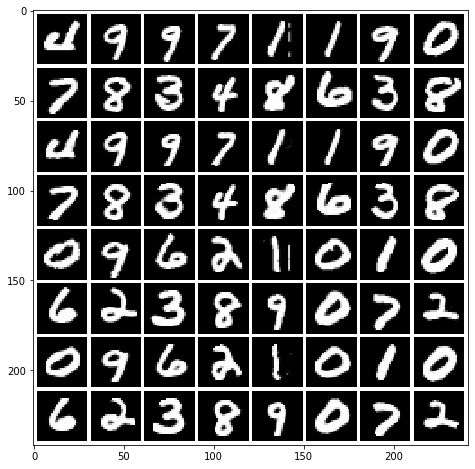

Mean squared dist: 0.0076450645
epoch: 96 	 step:0 	 loss: 0.01914 	 reg loss: 0.001292
epoch: 96 	 step:100 	 loss: 0.02164 	 reg loss: 0.001233
epoch: 96 	 step:200 	 loss: 0.02013 	 reg loss: 0.001276
epoch: 96 	 step:300 	 loss: 0.02194 	 reg loss: 0.00126
epoch: 96 	 step:400 	 loss: 0.01864 	 reg loss: 0.001273
epoch: 96 	 step:500 	 loss: 0.02298 	 reg loss: 0.001257
epoch: 96 	 step:600 	 loss: 0.02094 	 reg loss: 0.001324
epoch: 96 	 step:700 	 loss: 0.02493 	 reg loss: 0.001298
epoch: 96 	 step:800 	 loss: 0.02318 	 reg loss: 0.001319
epoch: 96 	 step:900 	 loss: 0.02312 	 reg loss: 0.001293
epoch: 96 	 step:1000 	 loss: 0.02161 	 reg loss: 0.001286
epoch: 96 	 step:1100 	 loss: 0.02339 	 reg loss: 0.00132
epoch: 96 	 step:1200 	 loss: 0.02204 	 reg loss: 0.001295
epoch: 96 	 step:1300 	 loss: 0.0252 	 reg loss: 0.001336
epoch: 96 	 step:1400 	 loss: 0.02302 	 reg loss: 0.001296
epoch: 96 	 step:1500 	 loss: 0.02195 	 reg loss: 0.001338
epoch: 96 	 step:1600 	 loss: 0.02168 	

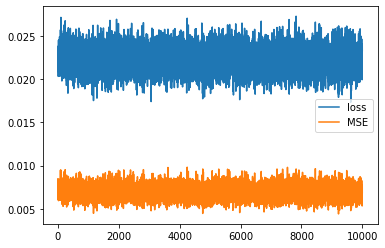

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


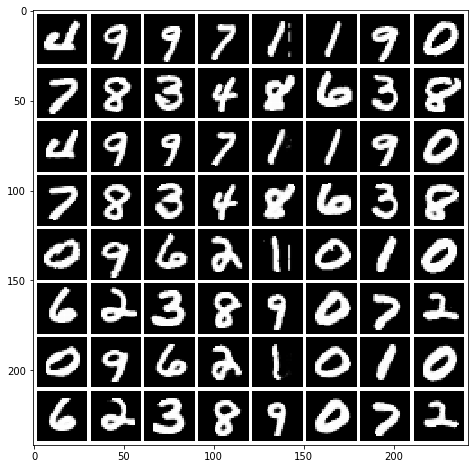

Mean squared dist: 0.0075215823
epoch: 97 	 step:0 	 loss: 0.02041 	 reg loss: 0.001256
epoch: 97 	 step:100 	 loss: 0.02216 	 reg loss: 0.001321
epoch: 97 	 step:200 	 loss: 0.01957 	 reg loss: 0.001249
epoch: 97 	 step:300 	 loss: 0.0202 	 reg loss: 0.001265
epoch: 97 	 step:400 	 loss: 0.02228 	 reg loss: 0.001251
epoch: 97 	 step:500 	 loss: 0.02144 	 reg loss: 0.001282
epoch: 97 	 step:600 	 loss: 0.02125 	 reg loss: 0.001262
epoch: 97 	 step:700 	 loss: 0.02359 	 reg loss: 0.001334
epoch: 97 	 step:800 	 loss: 0.02372 	 reg loss: 0.001299
epoch: 97 	 step:900 	 loss: 0.01994 	 reg loss: 0.001273
epoch: 97 	 step:1000 	 loss: 0.02216 	 reg loss: 0.001264
epoch: 97 	 step:1100 	 loss: 0.02398 	 reg loss: 0.001367
epoch: 97 	 step:1200 	 loss: 0.02218 	 reg loss: 0.001308
epoch: 97 	 step:1300 	 loss: 0.02165 	 reg loss: 0.001271
epoch: 97 	 step:1400 	 loss: 0.0228 	 reg loss: 0.001349
epoch: 97 	 step:1500 	 loss: 0.021 	 reg loss: 0.001286
epoch: 97 	 step:1600 	 loss: 0.02176 	 

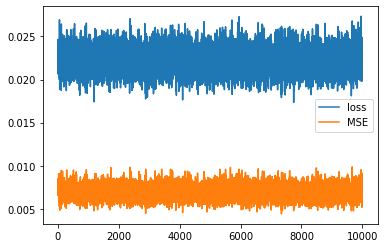

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


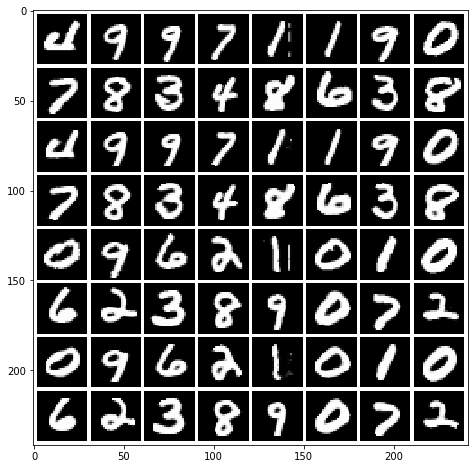

Mean squared dist: 0.0075243074
epoch: 98 	 step:0 	 loss: 0.02261 	 reg loss: 0.0013
epoch: 98 	 step:100 	 loss: 0.02061 	 reg loss: 0.001296
epoch: 98 	 step:200 	 loss: 0.02021 	 reg loss: 0.001288
epoch: 98 	 step:300 	 loss: 0.02324 	 reg loss: 0.001285
epoch: 98 	 step:400 	 loss: 0.02282 	 reg loss: 0.001342
epoch: 98 	 step:500 	 loss: 0.02394 	 reg loss: 0.00132
epoch: 98 	 step:600 	 loss: 0.02069 	 reg loss: 0.001263
epoch: 98 	 step:700 	 loss: 0.02114 	 reg loss: 0.001228
epoch: 98 	 step:800 	 loss: 0.02265 	 reg loss: 0.001289
epoch: 98 	 step:900 	 loss: 0.0212 	 reg loss: 0.001261
epoch: 98 	 step:1000 	 loss: 0.0224 	 reg loss: 0.001283
epoch: 98 	 step:1100 	 loss: 0.02285 	 reg loss: 0.00129
epoch: 98 	 step:1200 	 loss: 0.02317 	 reg loss: 0.001283
epoch: 98 	 step:1300 	 loss: 0.02256 	 reg loss: 0.00128
epoch: 98 	 step:1400 	 loss: 0.02182 	 reg loss: 0.001302
epoch: 98 	 step:1500 	 loss: 0.02549 	 reg loss: 0.001321
epoch: 98 	 step:1600 	 loss: 0.02426 	 reg

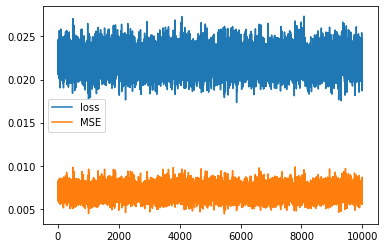

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


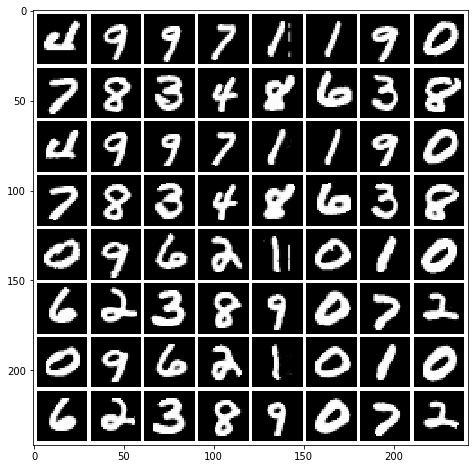

Mean squared dist: 0.0075448314
epoch: 99 	 step:0 	 loss: 0.02293 	 reg loss: 0.001269
epoch: 99 	 step:100 	 loss: 0.02141 	 reg loss: 0.001268
epoch: 99 	 step:200 	 loss: 0.02142 	 reg loss: 0.001273
epoch: 99 	 step:300 	 loss: 0.02296 	 reg loss: 0.001334
epoch: 99 	 step:400 	 loss: 0.02288 	 reg loss: 0.001323
epoch: 99 	 step:500 	 loss: 0.02086 	 reg loss: 0.001262
epoch: 99 	 step:600 	 loss: 0.02319 	 reg loss: 0.001316
epoch: 99 	 step:700 	 loss: 0.02051 	 reg loss: 0.001244
epoch: 99 	 step:800 	 loss: 0.01972 	 reg loss: 0.00123
epoch: 99 	 step:900 	 loss: 0.02438 	 reg loss: 0.001317
epoch: 99 	 step:1000 	 loss: 0.01926 	 reg loss: 0.001217
epoch: 99 	 step:1100 	 loss: 0.02277 	 reg loss: 0.00125
epoch: 99 	 step:1200 	 loss: 0.02159 	 reg loss: 0.001296
epoch: 99 	 step:1300 	 loss: 0.02201 	 reg loss: 0.001255
epoch: 99 	 step:1400 	 loss: 0.02191 	 reg loss: 0.001246
epoch: 99 	 step:1500 	 loss: 0.02244 	 reg loss: 0.001228
epoch: 99 	 step:1600 	 loss: 0.02079 

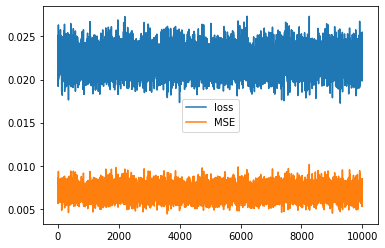

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


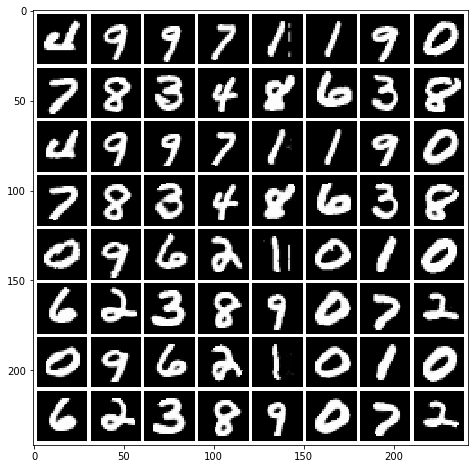

Mean squared dist: 0.0075343717
epoch: 100 	 step:0 	 loss: 0.0215 	 reg loss: 0.0013
epoch: 100 	 step:100 	 loss: 0.02223 	 reg loss: 0.001289
epoch: 100 	 step:200 	 loss: 0.02058 	 reg loss: 0.001279
epoch: 100 	 step:300 	 loss: 0.02389 	 reg loss: 0.001332
epoch: 100 	 step:400 	 loss: 0.02319 	 reg loss: 0.001304
epoch: 100 	 step:500 	 loss: 0.02022 	 reg loss: 0.00124
epoch: 100 	 step:600 	 loss: 0.02351 	 reg loss: 0.001318
epoch: 100 	 step:700 	 loss: 0.02098 	 reg loss: 0.001259
epoch: 100 	 step:800 	 loss: 0.02259 	 reg loss: 0.001291
epoch: 100 	 step:900 	 loss: 0.01975 	 reg loss: 0.00126
epoch: 100 	 step:1000 	 loss: 0.02227 	 reg loss: 0.001325
epoch: 100 	 step:1100 	 loss: 0.02371 	 reg loss: 0.001316
epoch: 100 	 step:1200 	 loss: 0.02202 	 reg loss: 0.001264
epoch: 100 	 step:1300 	 loss: 0.02059 	 reg loss: 0.001265
epoch: 100 	 step:1400 	 loss: 0.02065 	 reg loss: 0.00125
epoch: 100 	 step:1500 	 loss: 0.02368 	 reg loss: 0.001284
epoch: 100 	 step:1600 	 l

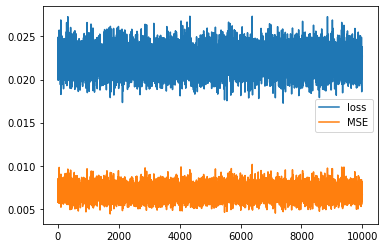

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


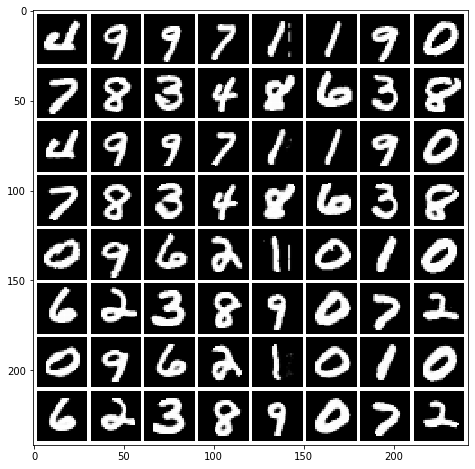

Mean squared dist: 0.0075186756


FileNotFoundError: [Errno 2] No such file or directory: '../cache/vae/FC-VAE256Mnist_100_0100_20191015_154317.sd'

In [15]:
### TRAIN MODEL ###

num_epochs = 100

train_model(vae, optimizer, device, dataloader['train'], epochs=num_epochs);

model_weights = vae.state_dict().copy()
torch.save(model_weights, "../cache/vae/FC-VAE256Mnist_{0}_{0:04d}_{1}.sd".format(num_epochs, time.strftime("%Y%m%d_%H%M%S")))

In [5]:
### LOAD MODEL ###

latent_dim = 128
hidden_dim = 500

vae = models.SignalVAE(shape=imsize, latent_dim=latent_dim, hidden_dim=hidden_dim)
vae.load_state_dict(torch.load("../cache/models/VAE_MNIST/FC-VAE128Mnist_5.sd"));

Version 4


In [16]:
test_recon, test_images = test_model(vae, device, dataloader['test'])
print(test_images.shape)
print(test_recon.shape)

(8000, 1, 28, 28)
(8000, 1, 28, 28)


In [17]:
# Benchmark reconstruction #

benchmark(pred=test_recon[:1024], true=test_images[:1024], check_all=True)

Signal error:
  MSE: 0.0071258953966832905, std: 0.005052186952215963
  MAE: 0.021295168933875175, std: 0.009045725911203865
  SSIM: 0.9413633475825411, std: 0.03808715001564066
  PhCo-MSE: 0.0071425756223959525, std: 0.0051025445682327895
  PhCo-MAE: 0.0213229398243584, std: 0.009107800399958179
  PhCo-SSIM: 0.9411590771659164, std: 0.03871064918630296
  CroCo-MSE: 0.0071258953966832905, std: 0.005052186952215963
  CroCo-MAE: 0.021295168933875175, std: 0.009045725911203865
  CroCo-SSIM: 0.9413633475825411, std: 0.03808715001564066

Magnitude error:
  MSE Magnitude: 2.364258440918216, std: 1.6580870341081269

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 1.00] - should be in [0, 1]

Markdown table values:
 0.007126 | 0.02130 | 0.9414 | 0.007143 | 0.02132 | 0.9412 | 0.007126 | 0.02130 | 0.9414 | 2.364 |


## Evaluation for different VAE  (1024 samples)

| Nr | Size | alpha | gamma | epochs |  MSE | MAE | SSIM | PhaCo-MSE | PhaCo-MAE | PhaCo-SSIM | CroCo-MSE | CroCo-MAE | CroCo-SSIM | MSE Magnitude
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 1 | 784-500-500-20 | 1.0 | 1e-3 | 50 | 0.009365 | 0.02583 | 0.9196 | 0.009481 | 0.02599 | 0.9186 | 0.009364 | 0.02583 | 0.9196 | 2.988 |
| 2 | 784-500-500-20 | 2.0 | 1e-3 | 50 | 0.008110 | 0.02865 | 0.9204 | 0.008358 | 0.02899 | 0.9181 | 0.008110 | 0.02865 | 0.9204 | 2.919 |
| 3 | 784-500-500-128 | 2.0 | 1e-3 | 50 | 0.004890 | 0.02153 | 0.9519 | 0.004895 | 0.02154 | 0.9518 | 0.004890 | 0.02153 | 0.9519 | 1.767 |
| 4 | 784-500-500-784 | 2.0 | 1e-3 | 50 | 0.004292 | 0.01988 | 0.9577 | 0.004296 | 0.01989 | 0.9577 | 0.004292 | 0.01988 | 0.9577 | 1.546 |
| 6(5) | 784-500-500-128 | 1.0 | 1e-3 | 100 | 0.006760 | 0.02074 | 0.9456 | 0.006779 | 0.02076 | 0.9454 | 0.006759 | 0.02074 | 0.9456 | 2.243 |
| 7 | 784-2048-2048-256 | 1.0 | 1e-3 | 100 | 0.007126 | 0.02130 | 0.9414 | 0.007143 | 0.02132 | 0.9412 | 0.007126 | 0.02130 | 0.9414 | 2.364 |

In [8]:
### Load model ###

fcnet = models.FCNet(imsize=imsize, h=2048)
fcnet.load_state_dict(torch.load("../cache//models/FCnet_MNIST/FCNet2048MNIST_6.sd",
                      map_location={'cuda:1': device.__str__()}));

Version 0.4


In [18]:
### Hand Paper (adapted) ###

def calc_mags(x):
    ft =  torch.rfft(x, 2, onesided=False)
    mags = torch.sqrt(torch.sum(ft**2, -1) + 1e-16)
    return mags

def vaeopt(sample_magnitudes, vae, device, measurement_fn=calc_mags,
           z_shape=(20, 1, 1), init_x=None, optim_lr=1e-1, max_steps=5000, max_loss=0.0):
    
    vae.to(device)
    vae.eval()
    
    N = sample_magnitudes.shape[0]
    
    if init_x is None:
        z = torch.randn((N, *z_shape), requires_grad=True, device=device)
    else:
        z = vae.encoder(init_x)[0].clone().detach().requires_grad_(True)
        
    optimizer = optim.Adam([z], lr=optim_lr)
    
    losses = []
    last_out = vae.decoder(z)
    
    for i in range(max_steps):
 
        magnitudes = measurement_fn(last_out)
        mse_all = torch.mean((magnitudes - sample_magnitudes) ** 2, dim=tuple(np.arange(len(magnitudes.shape))[1:]))
        loss = torch.sum(mse_all)
        
        if loss < max_loss:
            break
   
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        last_out = vae.decoder(z)

        losses.append(loss.detach().cpu().item())
        
    return last_out.detach(), losses, mse_all

Batch 1/1 finished


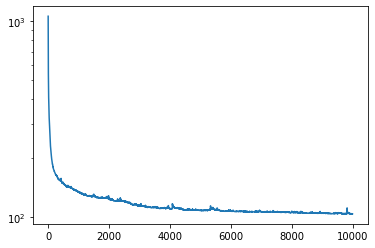

In [19]:
### Test one sample Fourier magnitudes random init + multiple restarts ###

num_batches = 1
batch_size = 32
max_steps = 10000
max_loss = 0.0
optim_lr = 1e-1
restarts = 3

###

out_original = np.zeros((batch_size * num_batches, *imsize))
out_results = np.zeros((batch_size * num_batches, *imsize))
mse_all = np.full((batch_size * num_batches), np.inf)

for batch_i, batch in enumerate(dataloader['test']):
    test_sample = batch.to(device)
    test_magnitudes = calc_mags(test_sample)   
    out_original[batch_size * batch_i : batch_size * batch_i + batch_size] = test_sample.cpu().numpy()
    
    for r in range(restarts):
        cur_out_results, cur_loss, cur_mse_all = vaeopt(sample_magnitudes=test_magnitudes, vae=vae, device=device,
                                                        z_shape=(latent_dim, ), optim_lr=optim_lr, max_steps=max_steps,
                                                        max_loss=max_loss)
        cur_out_results = cur_out_results.cpu().numpy()

        for i in range(batch_size):
            mse = mse_all[batch_size * batch_i + i]
            if cur_mse_all[i] < mse:
                out_results[batch_size * batch_i + i] = cur_out_results[i]
                mse_all[batch_size * batch_i + i] = cur_mse_all[i]
    
    print("Batch {0}/{1} finished".format(batch_i + 1, num_batches))
    if batch_i + 1 >= num_batches:
        break

plt.semilogy(cur_loss)
plt.show()

In [15]:
### CACHE RESULTS ###

import pickle
pickle.dump(out_original, open("/home/shared/phase-retrieval/test/VAE_MNIST/randomInit_original_2_1024.p", "wb"))
pickle.dump(out_results, open("/home/shared/phase-retrieval/test/VAE_MNIST/randomInit_2_1024.p", "wb"))

In [49]:
### LOAD RESULTS ###
import pickle

test_str = "6_1024"

out_original = pickle.load(open("/home/shared/phase-retrieval/test/VAE_MNIST/randomInit_original_{}.p".format(test_str), "rb"))
out_results = pickle.load(open("/home/shared/phase-retrieval/test/VAE_MNIST/randomInit_{}.p".format(test_str), "rb"))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Output under minimized magnitude distance:


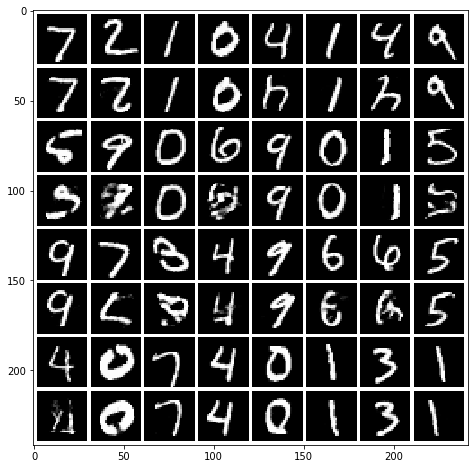

Registered:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


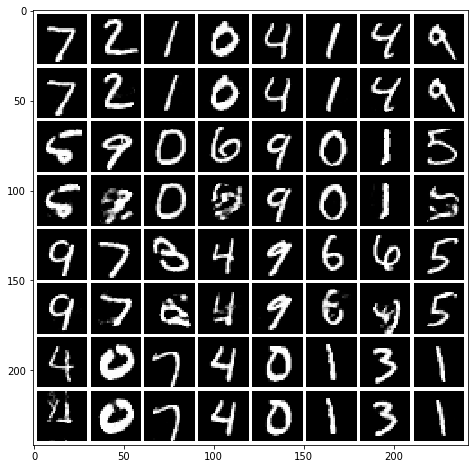

In [50]:
# Benchmark results

print("Output under minimized magnitude distance:")

to_plot = np.stack([out_original[:32].reshape(4, 8, 28, 28), 
                    out_results[:32].reshape(4, 8, 28, 28)], axis=1).reshape(-1, 1, 28, 28)         
plot_grid(to_plot, figsize=(8, 8),
          file="../out/vae/mnist/{0}{1}.png".format('randomInit_{}_'.format(test_str), time.strftime("%Y%m%d_%H%M%S")))

print("Registered:")
results_reg = register_croco(out_results[:32], out_original[:32])
to_plot = np.stack([out_original[:32, 0].reshape(4, 8, 28, 28), 
                    results_reg[:, 0].reshape(4, 8, 28, 28)], axis=1).reshape(-1, 1, 28, 28)        
plot_grid(to_plot, figsize=(8,8),
          file="../out/vae/mnist/{0}{1}.png".format('randomInit_{}_reg'.format(test_str), time.strftime("%Y%m%d_%H%M%S")))

In [20]:
benchmark(pred=out_results, true=out_original, check_all=True)

Signal error:
  MSE: 0.09129691403626485, std: 0.04662224138141763
  MAE: 0.12041244242724541, std: 0.05124599400838607
  SSIM: 0.39297441480726414, std: 0.26314656005475423
  PhCo-MSE: 0.023862394994614497, std: 0.034334935421197026
  PhCo-MAE: 0.042798039191016476, std: 0.04288476307988856
  PhCo-SSIM: 0.8086680118177199, std: 0.23917094272985792
  CroCo-MSE: 0.0171712158358948, std: 0.02274254658659204
  CroCo-MAE: 0.03558643552264271, std: 0.031511063668297694
  CroCo-SSIM: 0.8423239192216068, std: 0.18630683258754607

Magnitude error:
  MSE Magnitude: 1.3303905138124232, std: 1.7247638177855293

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 1.00] - should be in [0, 1]

Markdown table values:
 0.09130 | 0.1204 | 0.3930 | 0.02386 | 0.04280 | 0.8087 | 0.01717 | 0.03559 | 0.8423 | 1.330 |


## Test Fourier magnitudes random init (32 samples)

| Nr Type | iterations | restarts | lr | MSE | MAE | SSIM | PhaCo-MSE | PhaCo-MAE | PhaCo-SSIM | CroCo-MSE | CroCo-MAE | CroCo-SSIM | MSE Magnitude
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 1 | 10000 | 3 | 1e-1 | 0.06869 | 0.09801 | 0.5130 | 0.02485 | 0.04731 | 0.7993 | 0.02064 | 0.04266 | 0.8157 | 2.115 |
| 2 | 10000 | 3 | 1e-1 | 0.06673 | 0.09784 | 0.5321 | 0.02261 | 0.04689 | 0.8017 | 0.01744 | 0.04120 | 0.8306 | 2.272 |
| 3 | 10000 | 3 | 1e-1 | 0.09310 | 0.1233 | 0.3938 | 0.01298 | 0.02584 | 0.8999 | 0.01238 | 0.02525 | 0.9036 | 0.5381 |
| 4 | 10000 | 3 | 1e-1 | 0.08482 | 0.1141 | 0.4462 | 0.02745 | 0.04843 | 0.7884 | 0.02187 | 0.04257 | 0.8242 | 1.366 |
| 5 | 10000 | 3 | 1e-1 | 0.09069 | 0.1202 | 0.3825 | 0.01862 | 0.03493 | 0.8560 | 0.01363 | 0.02972 | 0.8758 | 0.9501 |
| 6 | 10000 | 3 | 1e-1 | 0.06826 | 0.09716 | 0.5204 | 0.01234 | 0.02720 | 0.8935 | 0.01116 | 0.02618 | 0.9004 | 0.7915 |
| 7 | 10000 | 3 | 1e-1 | 0.09130 | 0.1204 | 0.3930 | 0.02386 | 0.04280 | 0.8087 | 0.01717 | 0.03559 | 0.8423 | 1.330 |

## Test Fourier magnitudes random init (1024 samples)

| Nr Type | iterations | restarts | lr | MSE | MAE | SSIM | PhaCo-MSE | PhaCo-MAE | PhaCo-SSIM | CroCo-MSE | CroCo-MAE | CroCo-SSIM | MSE Magnitude
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 2 | 10000 | 3 | 1e-1 | 0.05921 | 0.09012 | 0.5736 | 0.01981 | 0.04337 | 0.8323 | 0.01652 | 0.03976 | 0.8482 | 2.219 |
| 3 | 10000 | 3 | 1e-1 | 0.08482 | 0.1147 | 0.4385 | 0.01151 | 0.02437 | 0.9102 | __0.009258__ | __0.02206__ | __0.9188__ | 0.4541 |
| 6 | 10000 | 3 | 1e-1 | 0.08032 | 0.1101 | 0.4560 | 0.01808 | 0.03469 | 0.8589 | 0.01482 | 0.03121 | 0.8730 | 0.8510 |


Batch 1/32 finished
Batch 2/32 finished
Batch 3/32 finished
Batch 4/32 finished
Batch 5/32 finished
Batch 6/32 finished
Batch 7/32 finished
Batch 8/32 finished
Batch 9/32 finished
Batch 10/32 finished
Batch 11/32 finished
Batch 12/32 finished
Batch 13/32 finished
Batch 14/32 finished
Batch 15/32 finished
Batch 16/32 finished
Batch 17/32 finished
Batch 18/32 finished
Batch 19/32 finished
Batch 20/32 finished
Batch 21/32 finished
Batch 22/32 finished
Batch 23/32 finished
Batch 24/32 finished
Batch 25/32 finished
Batch 26/32 finished
Batch 27/32 finished
Batch 28/32 finished
Batch 29/32 finished
Batch 30/32 finished
Batch 31/32 finished
Batch 32/32 finished


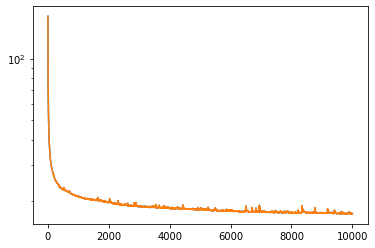

In [34]:
### Test one sample Fourier magnitudes with end-to-end init ###

num_batches = 32
batch_size = 32
max_steps = 10000
max_loss = 0.0
optim_lr= 1e-1

###

out_original = np.zeros((batch_size * num_batches, *imsize))
out_results = np.zeros((batch_size * num_batches, *imsize))
mse_all = np.full((batch_size * num_batches), np.inf)

for batch_i, batch in enumerate(dataloader['test']):
    test_sample = batch.to(device)
    test_magnitudes = calc_mags(test_sample)
    out_original[batch_size * batch_i : batch_size * batch_i + batch_size] = test_sample.cpu().numpy()

    fcnet.to(device)
    fcnet.eval()
    init_x = fcnet(test_magnitudes).detach()

    cur_out_results, cur_loss, cur_mse_all = vaeopt(sample_magnitudes=test_magnitudes, vae=vae, device=device,
                                                    init_x=init_x, z_shape=(latent_dim, ), optim_lr=optim_lr,
                                                    max_steps=max_steps, max_loss=max_loss)
    cur_out_results = cur_out_results.cpu().numpy()
    
    out_results[batch_size * batch_i : batch_size * batch_i + batch_size] = cur_out_results
    mse_all[batch_size * batch_i : batch_size * batch_i + batch_size] = cur_mse_all.detach().cpu().numpy()
    
    print("Batch {0}/{1} finished".format(batch_i + 1, num_batches))
    if batch_i + 1 >= num_batches:
        break

plt.plot(cur_loss)
plt.semilogy(cur_loss)
plt.show()

In [35]:
### CACHE RESULTS ###

import pickle
pickle.dump(out_original, open("/home/shared/phase-retrieval/test/VAE_MNIST/e2eInit_original_6_1024.p", "wb"))
pickle.dump(out_results, open("/home/shared/phase-retrieval/test/VAE_MNIST/e2eInit_6_1024.p", "wb"))

In [73]:
### LOAD RESULTS ###
import pickle

test_str = "6_1024"

out_original = pickle.load(open("/home/shared/phase-retrieval/test/VAE_MNIST/e2eInit_original_{}.p".format(test_str), "rb"))
out_results = pickle.load(open("/home/shared/phase-retrieval/test/VAE_MNIST/e2eInit_{}.p".format(test_str), "rb"))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Output under minimized magnitude distance:


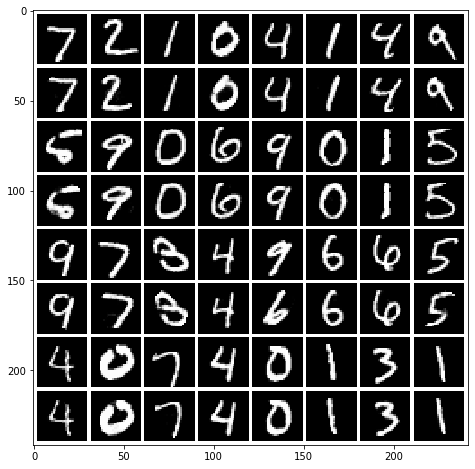

Registered:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


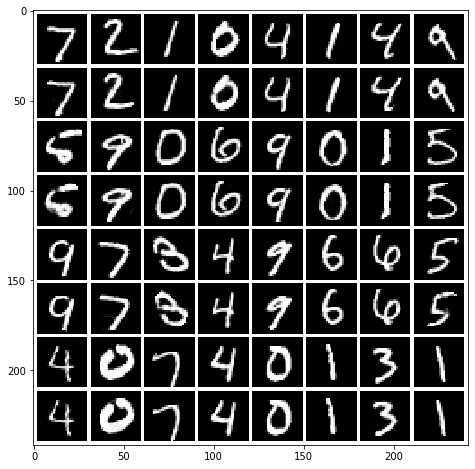

In [74]:
# Benchmark results

print("Output under minimized magnitude distance:")

to_plot = np.stack([out_original[:32].reshape(4, 8, 28, 28), 
                    out_results[:32].reshape(4, 8, 28, 28)], axis=1).reshape(-1, 1, 28, 28)         
plot_grid(to_plot, figsize=(8, 8),
          file="../out/vae/mnist/{0}{1}.png".format('e2eInit_{}_'.format(test_str), time.strftime("%Y%m%d_%H%M%S")))

print("Registered:")
results_reg = register_croco(out_results[:32], out_original[:32])
to_plot = np.stack([out_original[:32, 0].reshape(4, 8, 28, 28), 
                    results_reg[:, 0].reshape(4, 8, 28, 28)], axis=1).reshape(-1, 1, 28, 28)        
plot_grid(to_plot, figsize=(8,8),
          file="../out/vae/mnist/{0}{1}.png".format('e2eInit_{}_reg'.format(test_str), time.strftime("%Y%m%d_%H%M%S")))

In [75]:
benchmark(pred=out_results, true=out_original, check_all=True)

Signal error:
  MSE: 0.030286147258441195, std: 0.02900544580819682
  MAE: 0.052246515069052715, std: 0.037912793730072024
  SSIM: 0.7701555096567315, std: 0.19791287872166466
  PhCo-MSE: 0.006619252526250688, std: 0.01165799939978605
  PhCo-MAE: 0.019655761154136503, std: 0.01837498080909723
  PhCo-SSIM: 0.9423661483904271, std: 0.08596546515321259
  CroCo-MSE: 0.005787309135534673, std: 0.008226969985031415
  CroCo-MAE: 0.018719397567085627, std: 0.01542595756568501
  CroCo-SSIM: 0.9465743251762109, std: 0.07265768594412651

Magnitude error:
  MSE Magnitude: 0.5341784610106803, std: 0.656365632021257

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 1.00] - should be in [0, 1]

Markdown table values:
 0.03029 | 0.05225 | 0.7702 | 0.006619 | 0.01966 | 0.9424 | 0.005787 | 0.01872 | 0.9466 | 0.5342 |


## Test Fourier magnitudes end-to-end init (32 samples)

| Nr Type | iterations | lr | MSE | MAE | SSIM | PhaCo-MSE | PhaCo-MAE | PhaCo-SSIM | CroCo-MSE | CroCo-MAE | CroCo-SSIM | MSE Magnitude
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 1 | 10000 | 1e-1 | 0.02536 | 0.04709 | 0.8099 | 0.009244 | 0.02731 | 0.9173 | 0.008945 | 0.02691 | 0.9205 | 1.411 |
| 2 | 10000 | 1e-1 | 0.02082 | 0.04452 | 0.8289 | 0.009717 | 0.03027 | 0.9110 | 0.009441 | 0.03019 | 0.9115 | 1.534 |
| 3 | 10000 | 1e-1 | 0.01563 | 0.03030 | 0.8827 | 0.001313 | 0.009306 | 0.9860 | 0.001237 | 0.009134 | 0.9870 | 0.1314 |
| 4 | 10000 | 1e-1 | 0.01343 | 0.03024 | 0.8990 | 0.003860 | 0.01778 | 0.9635 | 0.003600 | 0.01737 | 0.9660 | 0.4975 |
| 5 | 10000 | 1e-1 | 0.02892 | 0.04965 | 0.7858 | 0.006089 | 0.01843 | 0.9455 | 0.005547 | 0.01768 | 0.9490 | 0.6764 |
| 6 | 10000 | 1e-1 | 0.03106 | 0.05328 | 0.7688 | 0.005862 | 0.01888 | 0.9515 | 0.005147 | 0.01800 | 0.9561 | 0.5433 |


## Test Fourier magnitudes end-to-end init (1024 samples)

| Nr Type | iterations | lr | MSE | MAE | SSIM | PhaCo-MSE | PhaCo-MAE | PhaCo-SSIM | CroCo-MSE | CroCo-MAE | CroCo-SSIM | MSE Magnitude
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 3 | 10000 |  1e-1 | 0.02089 | 0.03819 | 0.8402 | 0.002207 | 0.01052 | 0.9787 | __0.001945__ | __0.01020__ | __0.9809__ | 0.1583 |
| 6 | 10000 |  1e-1 | 0.03029 | 0.05225 | 0.7702 | 0.006619 | 0.01966 | 0.9424 | 0.005787 | 0.01872 | 0.9466 | 0.5342 |

